In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from Utils_orientation import angle_cal, create_images
from Utils_plot import plot_double_result

import time
import numpy as np
import cv2
import torch

from utils.datasets import letterbox
from utils.models import *
from Utils_orientation import *

# Image path
base_file = 'figures/' + str(71) + '.jpg'
rotate_file = 'figures/' + str(99) + '.jpg'

img_orig = cv2.imread(base_file)
img_rotate = cv2.imread(rotate_file)
(h, w) = img_orig.shape[:2]
center = (w / 2, h / 2)
img_base = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
img_rotate = cv2.cvtColor(img_rotate, cv2.COLOR_BGR2GRAY)

bins = 360
thres = 50
# The translation angles
angle_limits = 15

angle_estimation = []

In [2]:
 # Sift Create and calculate
sift = cv2.xfeatures2d.SIFT_create()
# Kp is key points
# des is feature descriptor
# len(des) = len(Kp) * 128
kp1, des1 = sift.detectAndCompute(img_base, None)
kp2, des2 = sift.detectAndCompute(img_rotate, None)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Cal the Orientation
rotate_angle = []
key_point = 15

key_point = min(key_point, int(len(matches) / 2))


img = cv2.drawMatches(img_base, kp1, img_rotate, kp2, matches[:key_point], None, flags=2)
cv2.imwrite("output/matching.png", img)

True

<font face='Ubuntu' size = 4>

## Using the histogram of Gradients direction
### Manual image
Estimate the rotate angel based on the whole image. The steps is as follows:
1. Calculate the gradients based on sobel filter including matnitude and direction
2. Set the magnitude threshold, delete the weak edge
3. Count the historgram of directions
4. Calculate the translation value

The HoG estimation when (1.0) is  1 in 0.0369s
The HoG estimation when (2.0) is  2 in 0.0309s
The HoG estimation when (3.0) is  3 in 0.0299s
The HoG estimation when (4.0) is  4 in 0.0479s
The HoG estimation when (5.0) is  5 in 0.0309s
The HoG estimation when (6.0) is  6 in 0.0299s
The HoG estimation when (7.0) is  7 in 0.0349s
The HoG estimation when (8.0) is  8 in 0.0459s
The HoG estimation when (9.0) is  9 in 0.0279s
The HoG estimation when (10.0) is 10 in 0.0289s


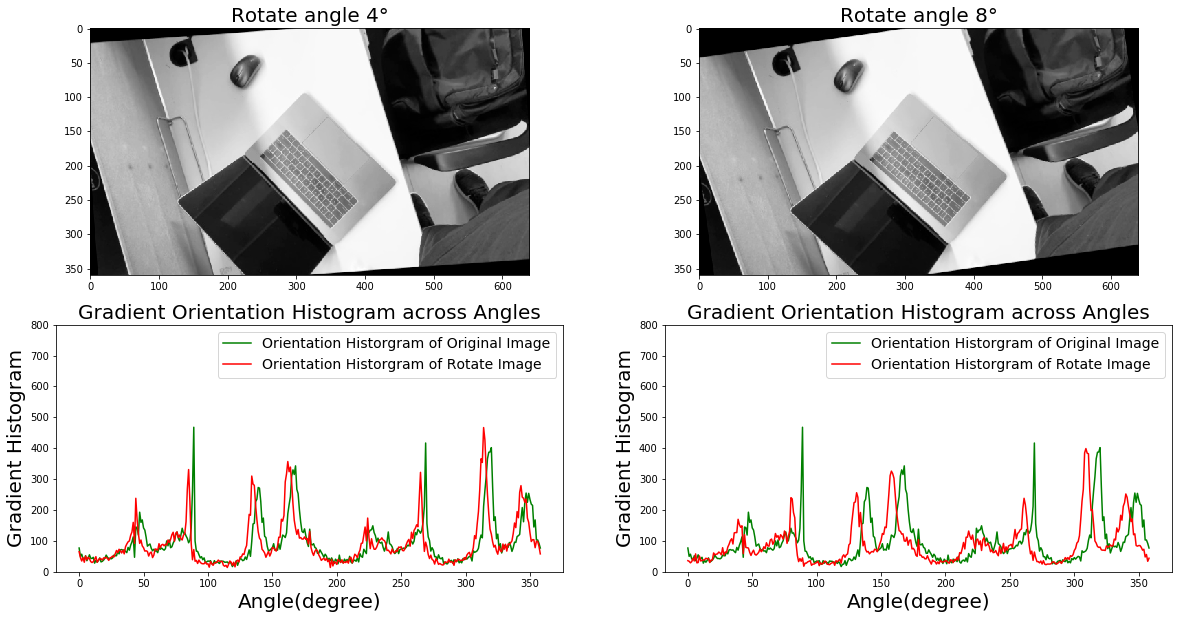

In [3]:
plt.figure(figsize=(20, 10))
for rotate_angle in range(1, 11):
    M = cv2.getRotationMatrix2D(center, rotate_angle, 1)
    img_rotate = cv2.warpAffine(img_base, M, (w, h))
    start = time.time()

    hist_base = HoG_cal(img_base, mag_thres= thres, bin_num= bins)
    hist_rotate = HoG_cal(img_rotate, mag_thres= thres, bin_num= bins)
    if rotate_angle % 4 == 0 and True:
        plot_index = rotate_angle / 4
        plt.subplot(2, 2, plot_index)
        plt.imshow(img_rotate, cmap= 'Greys_r')
        plt.title("Rotate angle " + str(rotate_angle) + "°", fontsize = 20)
        plt.subplot(2, 2, plot_index + 2) 
        plt.plot(hist_base, 'g', label = 'Orientation Historgram of Original Image')
        plt.plot(hist_rotate, 'r', label = 'Orientation Historgram of Rotate Image')
        plt.legend(fontsize = 14)
        plt.ylim((0, 800))
        plt.xlabel('Angle(degree)', fontsize = 20)
        plt.ylabel('Gradient Histogram', fontsize = 20)
        plt.title("Gradient Orientation Histogram across Angles", fontsize = 20)
    # Using HoG to calculate the angel
    angle = angle_HoG(hist_base, hist_rotate, limits = angle_limits)
    print("The HoG estimation when ({0:.1f}) is {1:2d} in {2:.4f}s" \
        .format(rotate_angle ,angle, time.time() - start))
plt.savefig('output/HOG_manual.png')

<font face='Ubuntu' size = 4>

### Real image result
The previous experiment is using the maunual images.
This experiment is using the real image

The HoG estimation is  8


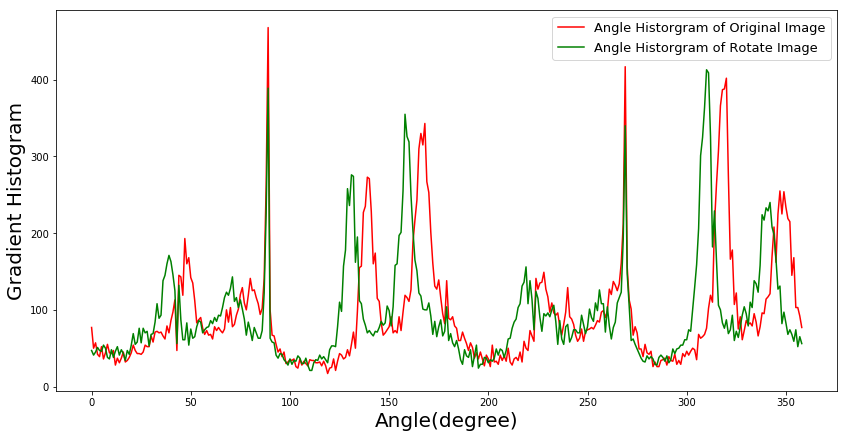

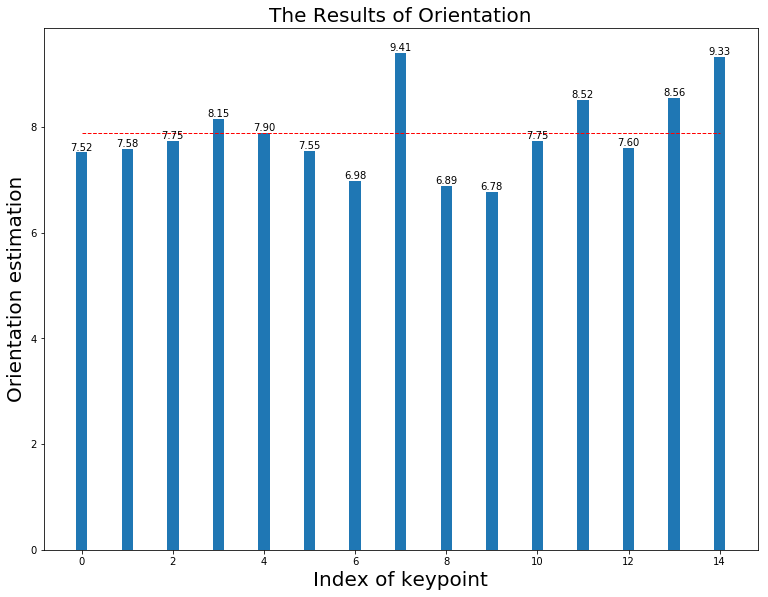

Final result: [     7.5247       7.583       7.746      8.1511      7.8967      7.5499      6.9844      9.4071      6.8904      6.7804      7.7452      8.5187      7.6039      8.5594      9.3293]
FD Rotate(10.0):mean(7.885), median(7.885) in 0.094


In [4]:
hist_base = HoG_cal(img_base, mag_thres= thres, bin_num= bins)

img_rotate = cv2.imread(rotate_file)
img_rotate = cv2.cvtColor(img_rotate, cv2.COLOR_BGR2GRAY)
hist_rotate = HoG_cal(img_rotate, mag_thres= thres, bin_num= bins)

angle = angle_HoG(hist_base, hist_rotate, limits = angle_limits)
print("The HoG estimation is {0:2d}".format(angle))
plt.figure(figsize=(14, 7))
plt.plot(hist_base, 'r', label = 'Angle Historgram of Original Image')
plt.plot(hist_rotate, 'g', label = 'Angle Historgram of Rotate Image')
plt.legend(fontsize = 13)
plt.xlabel('Angle(degree)', fontsize = 20)
plt.ylabel('Gradient Histogram', fontsize = 20)
plt.savefig('output/HOG_real.jpg')

median_rotate, mean_rotate, exe_time = angle_cal(img_orig, img_rotate, "SIFT", show_results= True)
print("FD Rotate({0:3.1f}):mean({1:5.3f}), median({2:5.3f}) in {3:.3f}"\
      .format(rotate_angle, mean_rotate, median_rotate, exe_time))

<font face='Ubuntu' size = 4>
    
## Feature desciptor method

In [5]:
mode_list = ["SIFT", "ORB"]

sift_error = np.array([])
orb_error = np.array([])

result = np.zeros((16, 5))
for i, rotate_angle in enumerate(np.arange(0.5, 8.5, 0.5)):
    for mode in mode_list:
        M = cv2.getRotationMatrix2D(center, rotate_angle, 1)
        img_rotate = cv2.warpAffine(img_base, M, (w, h))
        
        fd_median, fd_mean, exe_time = angle_cal(img_orig, img_rotate, mode, show_results= False)
        
        print("FD Rotate({0:3.1f}):mean({1:5.3f}), median({2:5.3f}) in {3:.3f}"\
              .format(rotate_angle, fd_mean, fd_median, exe_time))
        result[i, 0] = rotate_angle
        
        if mode == "SIFT":
            sift_error = np.append(sift_error, np.abs(fd_mean - rotate_angle))
            result[i, 1] = fd_mean
            result[i, 2] = exe_time
        elif mode == "ORB":
            orb_error = np.append(orb_error, np.abs(fd_mean - rotate_angle))
            result[i, 3] = fd_mean
            result[i, 4] = exe_time

print(result)

FD Rotate(0.5):mean(0.548), median(0.548) in 0.091
FD Rotate(0.5):mean(0.305), median(0.305) in 0.178
FD Rotate(1.0):mean(0.897), median(0.897) in 0.103
FD Rotate(1.0):mean(0.640), median(0.469) in 0.025
FD Rotate(1.5):mean(1.366), median(1.366) in 0.091
FD Rotate(1.5):mean(0.688), median(0.688) in 0.021
FD Rotate(2.0):mean(2.116), median(2.116) in 0.092
FD Rotate(2.0):mean(1.876), median(1.509) in 0.020
FD Rotate(2.5):mean(2.350), median(2.350) in 0.097
FD Rotate(2.5):mean(1.967), median(2.098) in 0.016
FD Rotate(3.0):mean(3.001), median(3.001) in 0.097
FD Rotate(3.0):mean(2.312), median(1.859) in 0.016
FD Rotate(3.5):mean(3.532), median(3.532) in 0.099
FD Rotate(3.5):mean(2.994), median(3.251) in 0.013
FD Rotate(4.0):mean(4.122), median(4.122) in 0.100
FD Rotate(4.0):mean(3.780), median(3.731) in 0.011
FD Rotate(4.5):mean(4.475), median(4.475) in 0.102
FD Rotate(4.5):mean(4.165), median(4.165) in 0.011
FD Rotate(5.0):mean(5.101), median(5.101) in 0.104
FD Rotate(5.0):mean(4.289), med

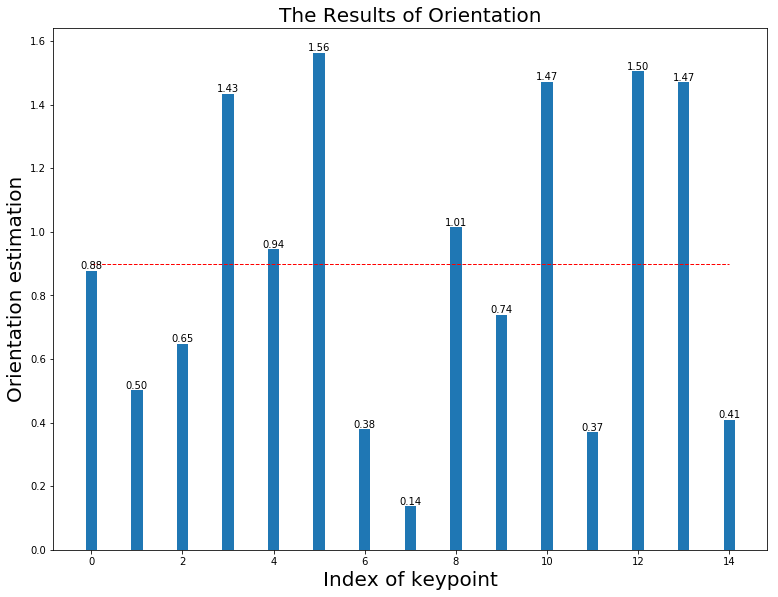

Final result: [    0.87665     0.50101     0.64688       1.433     0.94427      1.5626     0.37901     0.13666      1.0134     0.73843      1.4718      0.3688      1.5042      1.4692     0.40889]
FD Rotate(1.0):mean(0.897), median(0.897) in 0.095
The HoG estimation when (1.0) is  1


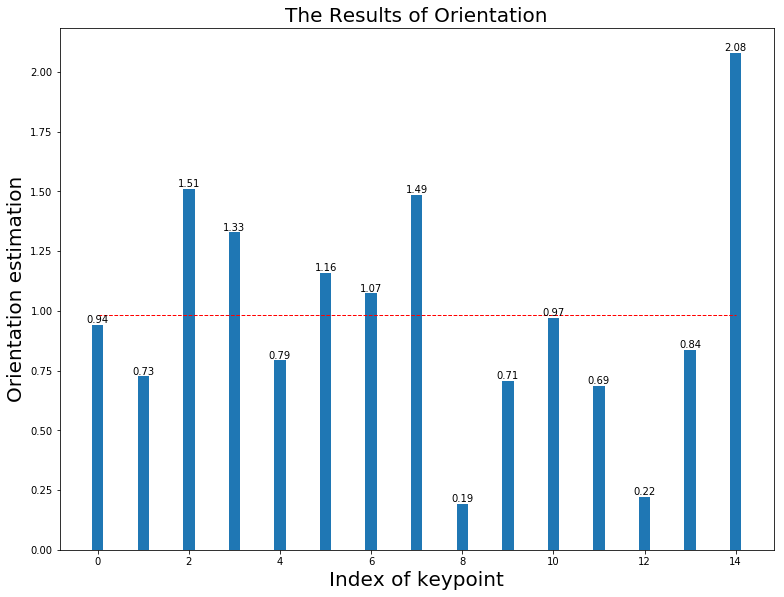

Final result: [    0.94012     0.72598      1.5102      1.3283     0.79207      1.1596       1.073      1.4856     0.19061     0.70654     0.97003     0.68716     0.22104     0.83566      2.0795]
FD Rotate(1.1):mean(0.980), median(0.980) in 0.098
The HoG estimation when (1.1) is  1


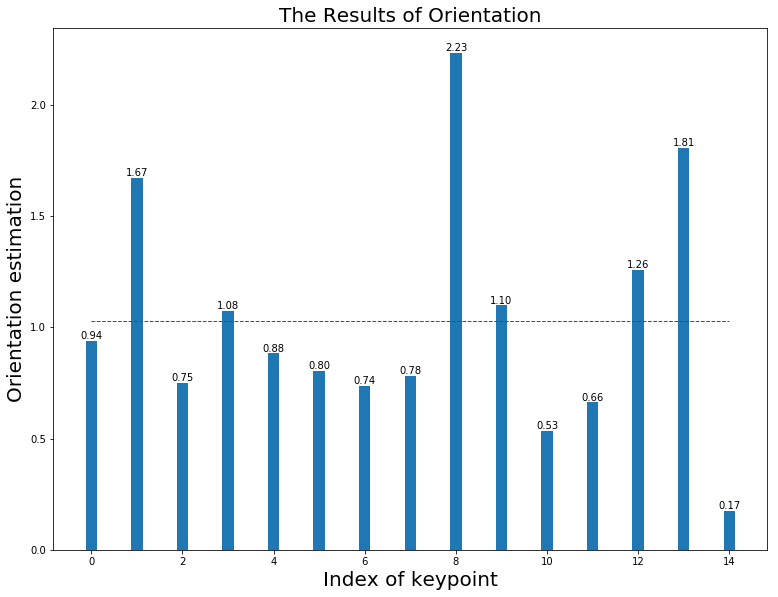

Final result: [    0.93878      1.6727     0.75008      1.0751     0.88211     0.80255     0.73502     0.78067       2.233      1.0983     0.53418     0.66216      1.2562      1.8064     0.17444]
FD Rotate(1.2):mean(1.027), median(1.027) in 0.098
The HoG estimation when (1.2) is  1


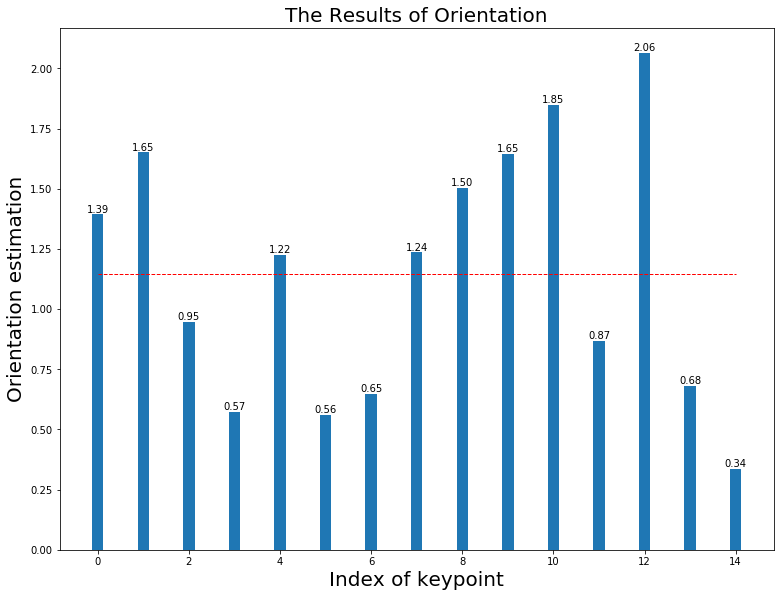

Final result: [     1.3938      1.6511     0.94809     0.57384      1.2245     0.56012      0.6468      1.2354       1.503      1.6459      1.8475     0.86716      2.0649      0.6803     0.33728]
FD Rotate(1.3):mean(1.145), median(1.145) in 0.112
The HoG estimation when (1.3) is  1


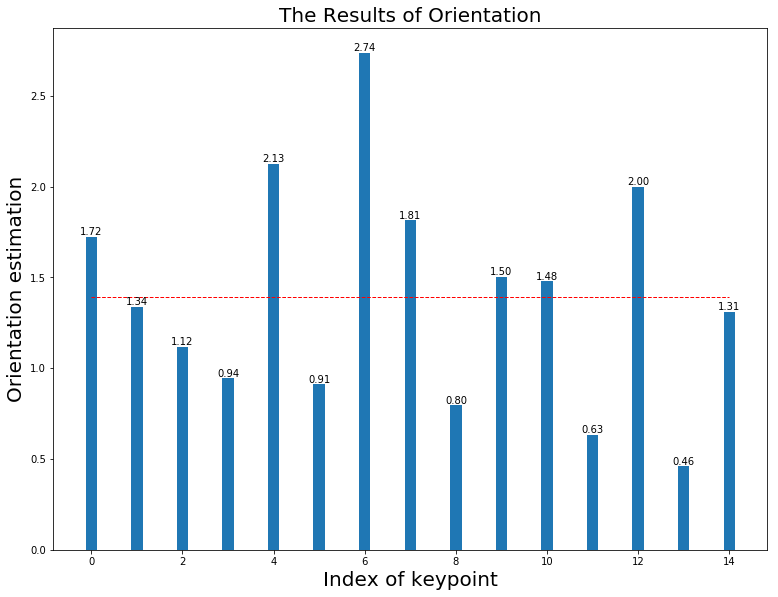

Final result: [     1.7236      1.3384      1.1156     0.94473      2.1271      0.9111      2.7372      1.8144      0.7959      1.5039      1.4786     0.63232      1.9985     0.45929      1.3093]
FD Rotate(1.4):mean(1.393), median(1.393) in 0.098
The HoG estimation when (1.4) is  2


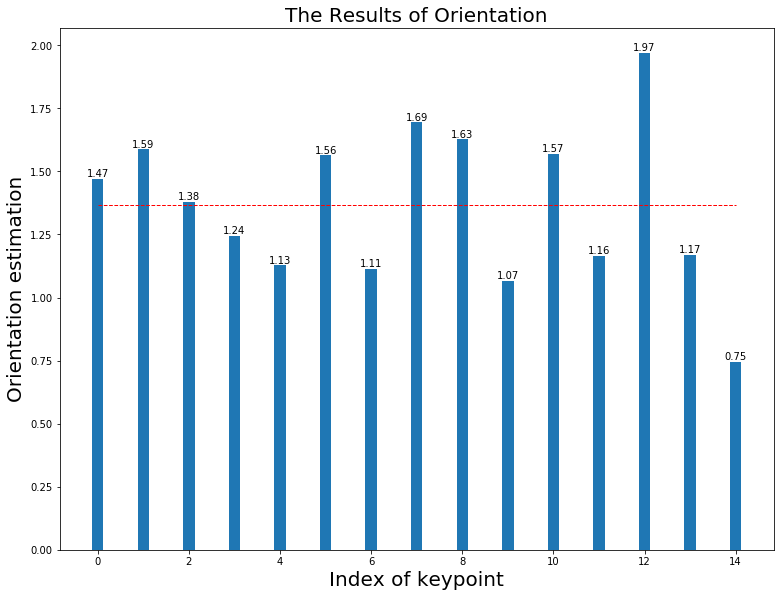

Final result: [     1.4717      1.5875      1.3779      1.2441      1.1277      1.5641      1.1137      1.6945      1.6266      1.0664      1.5692      1.1645      1.9702       1.168     0.74541]
FD Rotate(1.5):mean(1.366), median(1.366) in 0.104
The HoG estimation when (1.5) is  2


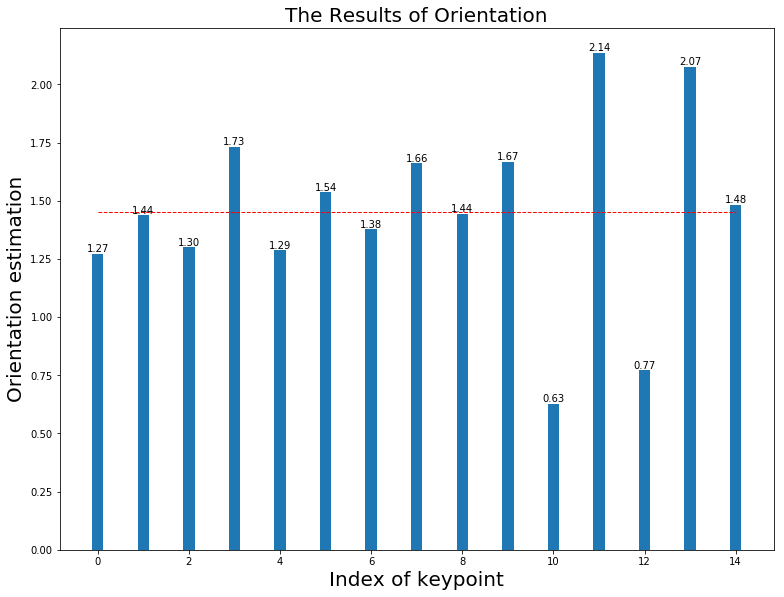

Final result: [     1.2725       1.437      1.2994      1.7301       1.287      1.5352      1.3766      1.6601      1.4429      1.6672     0.62766      2.1355     0.77122       2.074      1.4819]
FD Rotate(1.6):mean(1.453), median(1.453) in 0.085
The HoG estimation when (1.6) is  2


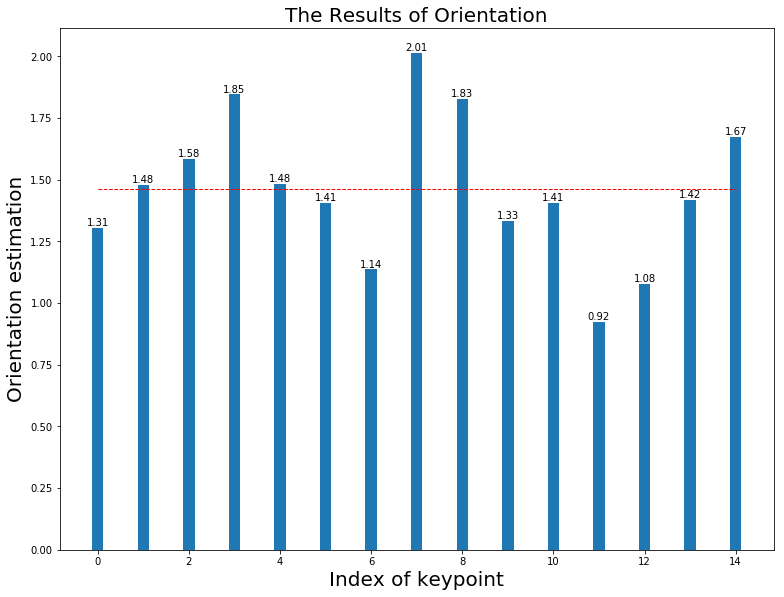

Final result: [     1.3053      1.4784      1.5831      1.8456      1.4826      1.4066      1.1368      2.0141      1.8285      1.3336      1.4055     0.92249      1.0771      1.4187      1.6722]
FD Rotate(1.7):mean(1.461), median(1.461) in 0.104
The HoG estimation when (1.7) is  2


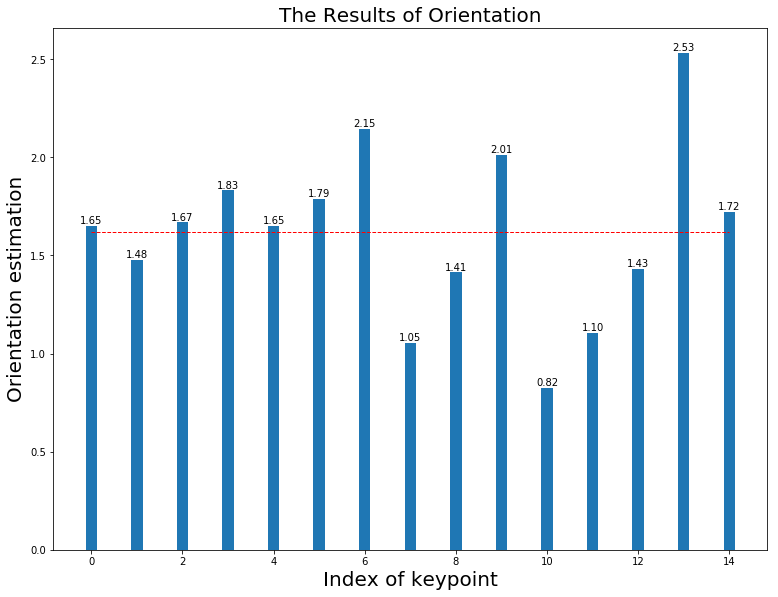

Final result: [     1.6523      1.4785      1.6689      1.8318      1.6523      1.7895      2.1453      1.0548      1.4136      2.0134     0.82489      1.1041      1.4314      2.5329      1.7207]
FD Rotate(1.8):mean(1.621), median(1.621) in 0.101
The HoG estimation when (1.8) is  2


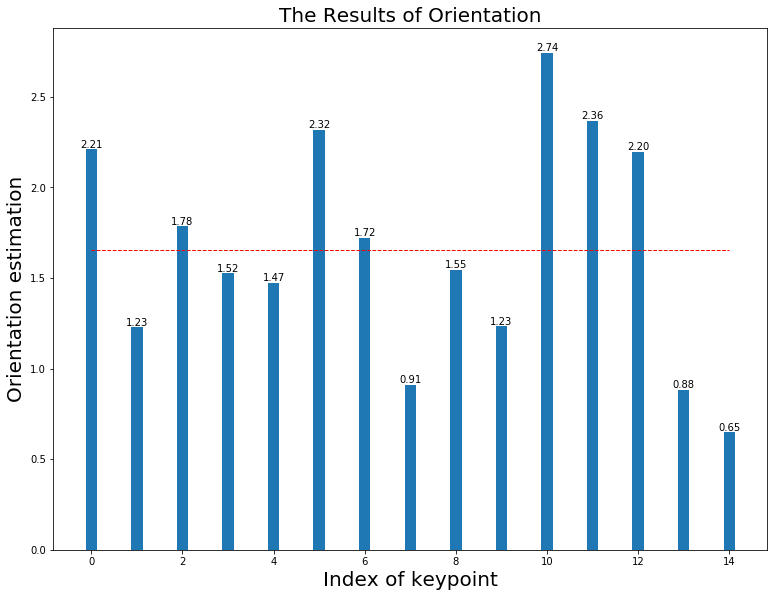

Final result: [     2.2093      1.2275      1.7839      1.5243       1.473      2.3177      1.7209     0.91098      1.5457      1.2333      2.7419      2.3649      2.1954     0.88315     0.64764]
FD Rotate(1.9):mean(1.652), median(1.652) in 0.102
The HoG estimation when (1.9) is  2


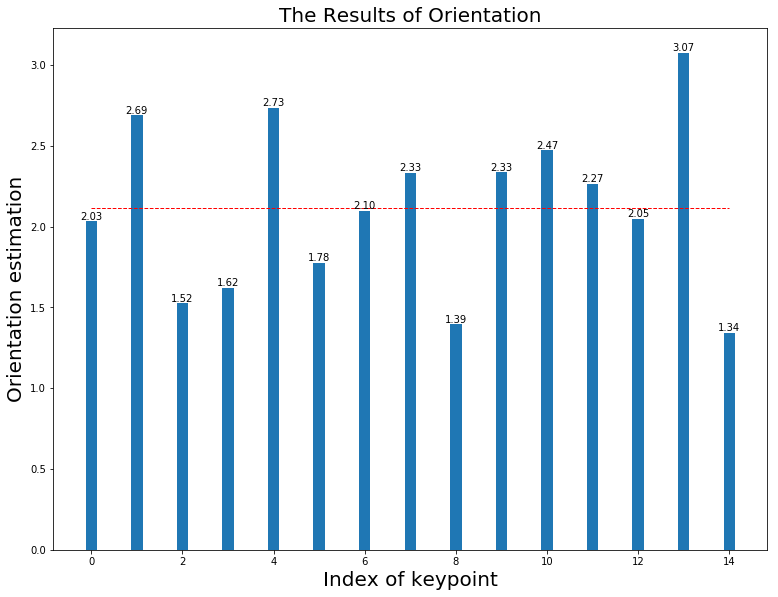

Final result: [     2.0324      2.6877      1.5247      1.6221      2.7337       1.777      2.0988      2.3318      1.3949      2.3343      2.4713       2.265      2.0457      3.0747      1.3415]
FD Rotate(2.0):mean(2.116), median(2.116) in 0.090
The HoG estimation when (2.0) is  2


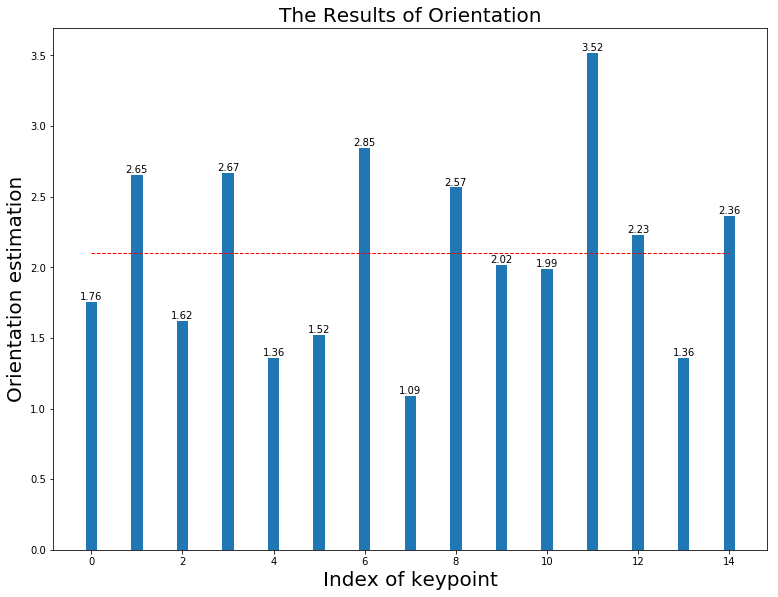

Final result: [     1.7564      2.6523      1.6187       2.669      1.3564      1.5208      2.8459      1.0879      2.5655      2.0167      1.9865      3.5182      2.2308      1.3611      2.3648]
FD Rotate(2.1):mean(2.103), median(2.103) in 0.098
The HoG estimation when (2.1) is  2


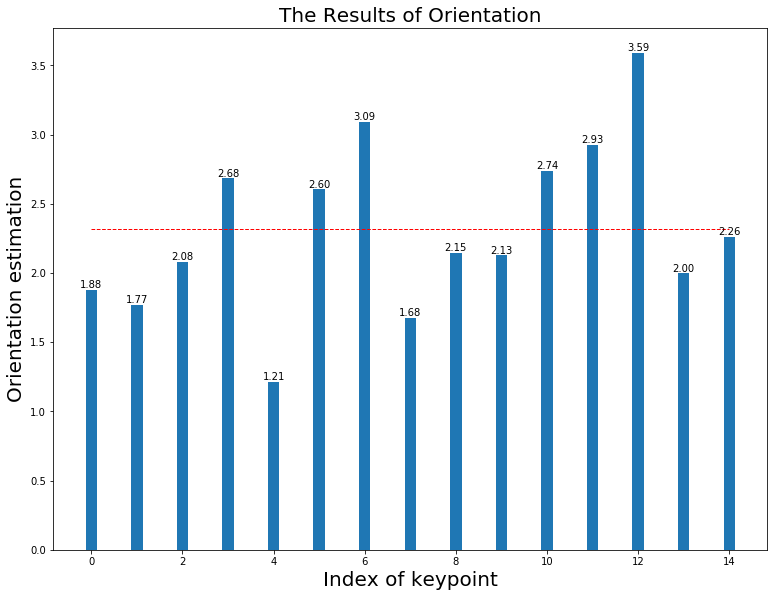

Final result: [     1.8779      1.7679      2.0806       2.683      1.2143      2.6035      3.0938       1.678      2.1453      2.1274      2.7397      2.9262      3.5909      1.9981      2.2591]
FD Rotate(2.2):mean(2.319), median(2.319) in 0.085
The HoG estimation when (2.2) is  2


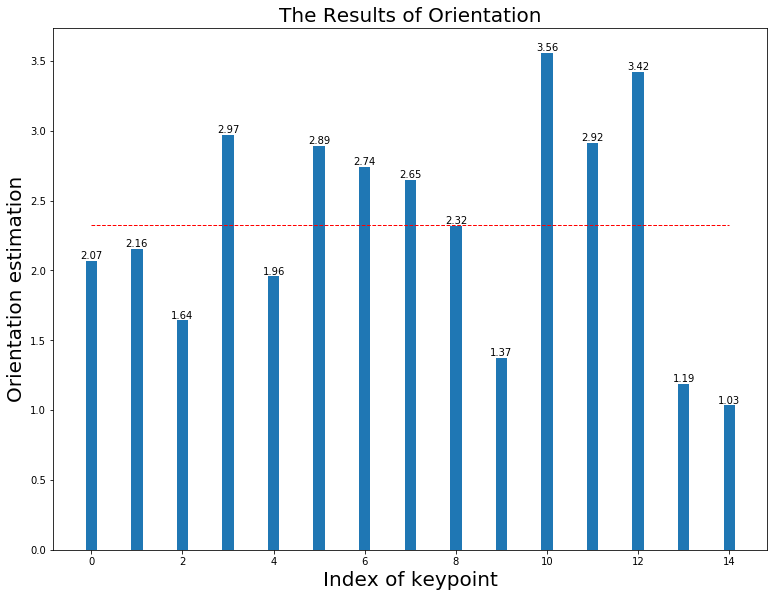

Final result: [     2.0672      2.1568      1.6419      2.9692      1.9572      2.8913      2.7393      2.6476      2.3198      1.3748      3.5579      2.9155      3.4188      1.1869      1.0345]
FD Rotate(2.3):mean(2.325), median(2.325) in 0.100
The HoG estimation when (2.3) is  2


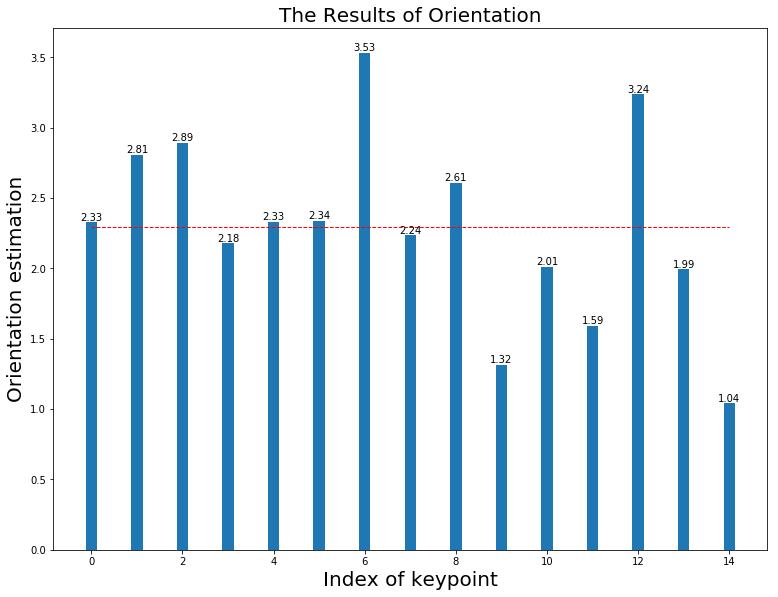

Final result: [     2.3268      2.8088      2.8904      2.1791      2.3294      2.3391      3.5332      2.2356      2.6078      1.3164      2.0119       1.594      3.2383      1.9936      1.0411]
FD Rotate(2.4):mean(2.296), median(2.296) in 0.092
The HoG estimation when (2.4) is  2


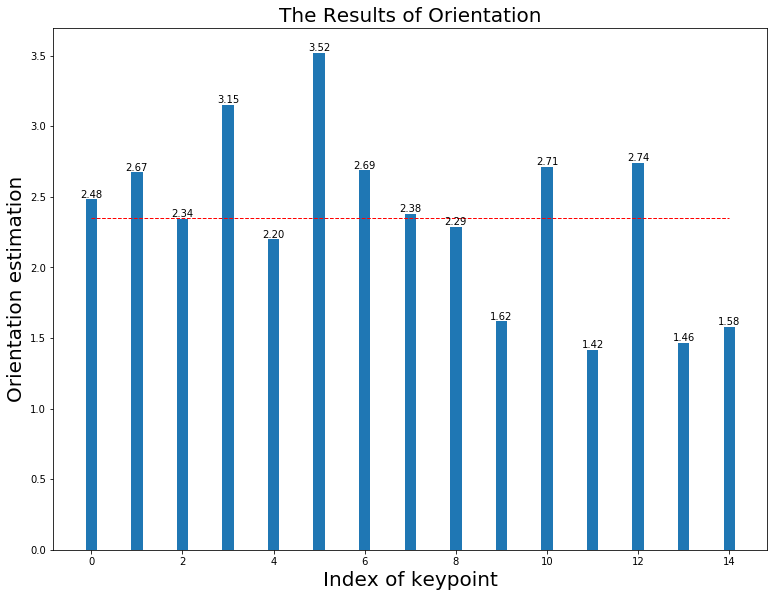

Final result: [     2.4823      2.6718      2.3429      3.1532      2.1989      3.5194      2.6867      2.3795      2.2878      1.6173      2.7123      1.4152      2.7391      1.4647      1.5792]
FD Rotate(2.5):mean(2.350), median(2.350) in 0.105
The HoG estimation when (2.5) is  3


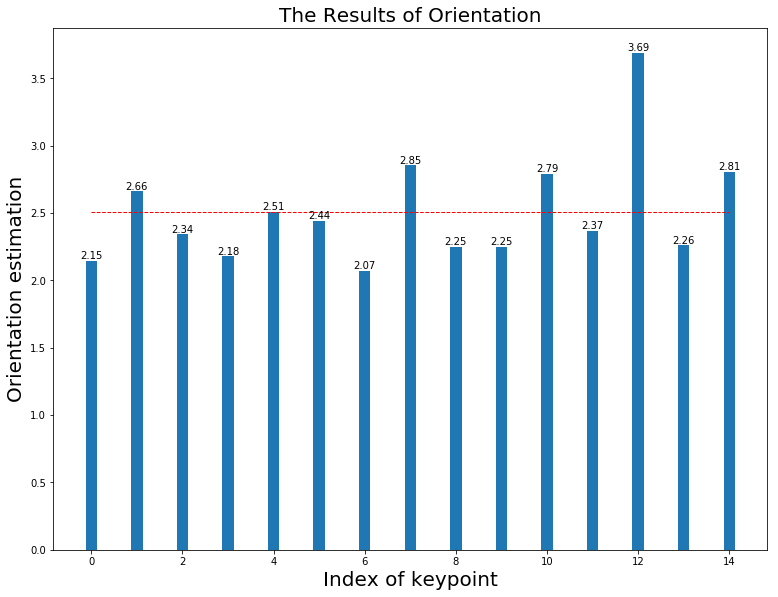

Final result: [     2.1483      2.6617      2.3434      2.1783      2.5082      2.4446      2.0715      2.8549      2.2484      2.2471      2.7942       2.371      3.6908      2.2604      2.8064]
FD Rotate(2.6):mean(2.509), median(2.509) in 0.090
The HoG estimation when (2.6) is  3


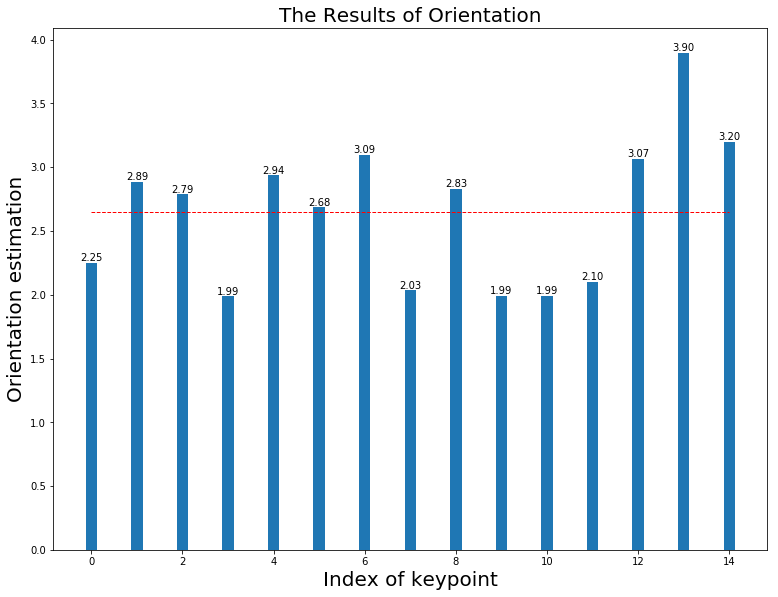

Final result: [     2.2471      2.8852      2.7881      1.9878      2.9359      2.6849      3.0944      2.0342       2.831      1.9934      1.9941      2.1033       3.066      3.8973      3.1963]
FD Rotate(2.7):mean(2.649), median(2.649) in 0.090
The HoG estimation when (2.7) is  3


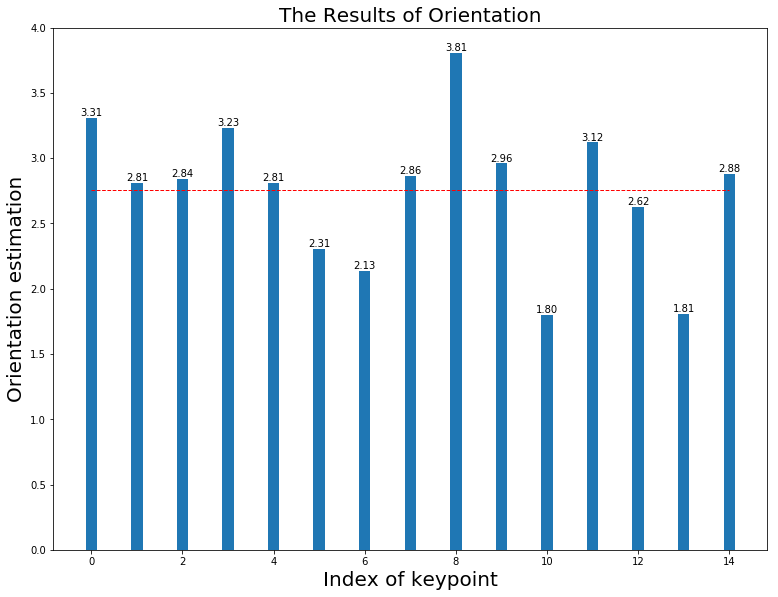

Final result: [     3.3097      2.8107      2.8432      3.2333      2.8101      2.3065      2.1344       2.864      3.8071      2.9605      1.8017      3.1207      2.6241       1.809       2.882]
FD Rotate(2.8):mean(2.754), median(2.754) in 0.089
The HoG estimation when (2.8) is  3


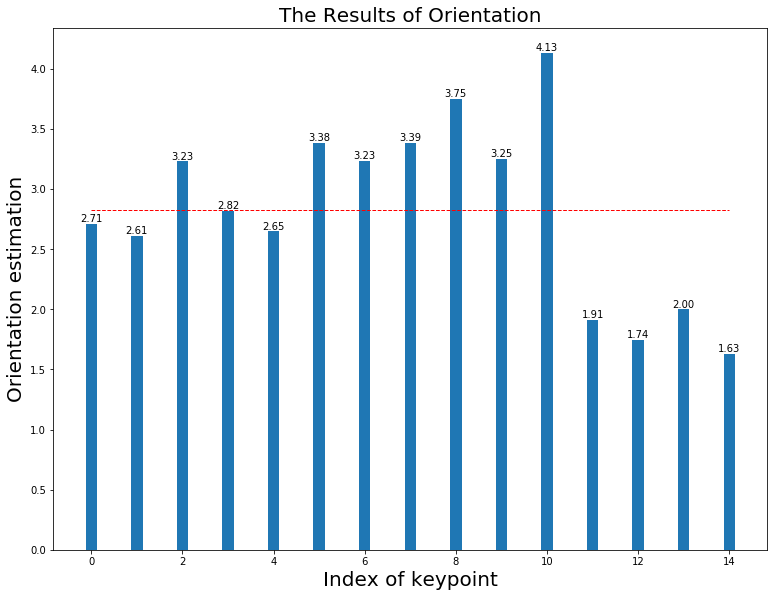

Final result: [      2.711      2.6101      3.2307      2.8171      2.6495      3.3825      3.2324      3.3862      3.7528      3.2547      4.1345      1.9136      1.7433      1.9993      1.6315]
FD Rotate(2.9):mean(2.830), median(2.830) in 0.101
The HoG estimation when (2.9) is  3


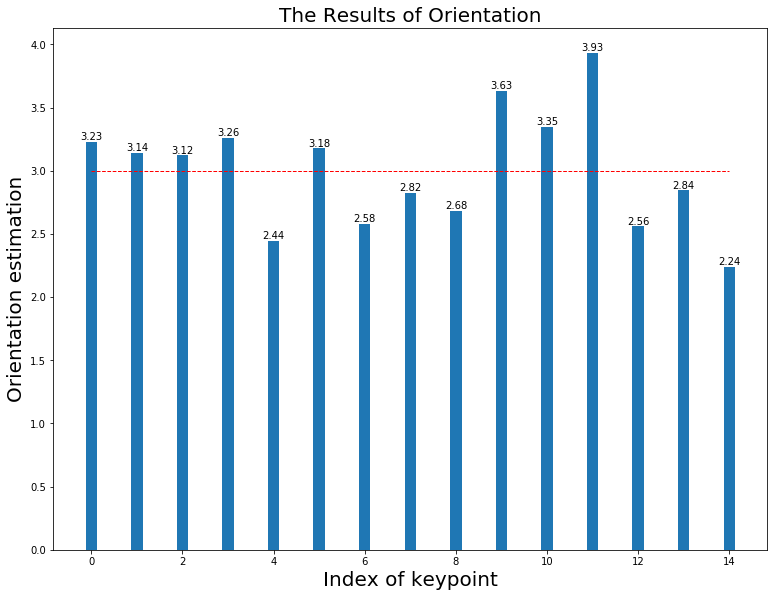

Final result: [      3.226      3.1407      3.1212      3.2591      2.4424       3.177      2.5797      2.8239       2.683      3.6302        3.35      3.9335      2.5594      2.8445      2.2377]
FD Rotate(3.0):mean(3.001), median(3.001) in 0.103
The HoG estimation when (3.0) is  3


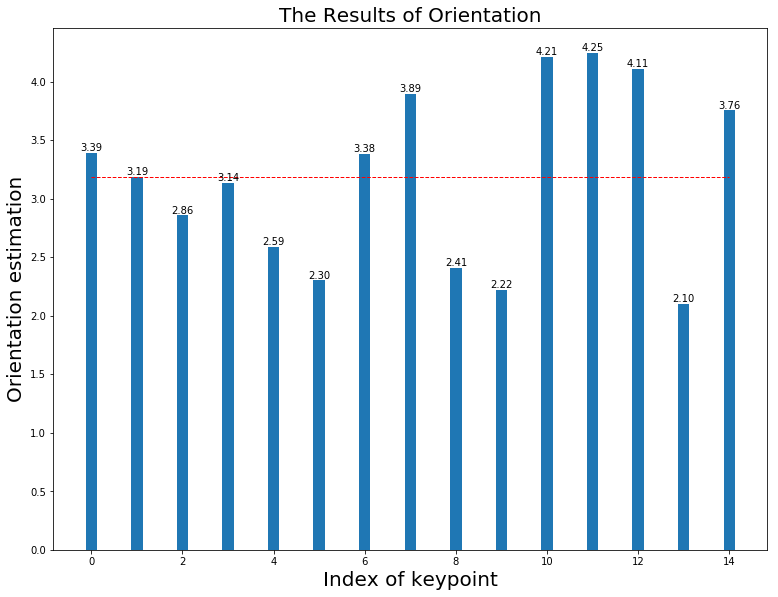

Final result: [     3.3882      3.1857      2.8579      3.1363       2.585      2.3024      3.3833      3.8933      2.4107      2.2207      4.2118      4.2463      4.1097      2.1004      3.7554]
FD Rotate(3.1):mean(3.186), median(3.186) in 0.100
The HoG estimation when (3.1) is  3


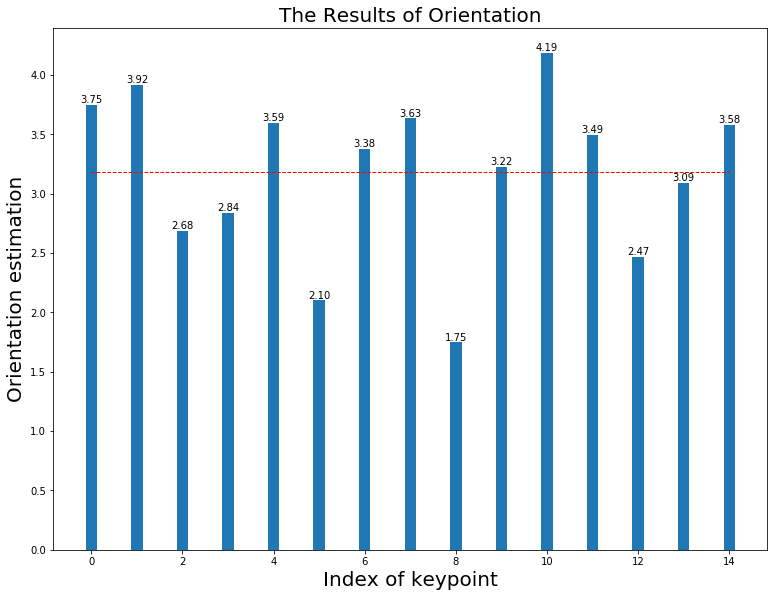

Final result: [     3.7492      3.9185      2.6837      2.8409      3.5948      2.1013      3.3763      3.6338      1.7467      3.2242      4.1864       3.494      2.4705      3.0937      3.5822]
FD Rotate(3.2):mean(3.180), median(3.180) in 0.107
The HoG estimation when (3.2) is  3


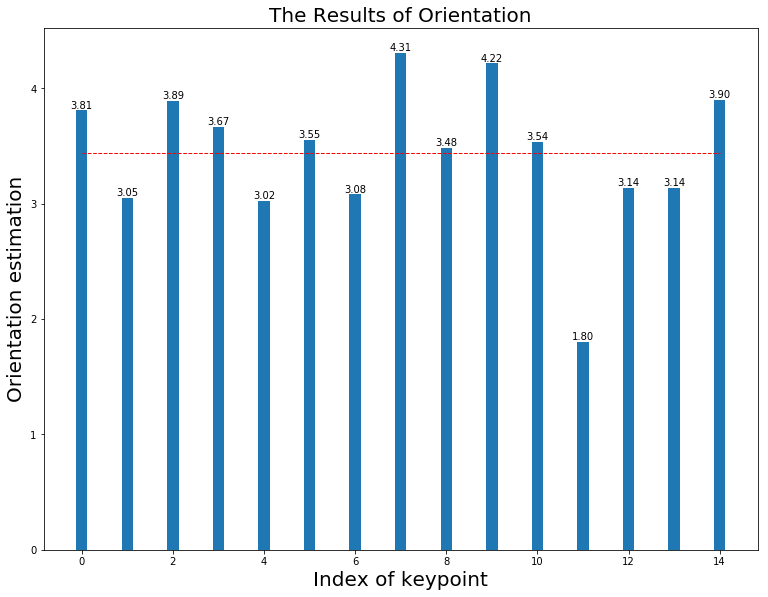

Final result: [     3.8105       3.051      3.8948      3.6688       3.024      3.5537      3.0824      4.3093      3.4831      4.2179      3.5398      1.8033      3.1388      3.1366      3.9023]
FD Rotate(3.3):mean(3.441), median(3.441) in 0.101
The HoG estimation when (3.3) is  3


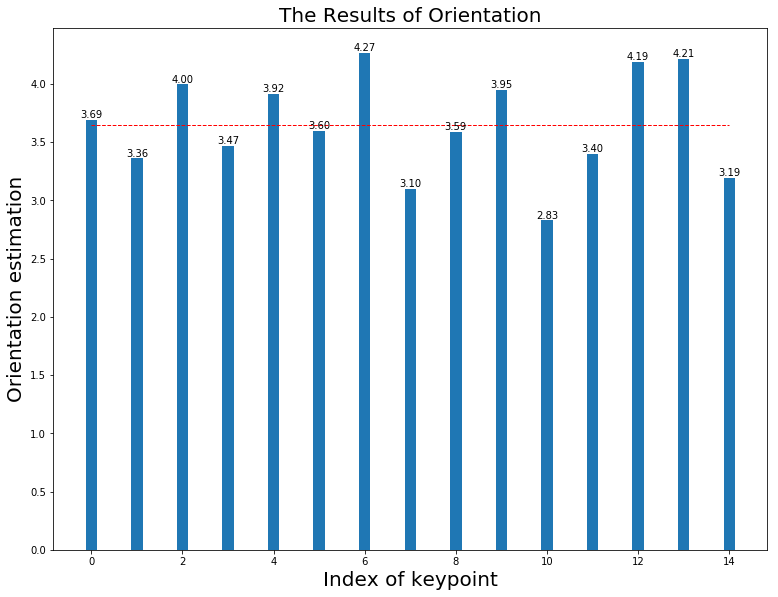

Final result: [     3.6933      3.3606      3.9964      3.4706      3.9157      3.5981      4.2665      3.0964      3.5883      3.9471      2.8269      3.3976      4.1872      4.2124      3.1898]
FD Rotate(3.4):mean(3.650), median(3.650) in 0.089
The HoG estimation when (3.4) is  3


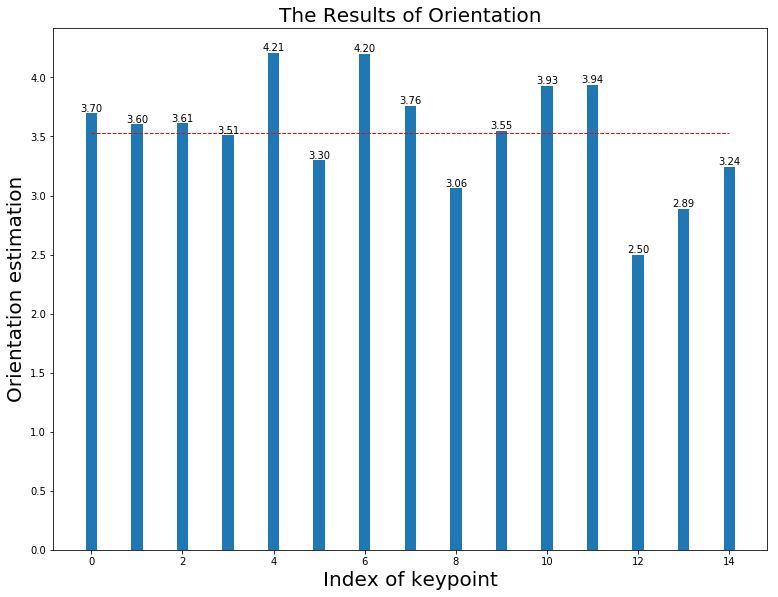

Final result: [     3.6968      3.6016       3.612      3.5093      4.2088      3.2981      4.1971      3.7609      3.0599       3.545      3.9302      3.9373      2.4986      2.8857      3.2401]
FD Rotate(3.5):mean(3.532), median(3.532) in 0.101
The HoG estimation when (3.5) is  3


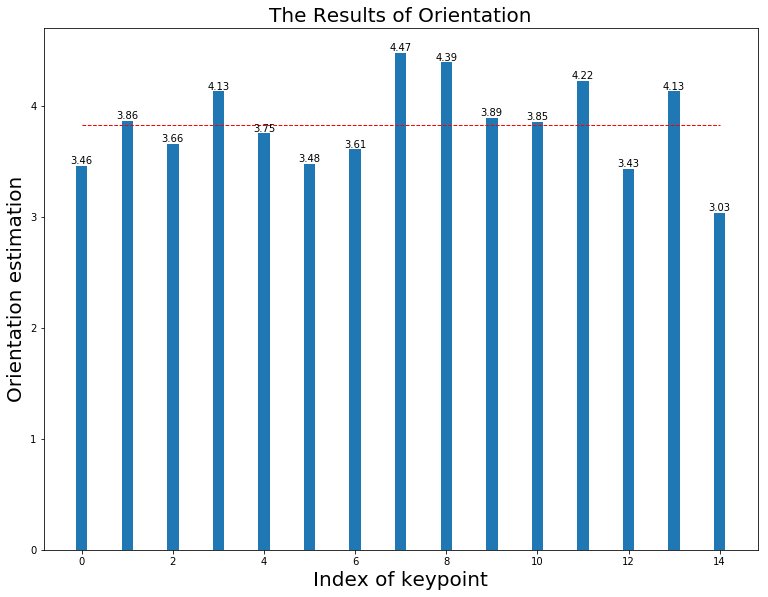

Final result: [     3.4555       3.861      3.6559      4.1273      3.7504      3.4768      3.6053      4.4749      4.3881      3.8911      3.8535      4.2216      3.4311      4.1273      3.0324]
FD Rotate(3.6):mean(3.823), median(3.823) in 0.101
The HoG estimation when (3.6) is  4


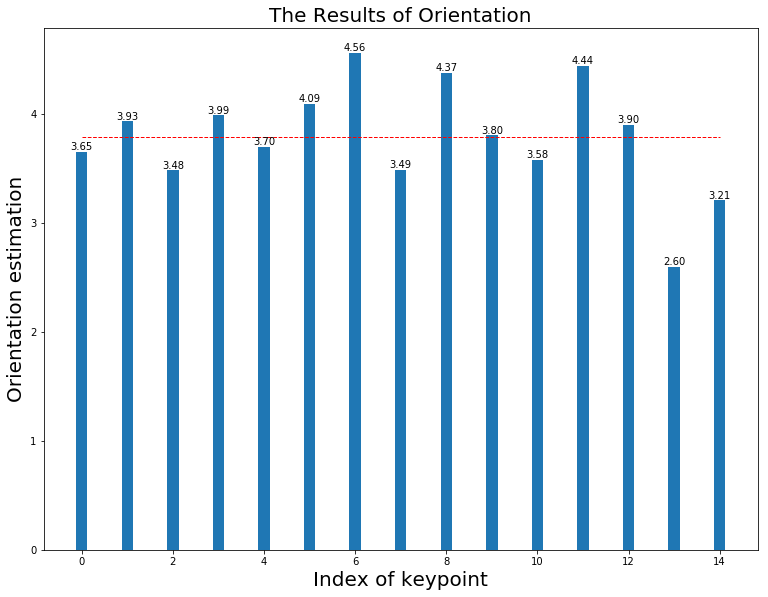

Final result: [     3.6517      3.9301      3.4816      3.9858      3.6981      4.0877      4.5593      3.4859      4.3748      3.8009      3.5764      4.4383      3.8951      2.5951      3.2063]
FD Rotate(3.7):mean(3.784), median(3.784) in 0.102
The HoG estimation when (3.7) is  4


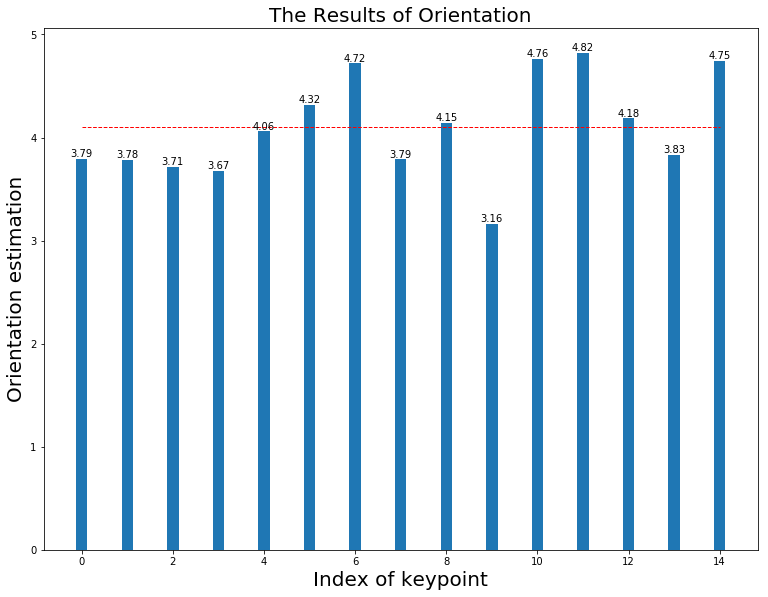

Final result: [     3.7932      3.7805      3.7139      3.6738      4.0592      4.3192      4.7201      3.7887      4.1456      3.1623      4.7597      4.8222      4.1848       3.829      4.7466]
FD Rotate(3.8):mean(4.100), median(4.100) in 0.086
The HoG estimation when (3.8) is  4


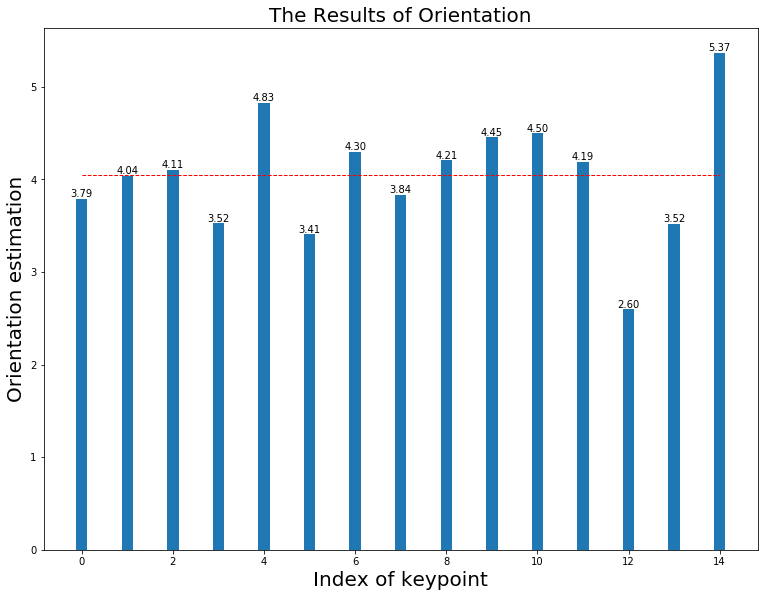

Final result: [     3.7935      4.0372      4.1073      3.5248      4.8283      3.4056      4.3004      3.8358      4.2063      4.4547      4.4967      4.1926      2.5978       3.518      5.3678]
FD Rotate(3.9):mean(4.044), median(4.044) in 0.103
The HoG estimation when (3.9) is  4


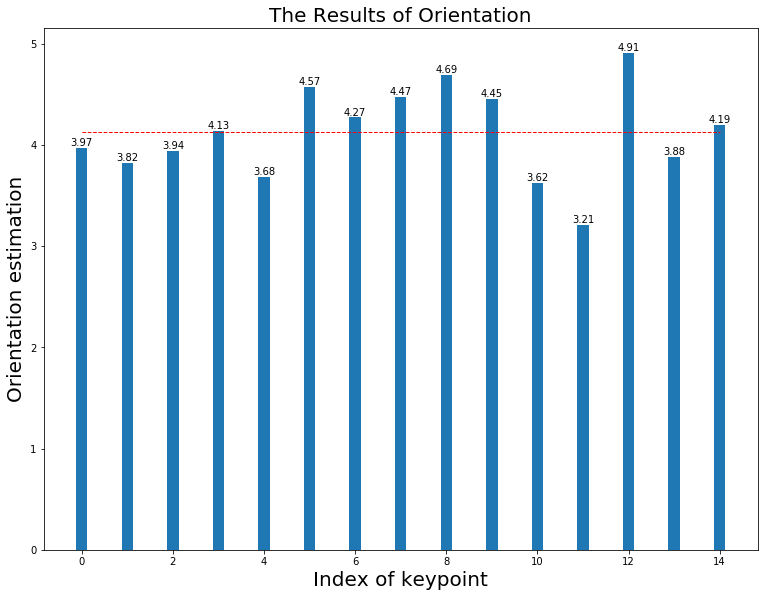

Final result: [     3.9697      3.8223      3.9367      4.1339      3.6825      4.5728      4.2697       4.474      4.6928      4.4534      3.6233      3.2096      4.9082      3.8805      4.1945]
FD Rotate(4.0):mean(4.122), median(4.122) in 0.098
The HoG estimation when (4.0) is  4


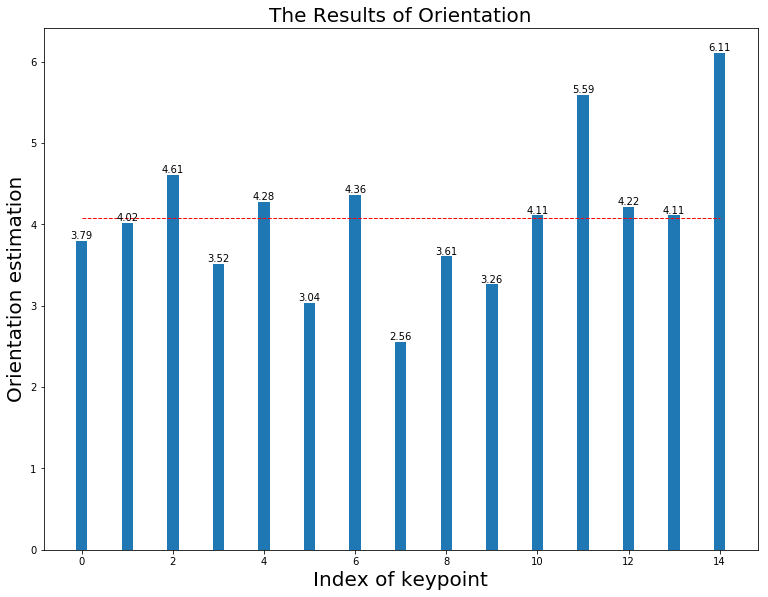

Final result: [      3.793      4.0165        4.61      3.5183      4.2764      3.0383      4.3583      2.5594      3.6063       3.263      4.1095      5.5887      4.2155      4.1094      6.1082]
FD Rotate(4.1):mean(4.078), median(4.078) in 0.101
The HoG estimation when (4.1) is  4


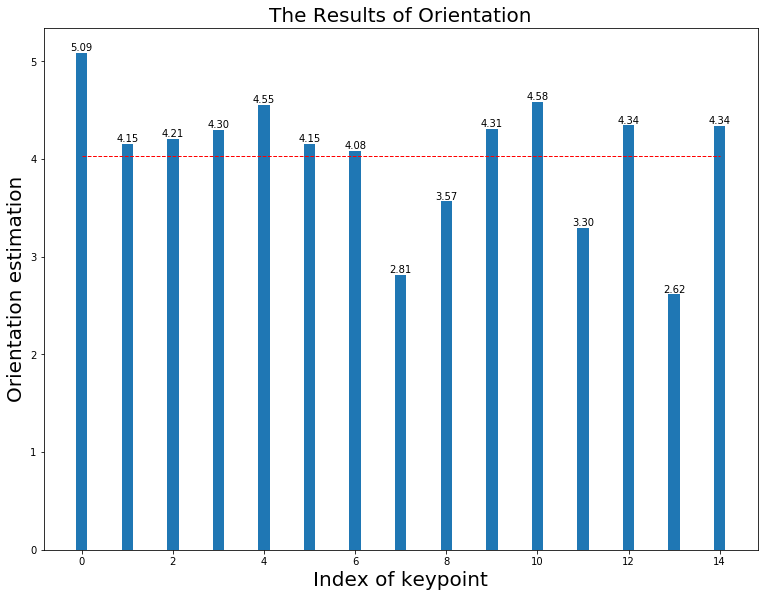

Final result: [      5.087       4.152      4.2089      4.2956      4.5523      4.1543      4.0817      2.8146      3.5664      4.3115      4.5816      3.2971      4.3435      2.6155      4.3385]
FD Rotate(4.2):mean(4.027), median(4.027) in 0.101
The HoG estimation when (4.2) is  4


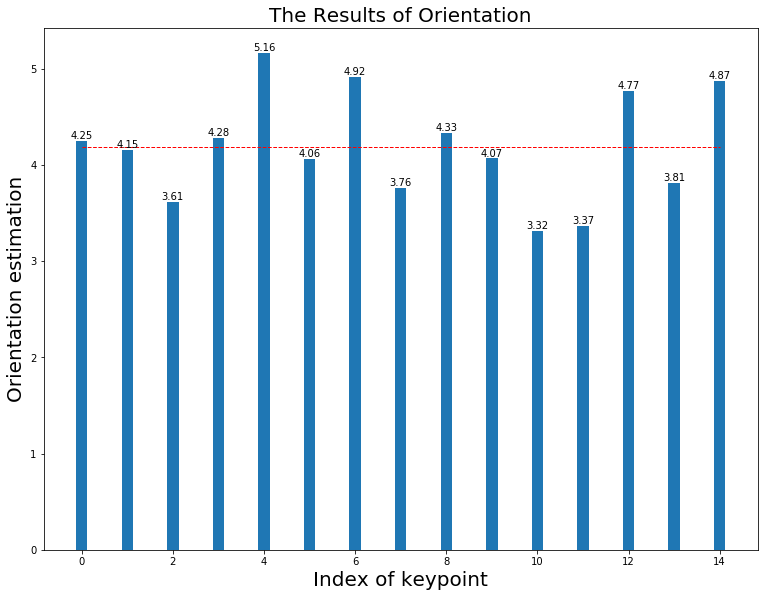

Final result: [     4.2488      4.1543      3.6125      4.2816      5.1635      4.0648      4.9158      3.7593      4.3326       4.066      3.3164      3.3689      4.7717      3.8094       4.873]
FD Rotate(4.3):mean(4.183), median(4.183) in 0.100
The HoG estimation when (4.3) is  4


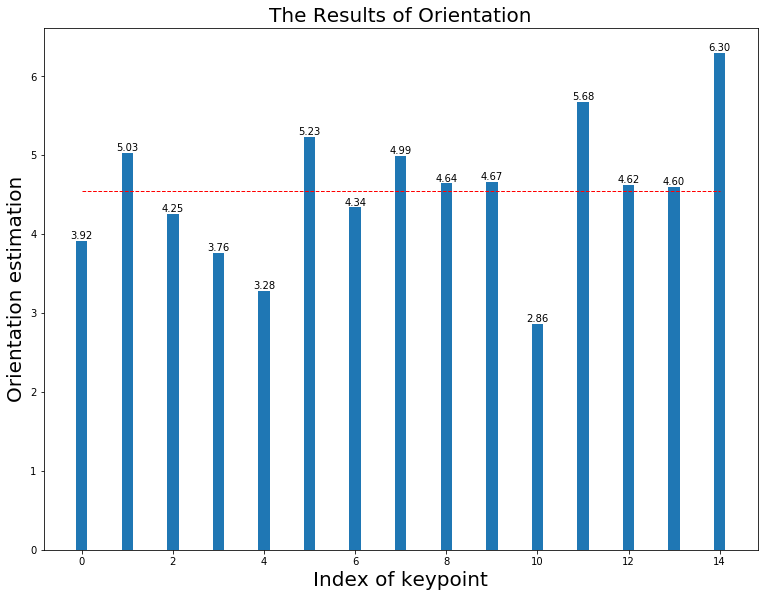

Final result: [     3.9166      5.0329      4.2538      3.7589      3.2787      5.2324      4.3382      4.9891      4.6415      4.6656       2.859      5.6761      4.6218      4.6009      6.2974]
FD Rotate(4.4):mean(4.544), median(4.544) in 0.100
The HoG estimation when (4.4) is  5


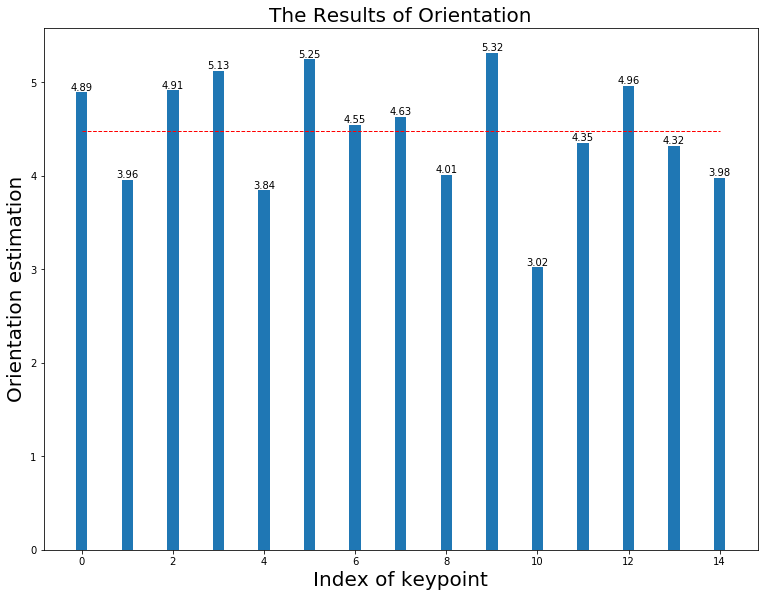

Final result: [      4.893      3.9557      4.9141       5.126      3.8435      5.2463      4.5477      4.6321       4.011      5.3165      3.0206      4.3529      4.9621      4.3238      3.9762]
FD Rotate(4.5):mean(4.475), median(4.475) in 0.093
The HoG estimation when (4.5) is  5


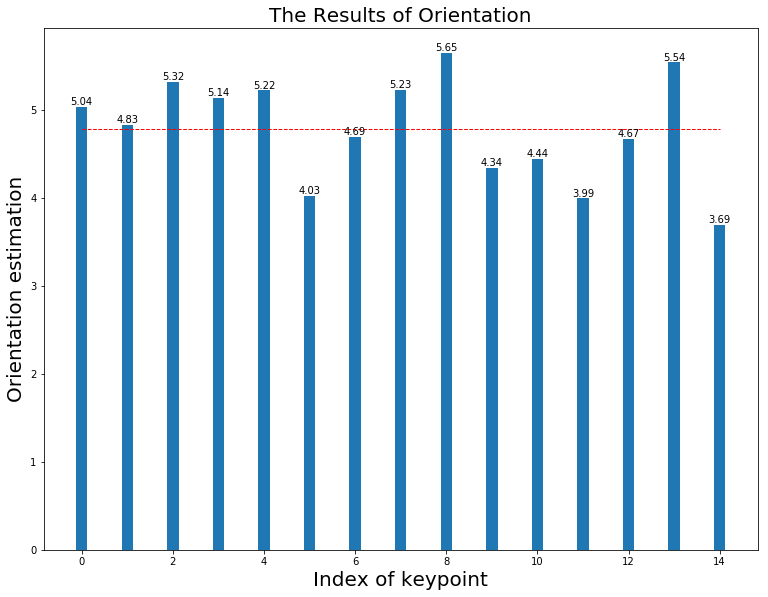

Final result: [     5.0373      4.8328        5.32      5.1362      5.2227      4.0271      4.6939      5.2298      5.6504      4.3439      4.4437       3.994      4.6731      5.5401      3.6938]
FD Rotate(4.6):mean(4.789), median(4.789) in 0.115
The HoG estimation when (4.6) is  5


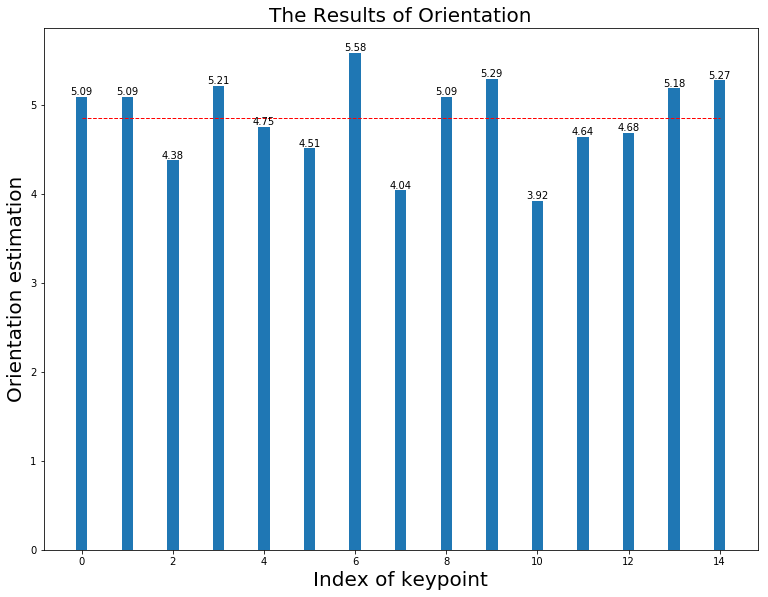

Final result: [      5.088       5.088      4.3754      5.2129      4.7541      4.5088      5.5824      4.0381      5.0882      5.2908      3.9175      4.6367      4.6807      5.1842      5.2725]
FD Rotate(4.7):mean(4.848), median(4.848) in 0.102
The HoG estimation when (4.7) is  5


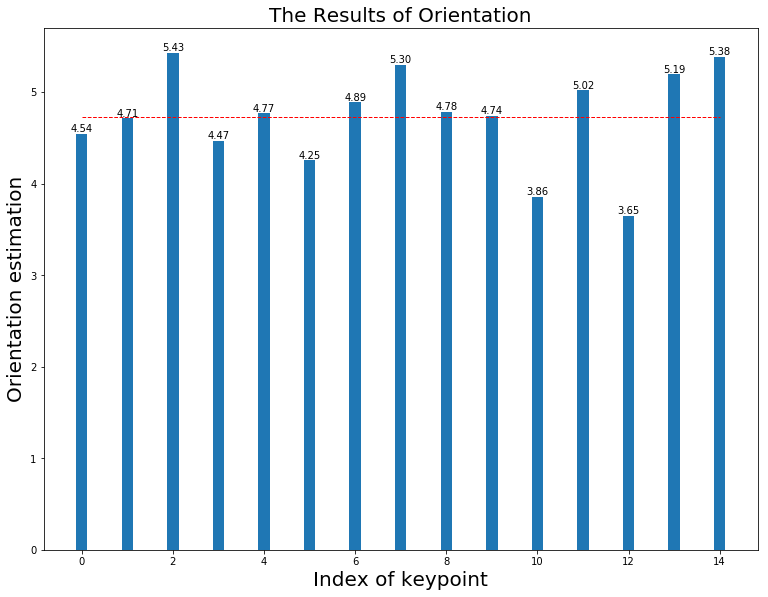

Final result: [     4.5438      4.7132       5.431      4.4679      4.7695      4.2546      4.8902      5.3021      4.7827      4.7408      3.8602       5.019      3.6482      5.1941      5.3845]
FD Rotate(4.8):mean(4.733), median(4.733) in 0.104
The HoG estimation when (4.8) is  5


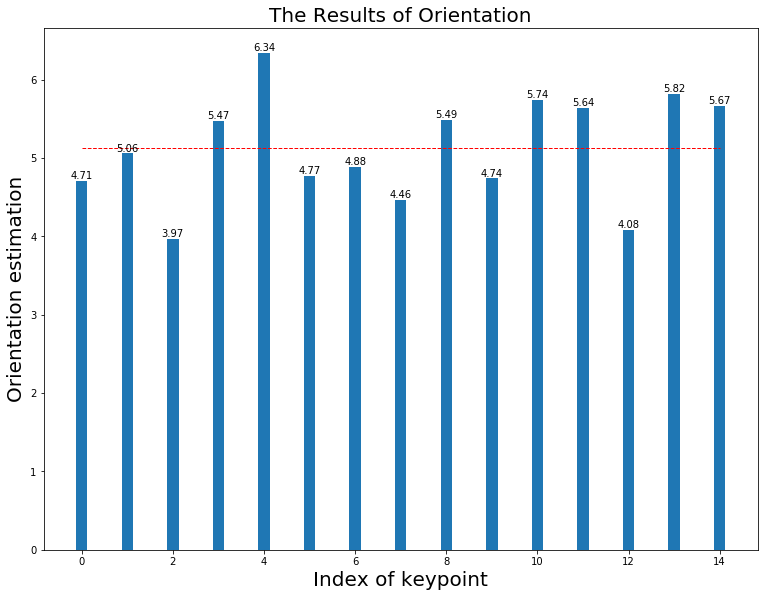

Final result: [     4.7094      5.0588        3.97      5.4739      6.3408      4.7731      4.8817      4.4608      5.4858      4.7397      5.7378      5.6389      4.0789      5.8182      5.6665]
FD Rotate(4.9):mean(5.122), median(5.122) in 0.104
The HoG estimation when (4.9) is  5


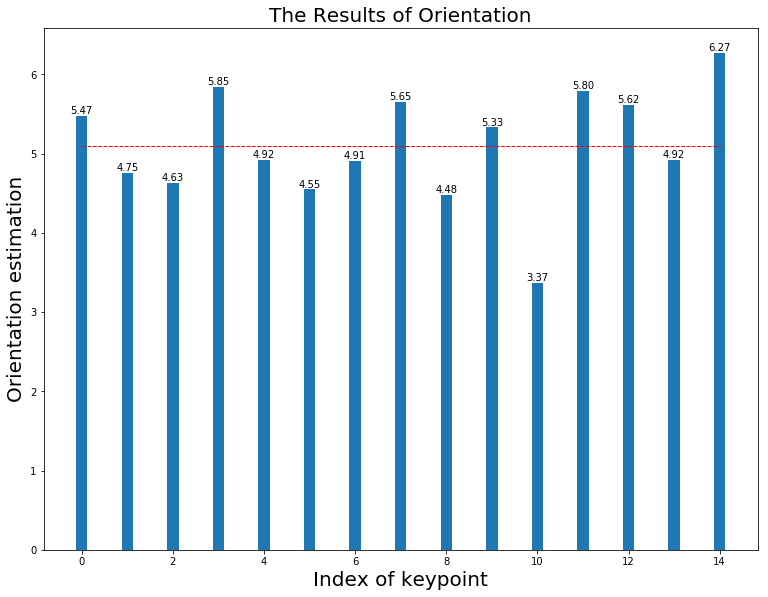

Final result: [     5.4724      4.7548      4.6284      5.8466      4.9191      4.5496      4.9104      5.6511      4.4805      5.3319      3.3675      5.7964      5.6203      4.9175      6.2732]
FD Rotate(5.0):mean(5.101), median(5.101) in 0.104
The HoG estimation when (5.0) is  5


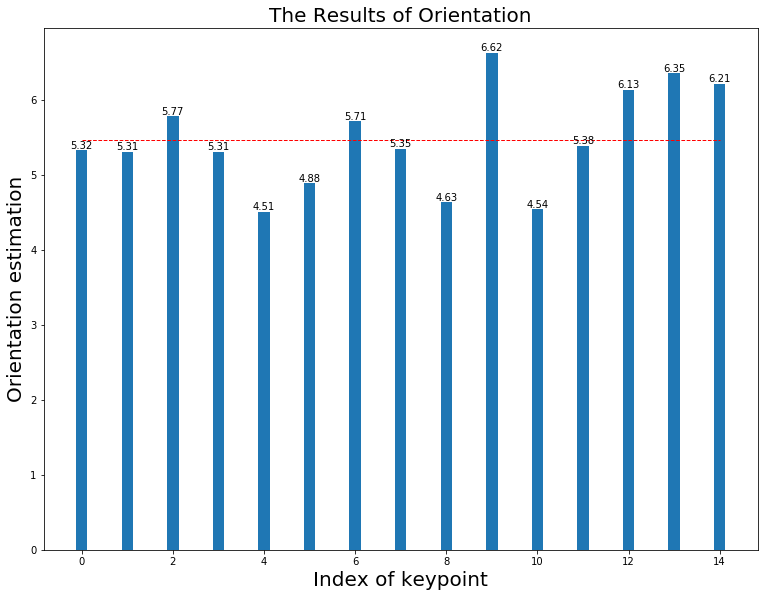

Final result: [      5.323      5.3073      5.7749      5.3069      4.5054      4.8848      5.7079      5.3466      4.6288      6.6234      4.5368      5.3818      6.1267      6.3506      6.2085]
FD Rotate(5.1):mean(5.468), median(5.468) in 0.091
The HoG estimation when (5.1) is  5


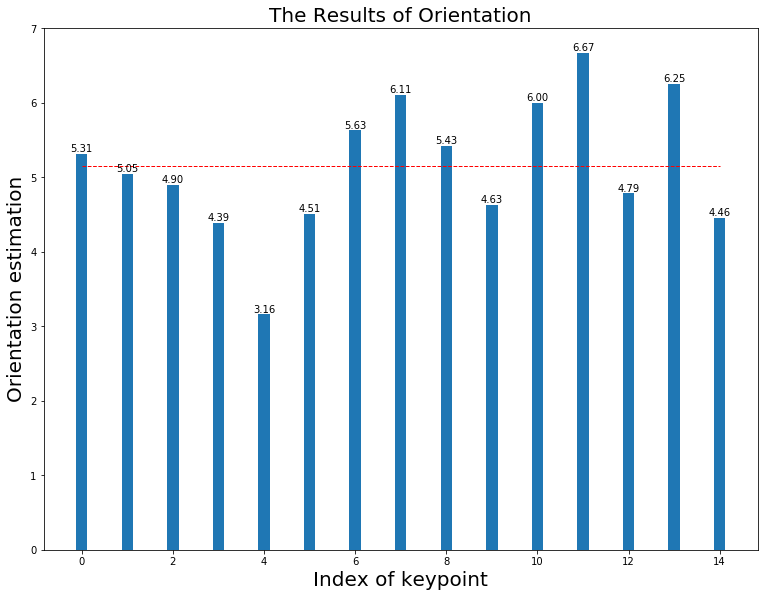

Final result: [     5.3133      5.0472      4.8978       4.392      3.1626      4.5137      5.6316      6.1122      5.4279      4.6277      5.9972       6.673      4.7864      6.2513      4.4556]
FD Rotate(5.2):mean(5.153), median(5.153) in 0.093
The HoG estimation when (5.2) is  5


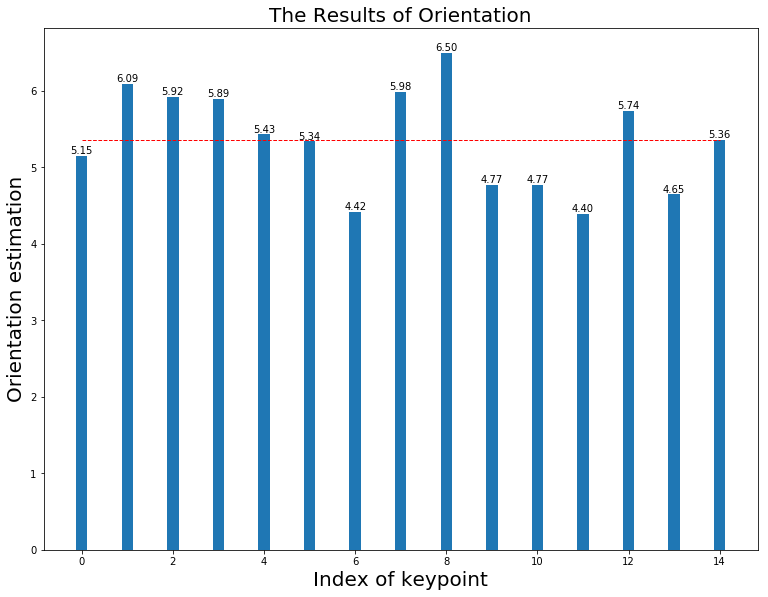

Final result: [     5.1492      6.0924      5.9203      5.8945      5.4333      5.3405      4.4153      5.9842      6.4991      4.7682      4.7736      4.3972      5.7428      4.6484      5.3611]
FD Rotate(5.3):mean(5.361), median(5.361) in 0.103
The HoG estimation when (5.3) is  5


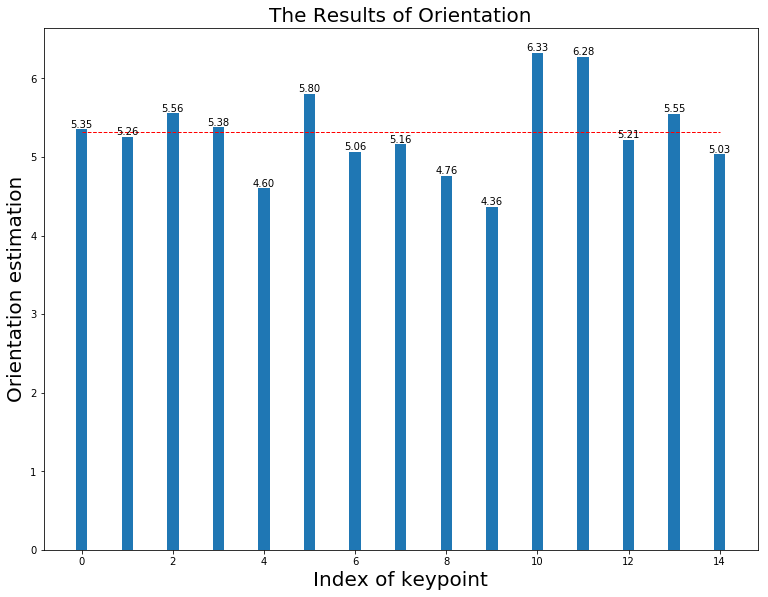

Final result: [     5.3529      5.2588      5.5556      5.3766      4.6019      5.8044      5.0621      5.1615      4.7641      4.3636      6.3268      6.2788      5.2141      5.5521      5.0343]
FD Rotate(5.4):mean(5.314), median(5.314) in 0.100
The HoG estimation when (5.4) is  5


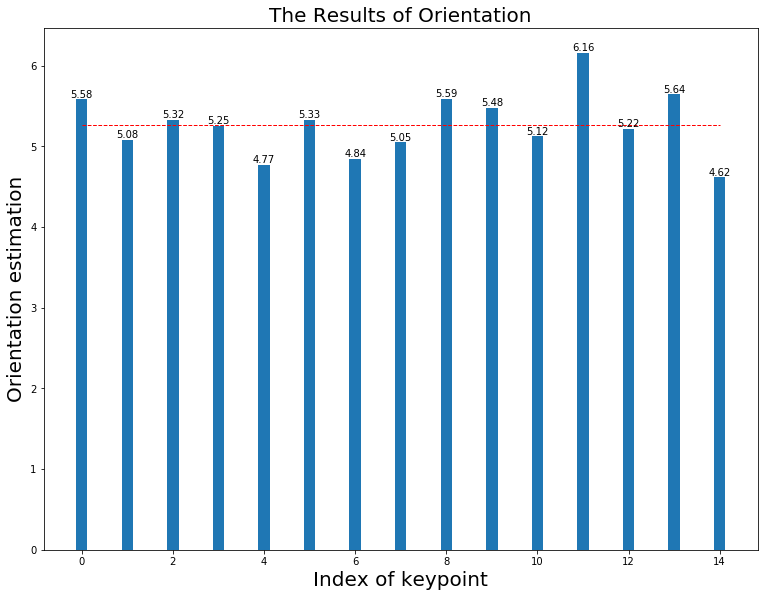

Final result: [     5.5833      5.0844      5.3238      5.2496      4.7734      5.3302      4.8399       5.048      5.5857      5.4792      5.1218      6.1591      5.2155      5.6423      4.6165]
FD Rotate(5.5):mean(5.270), median(5.270) in 0.100
The HoG estimation when (5.5) is  6


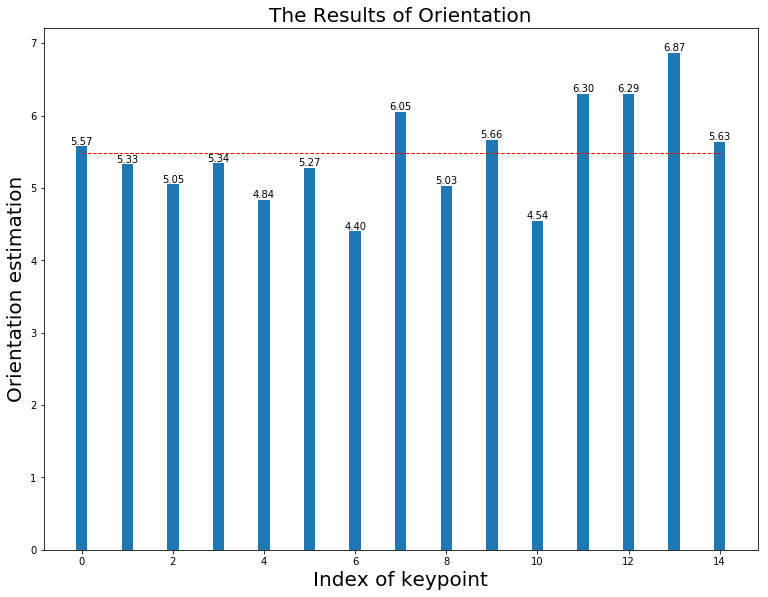

Final result: [     5.5747      5.3255      5.0485      5.3394      4.8377      5.2727      4.4009      6.0488      5.0251      5.6609      4.5439      6.3006      6.2946       6.867       5.634]
FD Rotate(5.6):mean(5.478), median(5.478) in 0.092
The HoG estimation when (5.6) is  6


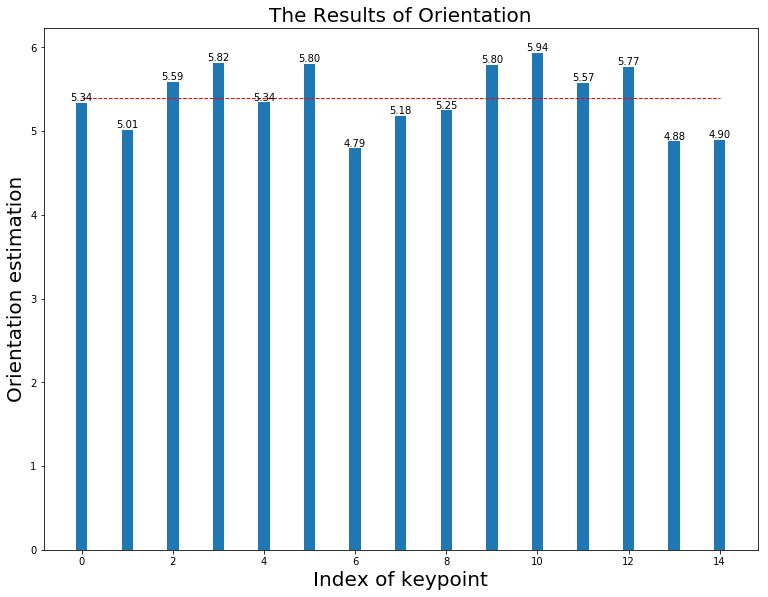

Final result: [     5.3371      5.0147       5.589      5.8196      5.3435      5.8042      4.7946      5.1787        5.25      5.7958      5.9363      5.5746       5.771      4.8786      4.8973]
FD Rotate(5.7):mean(5.399), median(5.399) in 0.097
The HoG estimation when (5.7) is  6


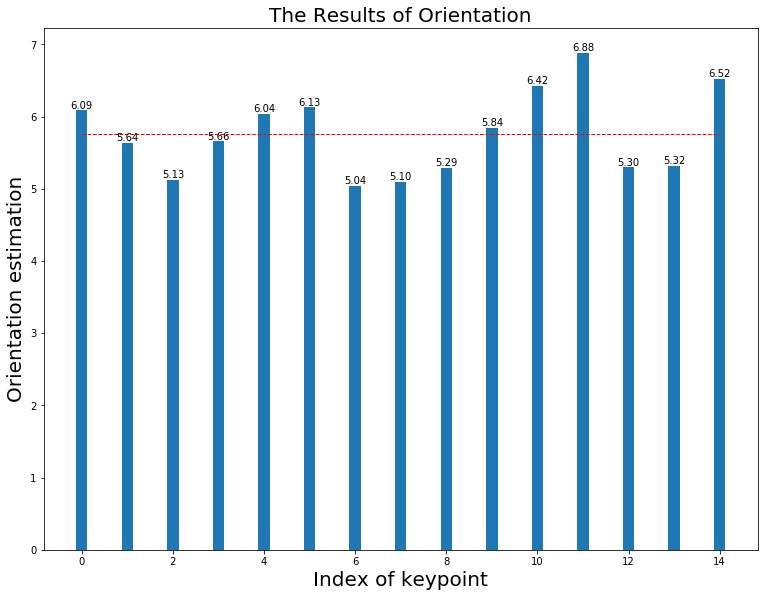

Final result: [     6.0854      5.6385      5.1272      5.6568      6.0367      6.1281      5.0426       5.095      5.2872      5.8418      6.4205      6.8832      5.2962      5.3153      6.5186]
FD Rotate(5.8):mean(5.758), median(5.758) in 0.085
The HoG estimation when (5.8) is  6


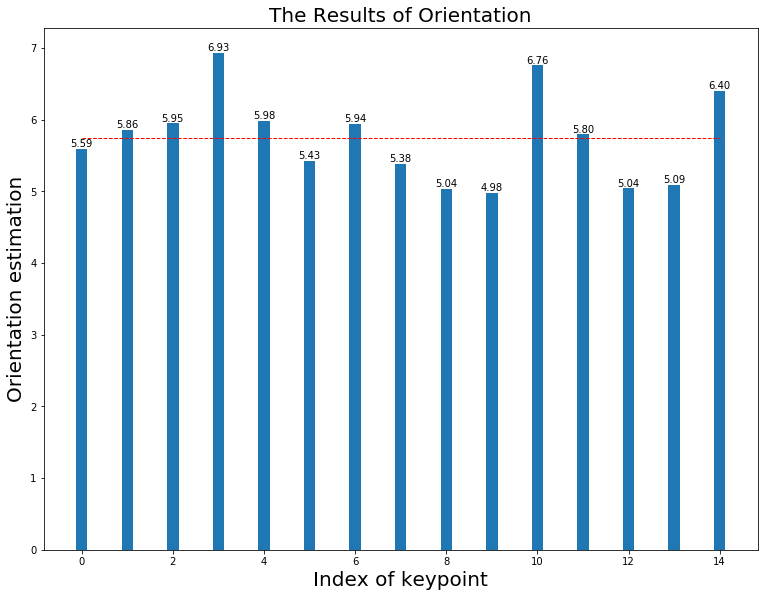

Final result: [     5.5909      5.8608      5.9473      6.9322      5.9842      5.4282      5.9356      5.3821      5.0392      4.9763      6.7574      5.7953      5.0409      5.0938      6.3978]
FD Rotate(5.9):mean(5.744), median(5.744) in 0.101
The HoG estimation when (5.9) is  6


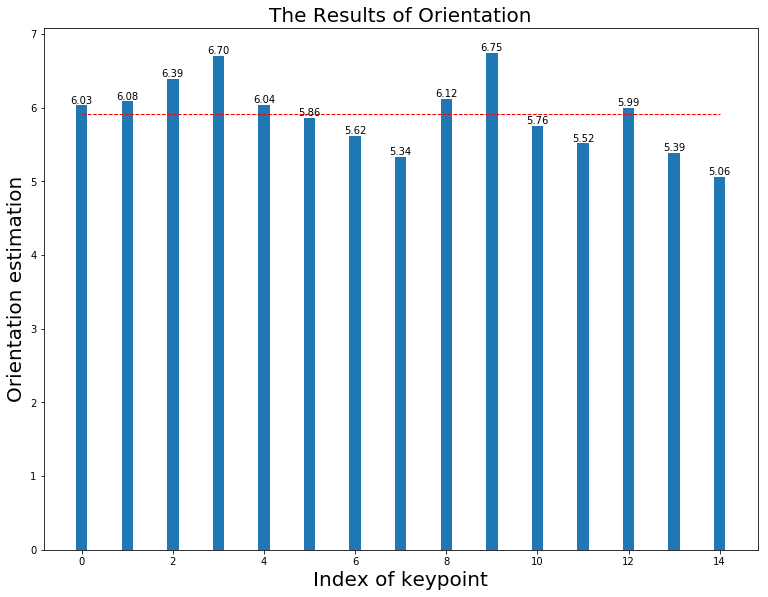

Final result: [      6.033      6.0844      6.3905      6.6997      6.0395      5.8636      5.6172      5.3372      6.1212      6.7453       5.756      5.5159      5.9932      5.3859      5.0627]
FD Rotate(6.0):mean(5.910), median(5.910) in 0.088
The HoG estimation when (6.0) is  6


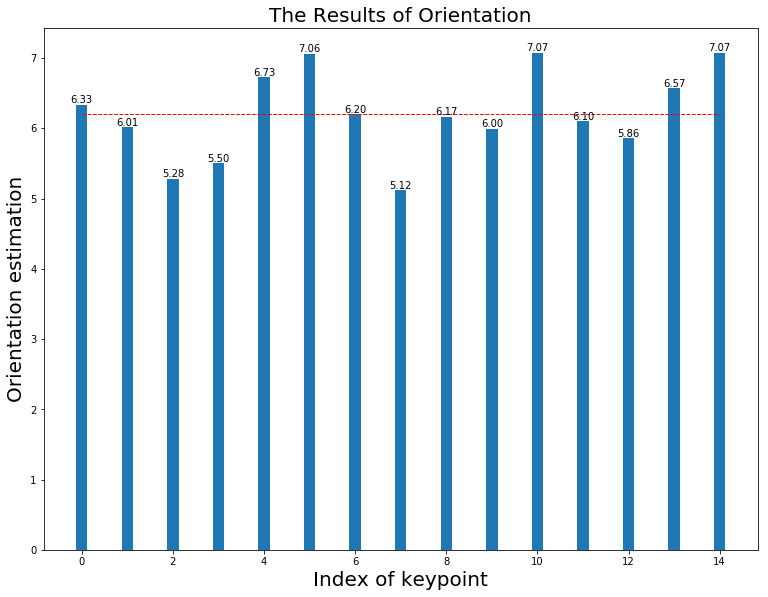

Final result: [     6.3314      6.0118      5.2843      5.5017      6.7256      7.0611      6.1958      5.1151      6.1655      5.9961      7.0736      6.0963      5.8556      6.5666      7.0739]
FD Rotate(6.1):mean(6.204), median(6.204) in 0.090
The HoG estimation when (6.1) is  6


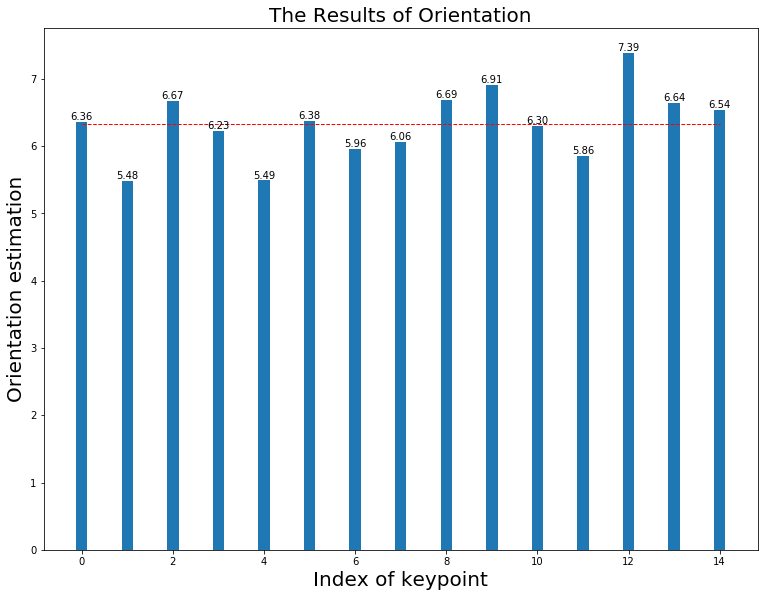

Final result: [     6.3602      5.4825      6.6693      6.2317      5.4898      6.3758      5.9568       6.062      6.6895      6.9121      6.3021      5.8585      7.3868      6.6375      6.5356]
FD Rotate(6.2):mean(6.330), median(6.330) in 0.089
The HoG estimation when (6.2) is  6


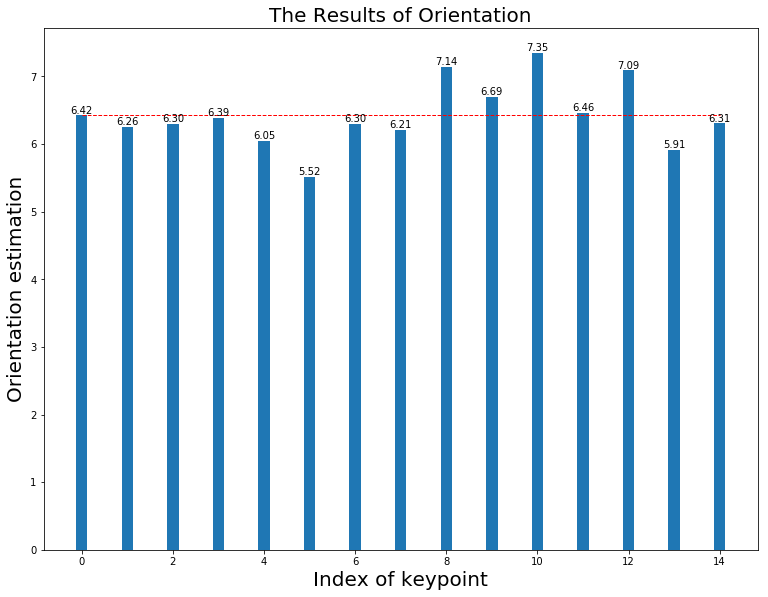

Final result: [     6.4231      6.2574      6.2968      6.3884      6.0497      5.5188      6.3011      6.2116      7.1448      6.6923      7.3489      6.4589      7.0899       5.911      6.3059]
FD Rotate(6.3):mean(6.427), median(6.427) in 0.105
The HoG estimation when (6.3) is  6


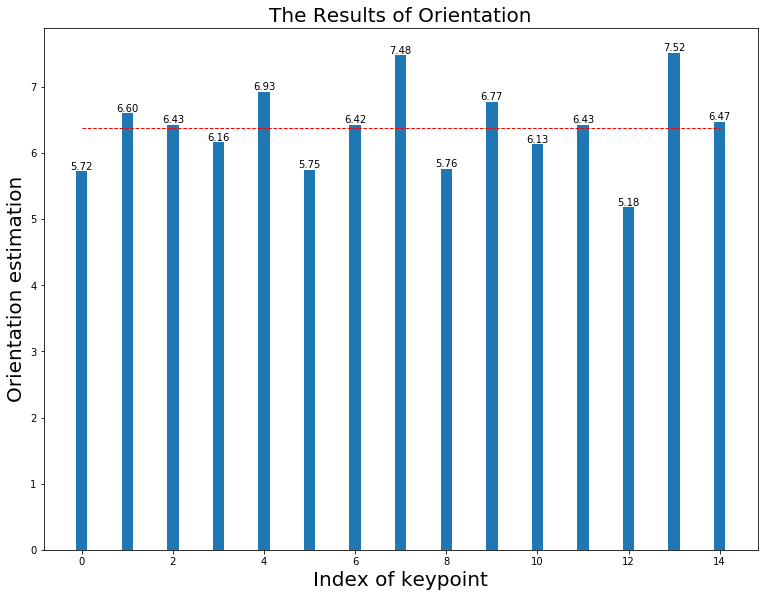

Final result: [     5.7212      6.5973      6.4285      6.1614      6.9271      5.7467      6.4214      7.4781      5.7558      6.7698      6.1298      6.4274      5.1784      7.5152      6.4742]
FD Rotate(6.4):mean(6.382), median(6.382) in 0.102
The HoG estimation when (6.4) is  6


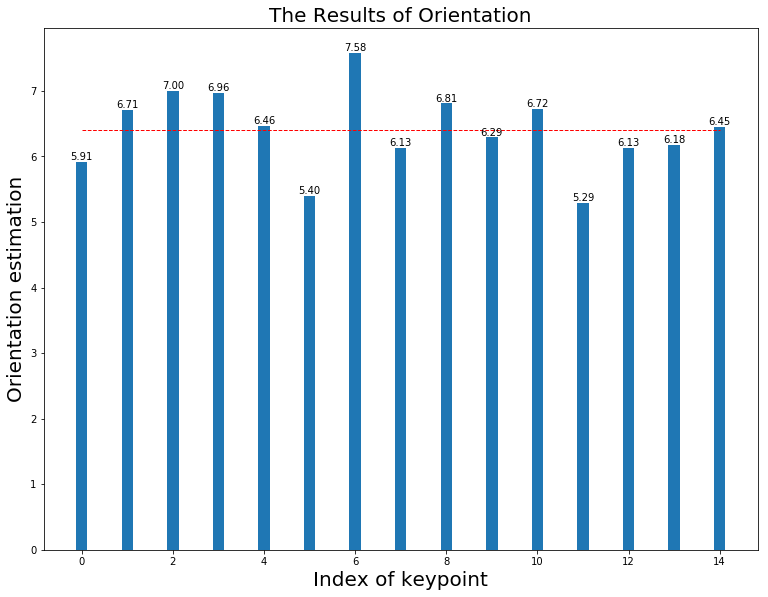

Final result: [     5.9145      6.7147      6.9954      6.9645      6.4633      5.3969      7.5804      6.1279      6.8105      6.2901       6.723      5.2868       6.131      6.1752      6.4492]
FD Rotate(6.5):mean(6.402), median(6.402) in 0.103
The HoG estimation when (6.5) is  7


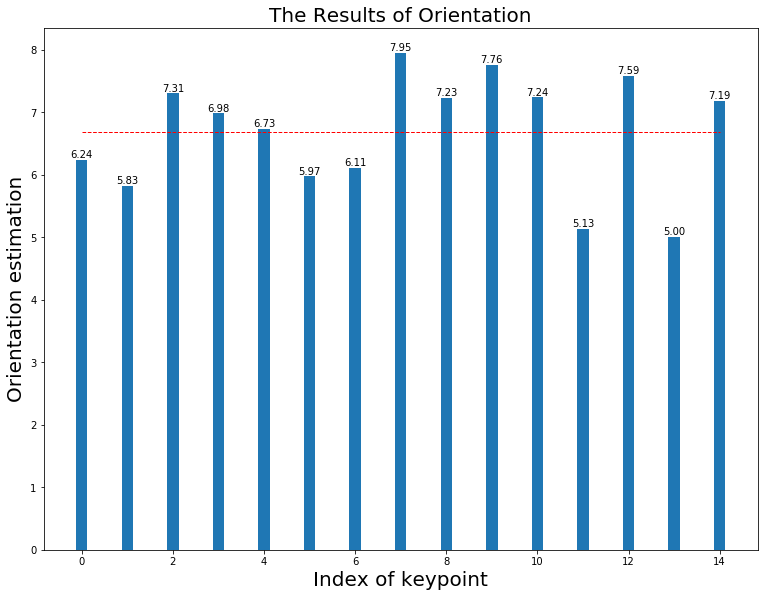

Final result: [     6.2351      5.8294      7.3063      6.9845      6.7339      5.9744      6.1096      7.9538      7.2329      7.7615       7.239      5.1318      7.5864      5.0024      7.1874]
FD Rotate(6.6):mean(6.685), median(6.685) in 0.102
The HoG estimation when (6.6) is  7


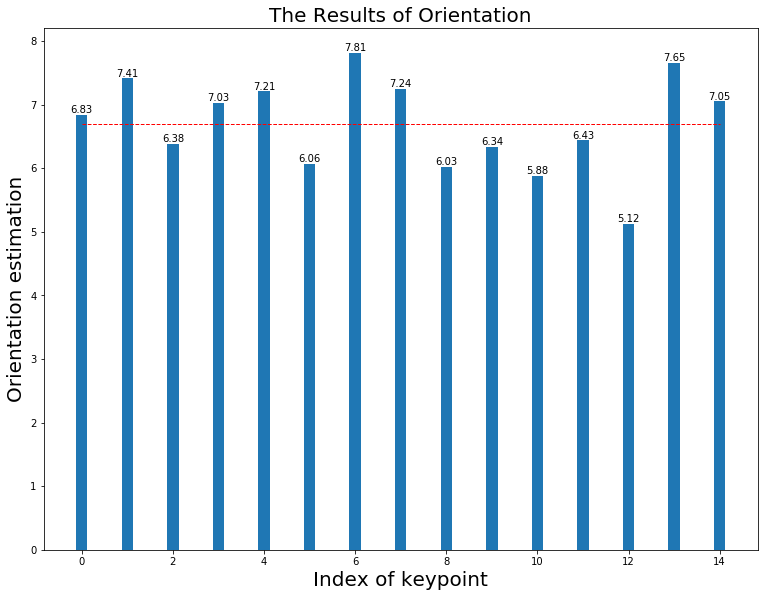

Final result: [     6.8348      7.4106      6.3784       7.029       7.208      6.0637      7.8131      7.2419      6.0253      6.3385      5.8784      6.4346      5.1226      7.6546      7.0476]
FD Rotate(6.7):mean(6.699), median(6.699) in 0.095
The HoG estimation when (6.7) is  7


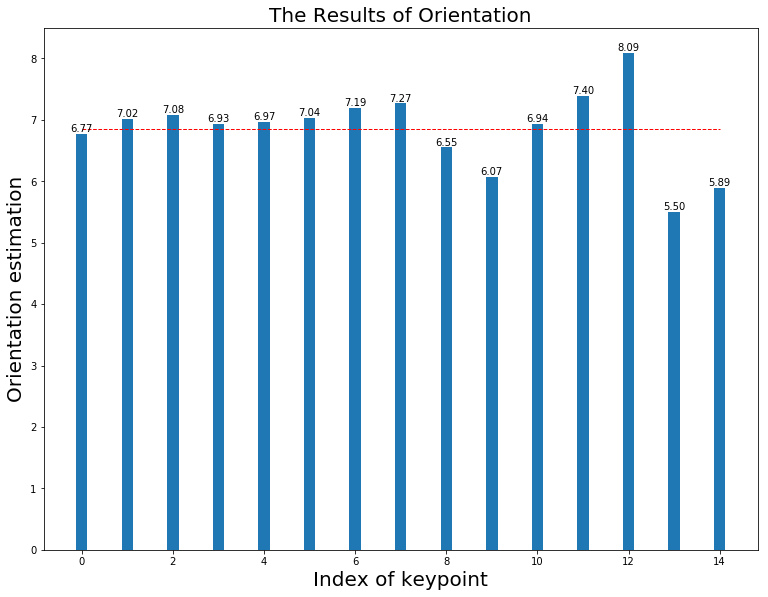

Final result: [     6.7693      7.0171      7.0804       6.932      6.9721      7.0385      7.1905      7.2673       6.554      6.0749      6.9368      7.3963      8.0926      5.4964      5.8926]
FD Rotate(6.8):mean(6.847), median(6.847) in 0.101
The HoG estimation when (6.8) is  7


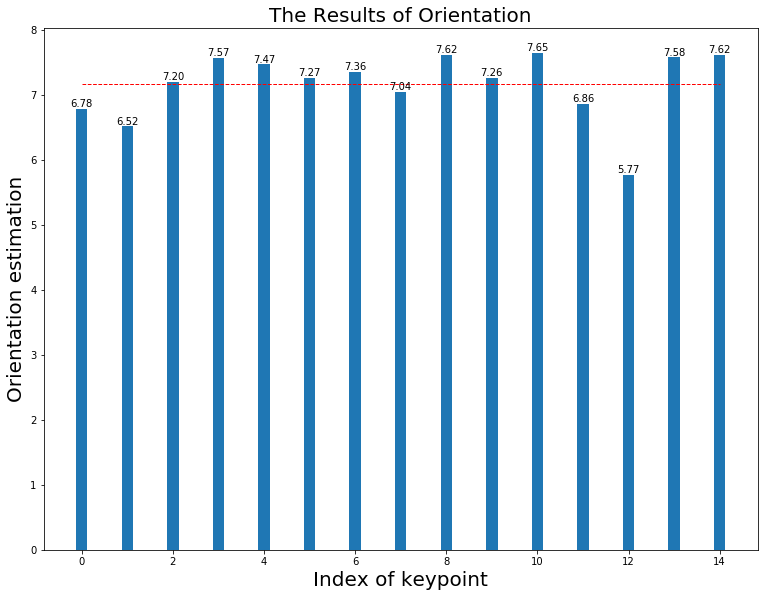

Final result: [     6.7825      6.5174      7.1987      7.5708      7.4689      7.2669      7.3573      7.0442      7.6199      7.2648       7.649      6.8611      5.7717      7.5767      7.6215]
FD Rotate(6.9):mean(7.171), median(7.171) in 0.111
The HoG estimation when (6.9) is  7


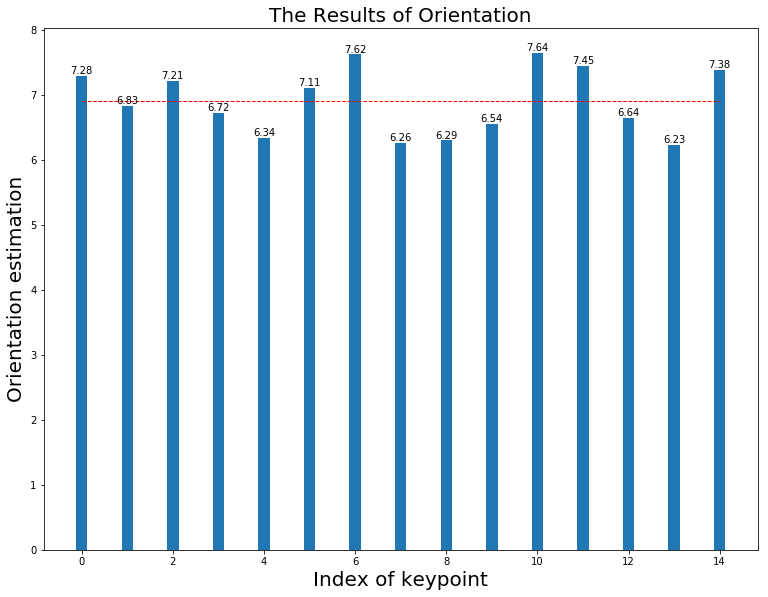

Final result: [     7.2833       6.825      7.2105      6.7158      6.3379      7.1089      7.6177      6.2557      6.2948      6.5448      7.6436      7.4467      6.6375      6.2259      7.3756]
FD Rotate(7.0):mean(6.902), median(6.902) in 0.105
The HoG estimation when (7.0) is  7


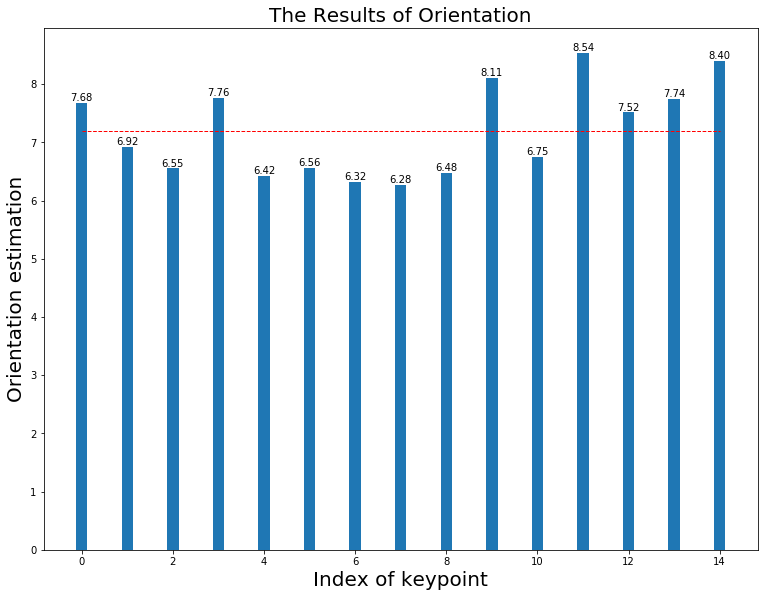

Final result: [     7.6789       6.922      6.5507      7.7633      6.4175      6.5641      6.3206      6.2751      6.4787      8.1089      6.7545      8.5376      7.5159      7.7413      8.4006]
FD Rotate(7.1):mean(7.202), median(7.202) in 0.113
The HoG estimation when (7.1) is  7


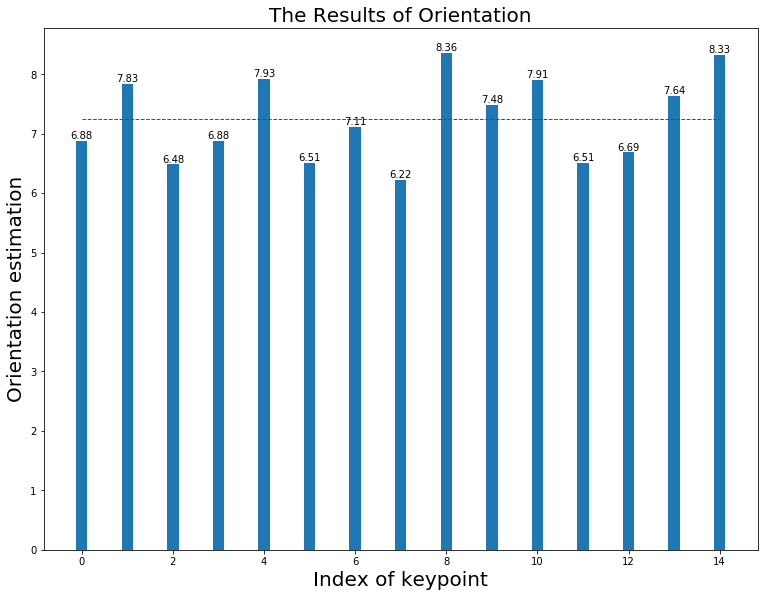

Final result: [     6.8834       7.832      6.4822      6.8765      7.9274      6.5096      7.1127      6.2214       8.361       7.482      7.9086      6.5082       6.686      7.6355      8.3289]
FD Rotate(7.2):mean(7.250), median(7.250) in 0.098
The HoG estimation when (7.2) is  7


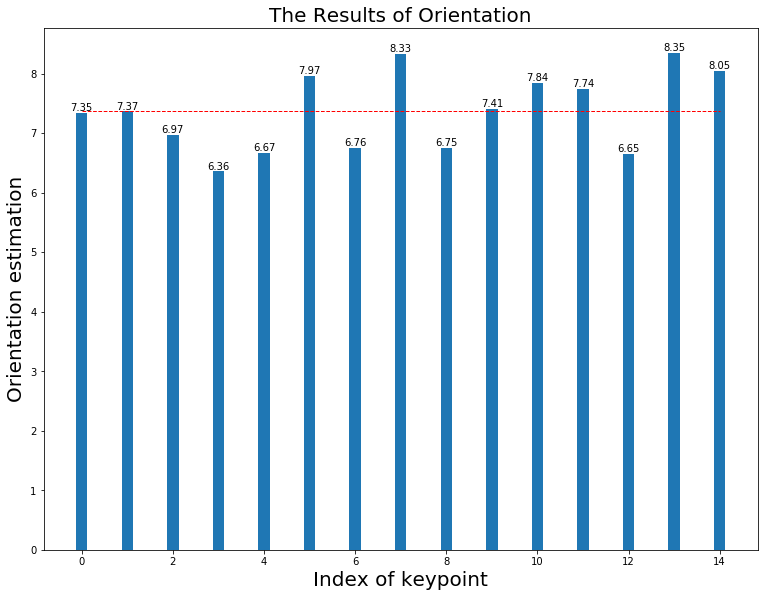

Final result: [     7.3461      7.3652      6.9742      6.3568      6.6703      7.9667      6.7571       8.332      6.7531      7.4074      7.8424      7.7398      6.6512      8.3511      8.0472]
FD Rotate(7.3):mean(7.371), median(7.371) in 0.101
The HoG estimation when (7.3) is  7


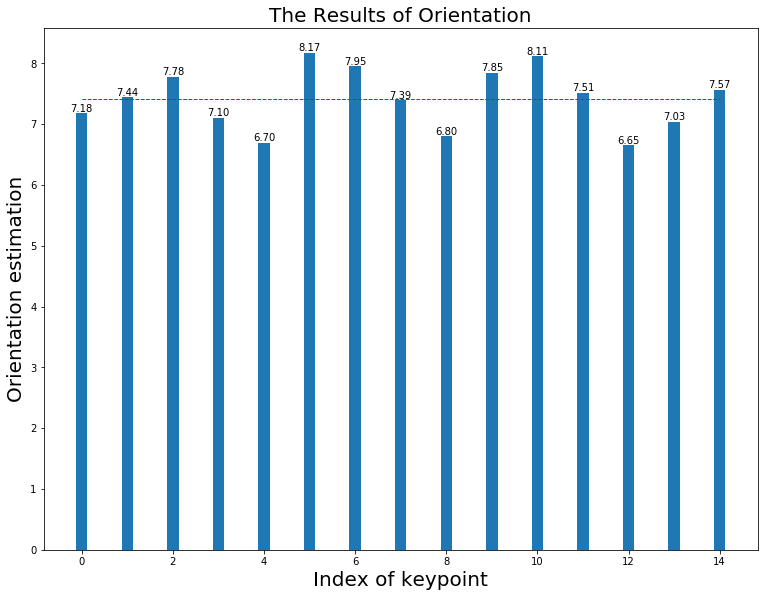

Final result: [     7.1762      7.4375      7.7776      7.1006      6.6968      8.1725      7.9507      7.3885      6.7999      7.8453      8.1148      7.5102      6.6517      7.0327      7.5679]
FD Rotate(7.4):mean(7.415), median(7.415) in 0.117
The HoG estimation when (7.4) is  8


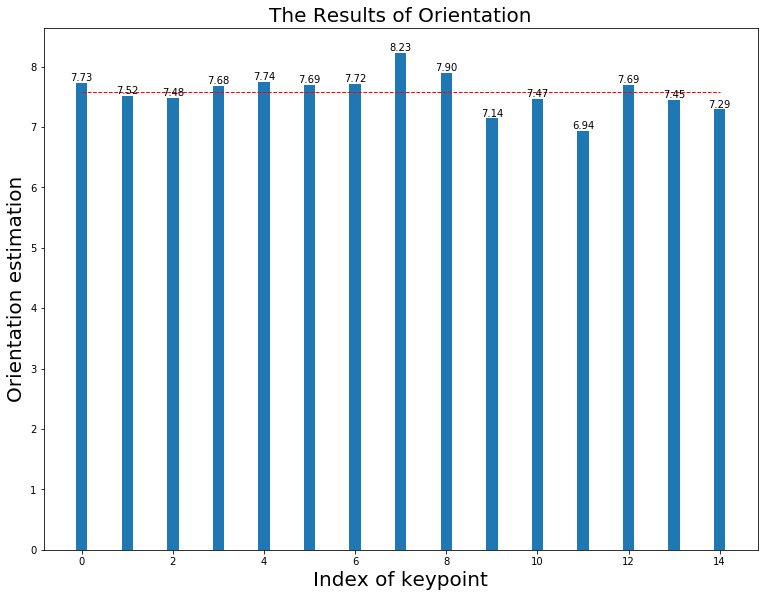

Final result: [     7.7261      7.5163       7.481      7.6793      7.7404      7.6909      7.7193      8.2279      7.8955      7.1431      7.4685      6.9384      7.6943      7.4462      7.2898]
FD Rotate(7.5):mean(7.577), median(7.577) in 0.108
The HoG estimation when (7.5) is  8


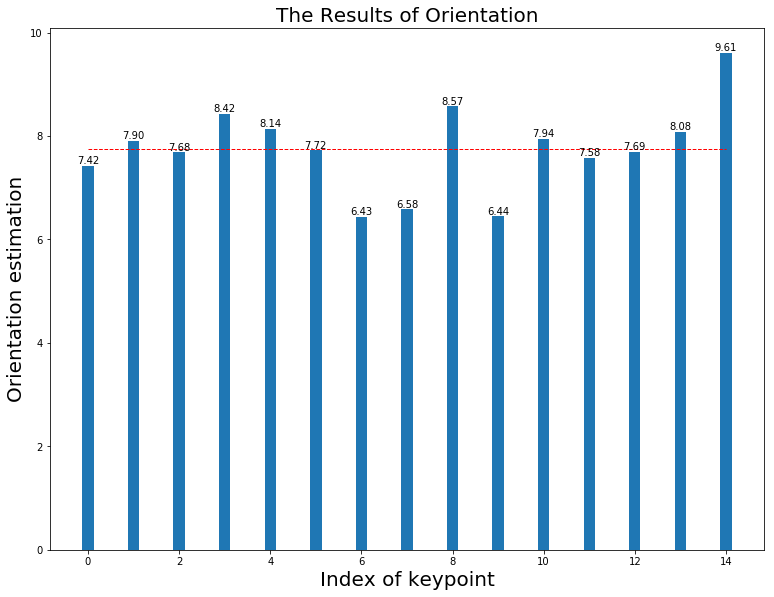

Final result: [     7.4217      7.8991      7.6832      8.4232      8.1373      7.7229      6.4306      6.5789      8.5708      6.4434      7.9437      7.5835      7.6935      8.0827      9.6079]
FD Rotate(7.6):mean(7.748), median(7.748) in 0.099
The HoG estimation when (7.6) is  8


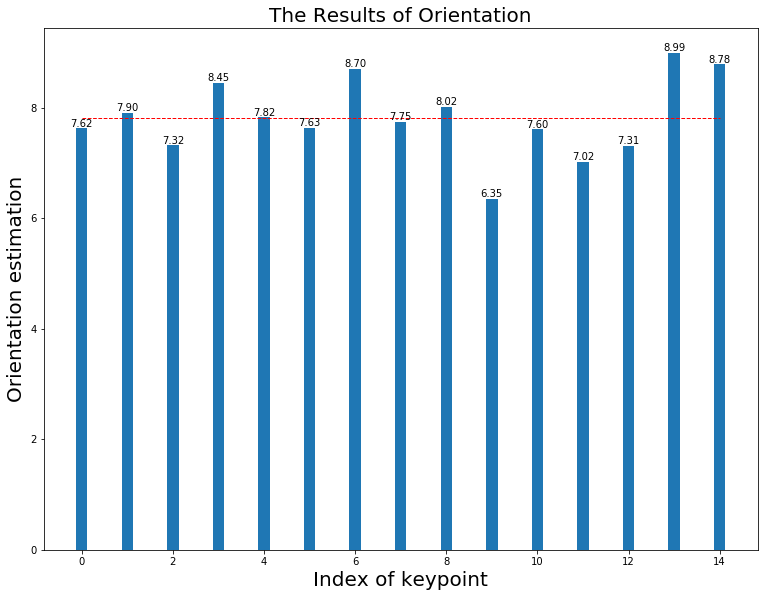

Final result: [     7.6235      7.8991      7.3171       8.451      7.8194      7.6346      8.6959      7.7465      8.0171      6.3489      7.6049      7.0162      7.3113      8.9896      8.7796]
FD Rotate(7.7):mean(7.817), median(7.817) in 0.103
The HoG estimation when (7.7) is  8


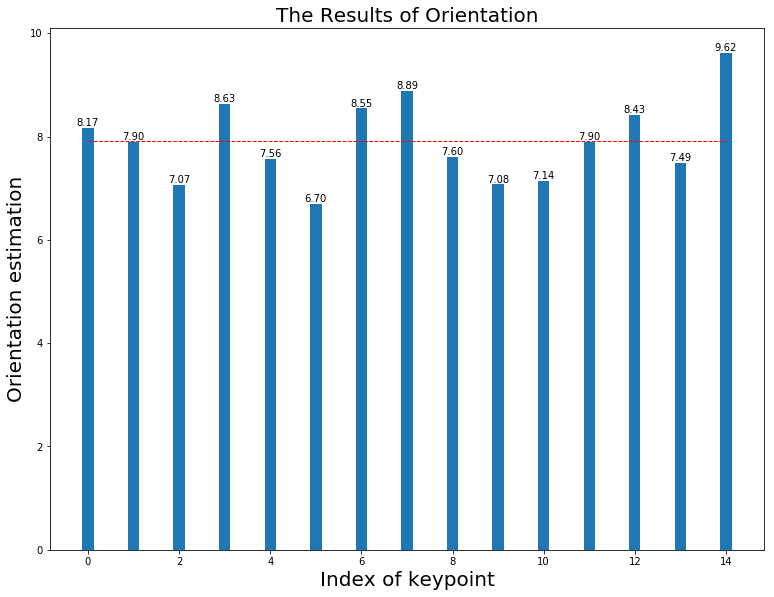

Final result: [     8.1664       7.903      7.0656      8.6254      7.5645      6.6959      8.5461      8.8883      7.6021       7.076      7.1353      7.9023       8.426      7.4949      9.6206]
FD Rotate(7.8):mean(7.914), median(7.914) in 0.103
The HoG estimation when (7.8) is  8


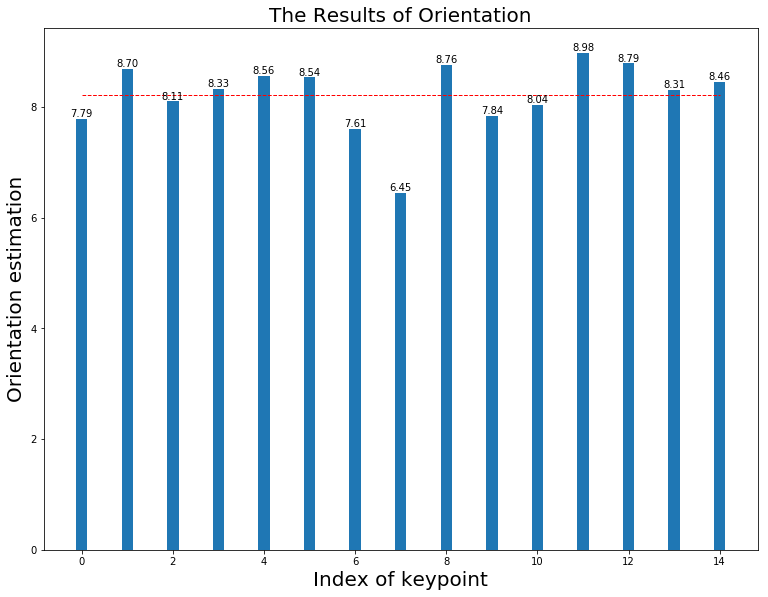

Final result: [     7.7861      8.6957      8.1068      8.3253      8.5595      8.5387      7.6063      6.4489      8.7616      7.8375      8.0387      8.9827      8.7911      8.3148      8.4603]
FD Rotate(7.9):mean(8.217), median(8.217) in 0.101
The HoG estimation when (7.9) is  8


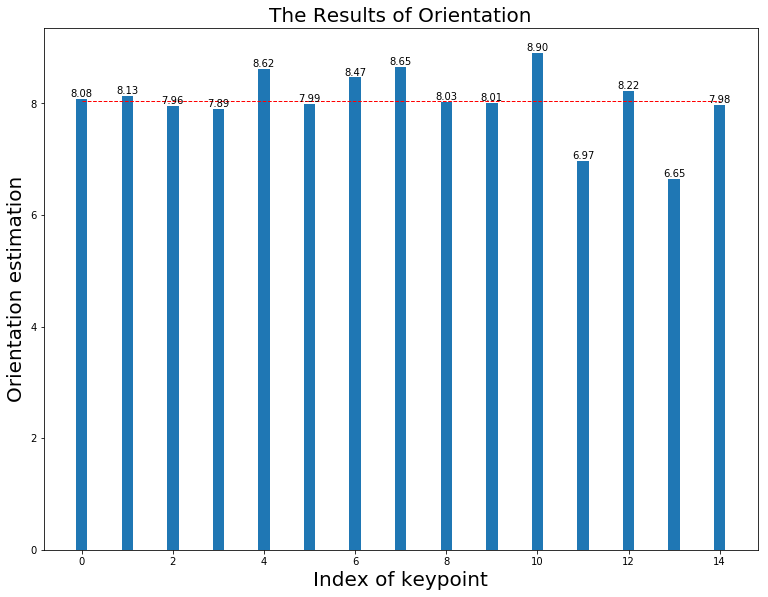

Final result: [     8.0824      8.1331      7.9603      7.8937      8.6197      7.9917       8.466       8.648      8.0294      8.0112      8.9049      6.9697      8.2243      6.6484      7.9763]
FD Rotate(8.0):mean(8.037), median(8.037) in 0.104
The HoG estimation when (8.0) is  8


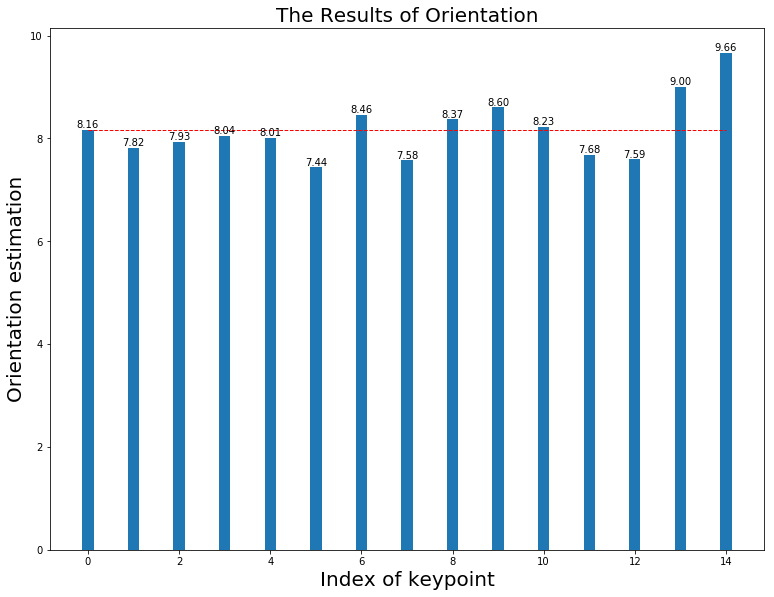

Final result: [     8.1636      7.8188      7.9306      8.0443      8.0078      7.4355      8.4598      7.5751      8.3696       8.602      8.2303      7.6815      7.5916      9.0035      9.6649]
FD Rotate(8.1):mean(8.172), median(8.172) in 0.099
The HoG estimation when (8.1) is  8


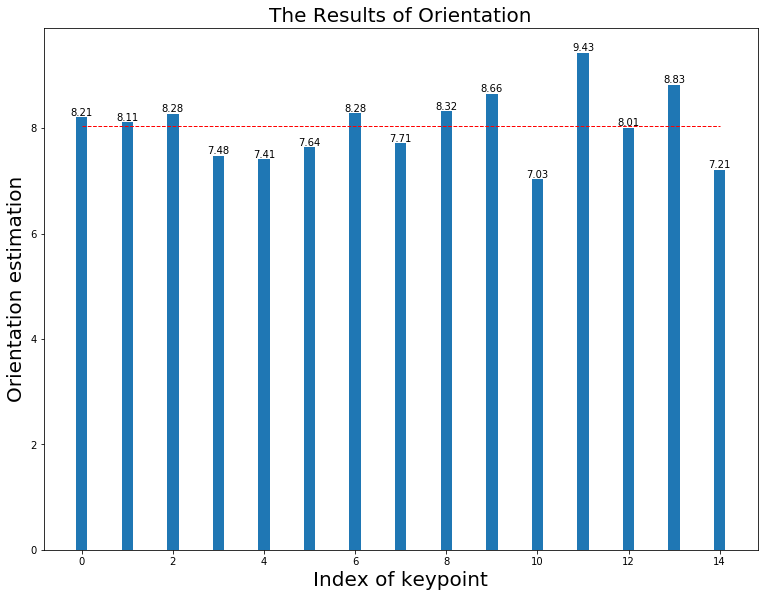

Final result: [     8.2068      8.1087      8.2786      7.4787       7.407      7.6382      8.2815      7.7106      8.3188      8.6581      7.0292      9.4313      8.0077      8.8268       7.211]
FD Rotate(8.2):mean(8.040), median(8.040) in 0.104
The HoG estimation when (8.2) is  8


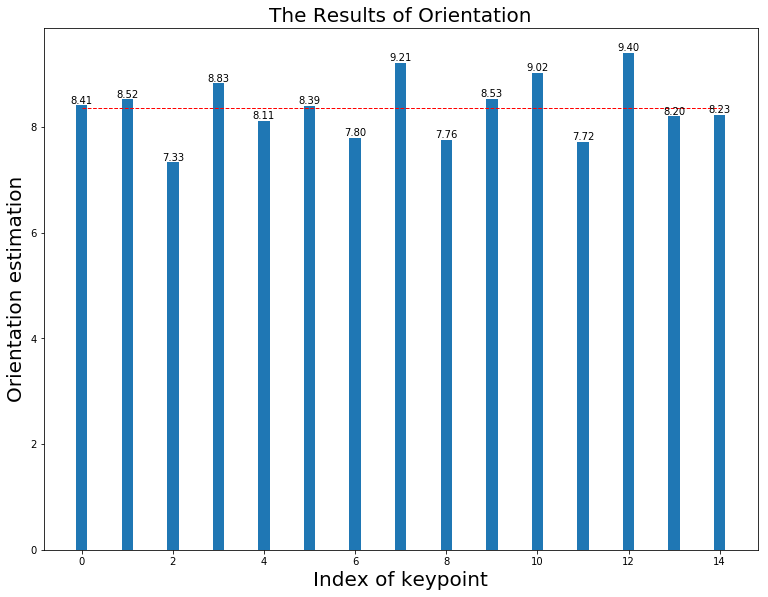

Final result: [     8.4094      8.5213      7.3293      8.8254      8.1121      8.3928      7.7973      9.2128       7.759      8.5345      9.0205      7.7238      9.4037      8.1991      8.2286]
FD Rotate(8.3):mean(8.365), median(8.365) in 0.105
The HoG estimation when (8.3) is  8


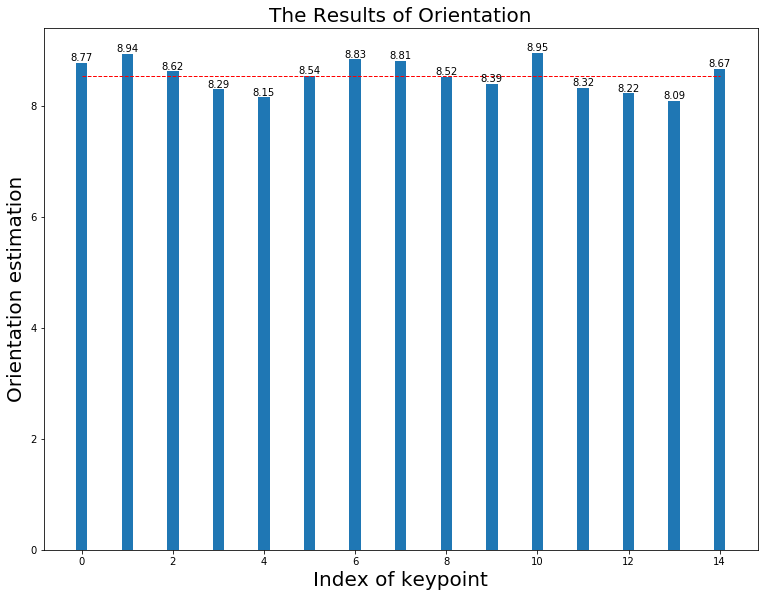

Final result: [     8.7694      8.9371      8.6185      8.2933      8.1509      8.5407      8.8318      8.8081      8.5177      8.3914      8.9521      8.3153      8.2216      8.0919      8.6689]
FD Rotate(8.4):mean(8.541), median(8.541) in 0.102
The HoG estimation when (8.4) is  9


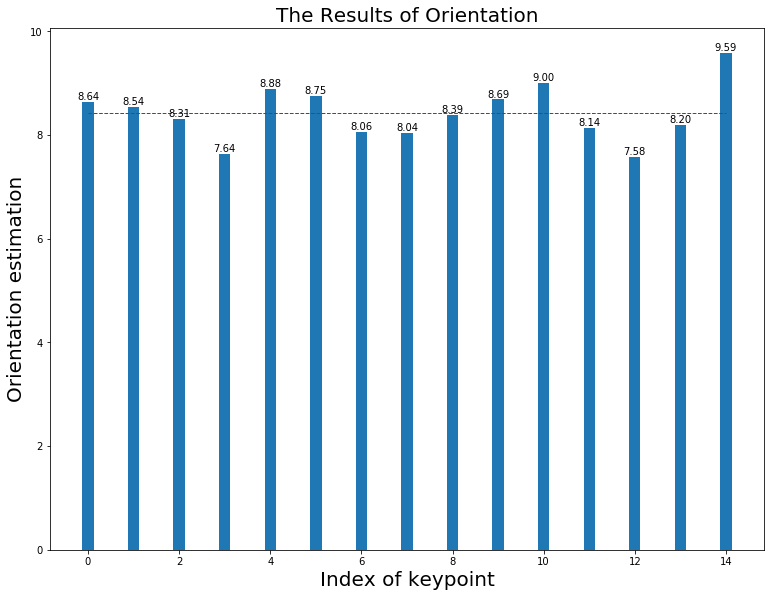

Final result: [     8.6358      8.5402      8.3103      7.6353      8.8846       8.752      8.0641      8.0356        8.39      8.6879      9.0028      8.1428      7.5831      8.1992      9.5871]
FD Rotate(8.5):mean(8.430), median(8.430) in 0.116
The HoG estimation when (8.5) is  9


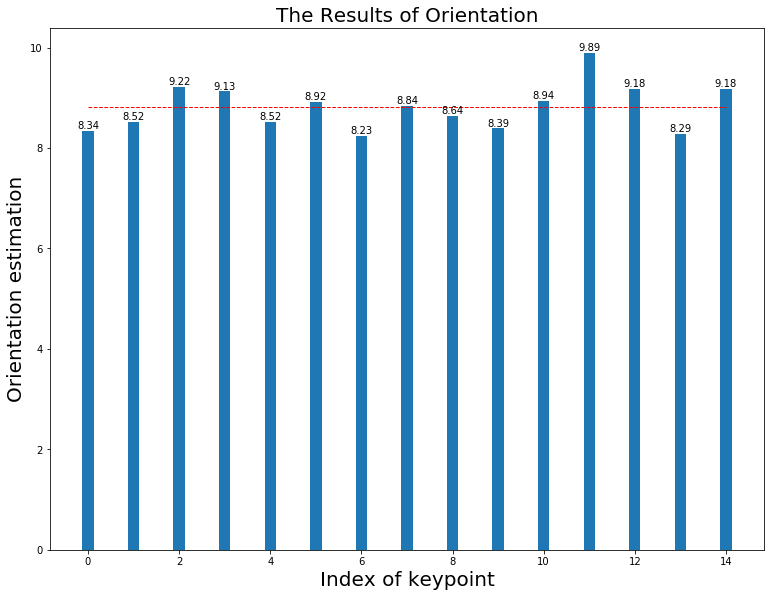

Final result: [     8.3395      8.5193      9.2185      9.1291      8.5191      8.9166      8.2336      8.8438      8.6398      8.3925      8.9415      9.8947      9.1797      8.2855      9.1824]
FD Rotate(8.6):mean(8.816), median(8.816) in 0.101
The HoG estimation when (8.6) is  9


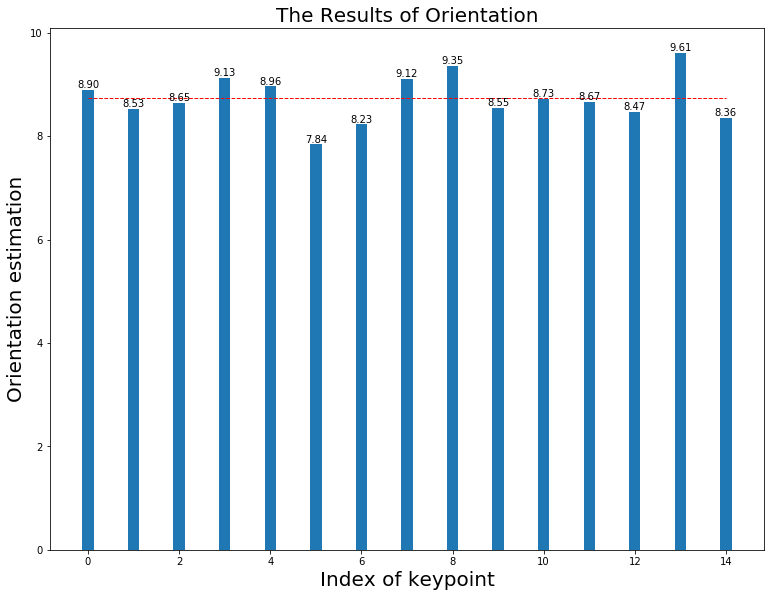

Final result: [     8.8994      8.5299       8.652      9.1265      8.9623       7.843      8.2297      9.1151      9.3542      8.5536      8.7291      8.6692       8.466      9.6142      8.3616]
FD Rotate(8.7):mean(8.740), median(8.740) in 0.105
The HoG estimation when (8.7) is  9


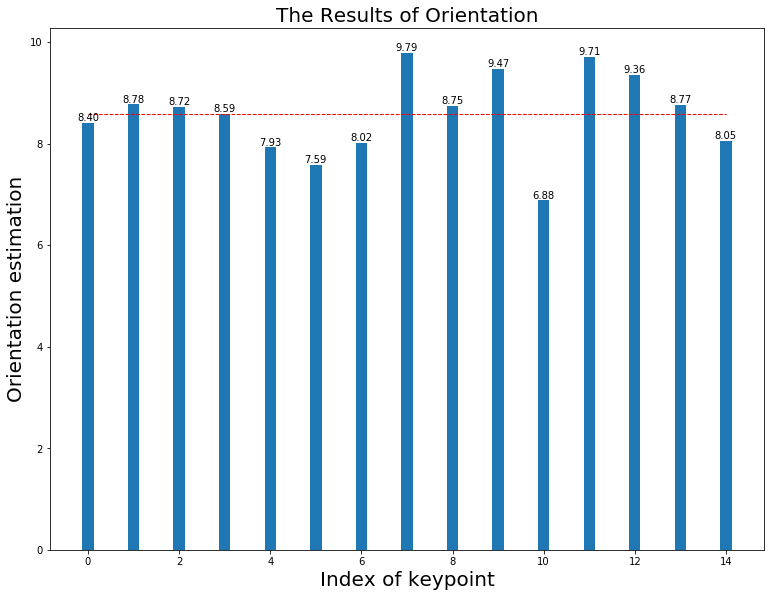

Final result: [     8.4045      8.7751      8.7241      8.5888      7.9301       7.589      8.0232      9.7912      8.7491      9.4676      6.8834      9.7139      9.3593      8.7691      8.0502]
FD Rotate(8.8):mean(8.588), median(8.588) in 0.100
The HoG estimation when (8.8) is  9


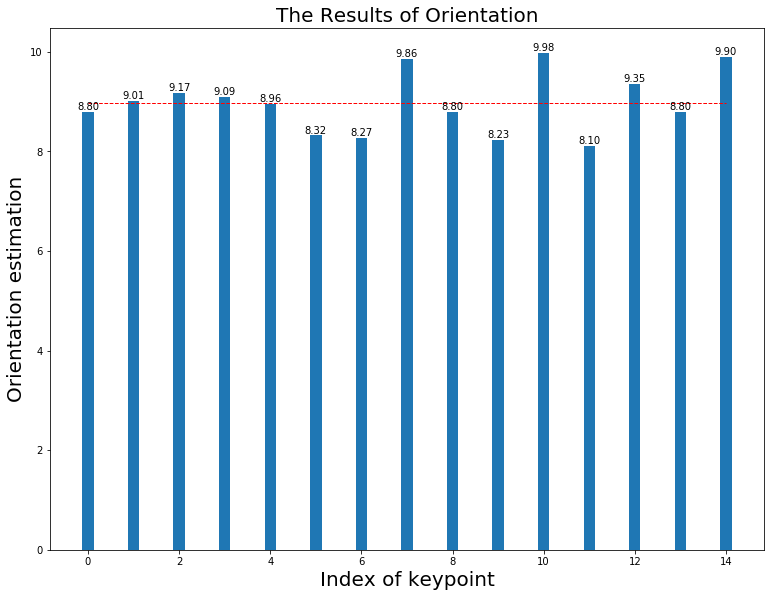

Final result: [     8.7986      9.0103      9.1685      9.0916      8.9553      8.3179      8.2659      9.8577      8.7967      8.2327      9.9777      8.1028      9.3545      8.7983      9.9002]
FD Rotate(8.9):mean(8.975), median(8.975) in 0.097
The HoG estimation when (8.9) is  9


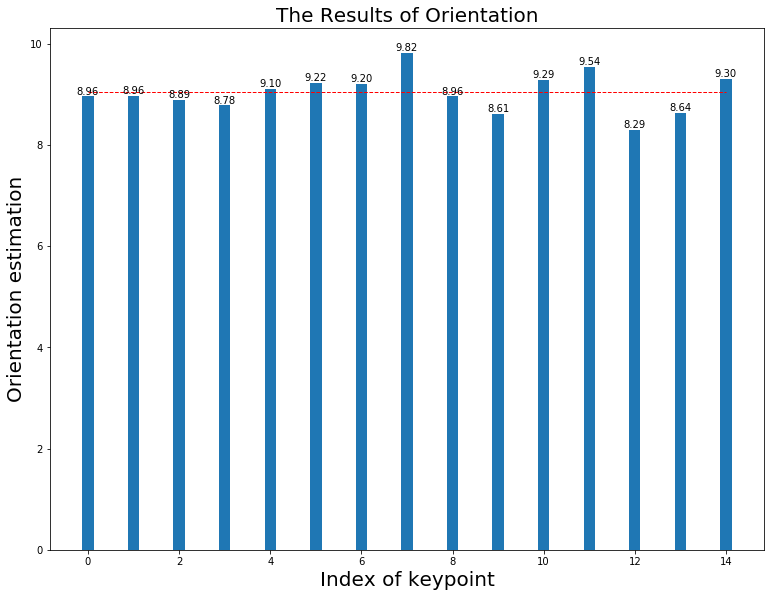

Final result: [      8.958       8.963      8.8861      8.7802      9.1003      9.2186      9.2025      9.8186      8.9558      8.6096      9.2894      9.5417       8.289      8.6386       9.303]
FD Rotate(9.0):mean(9.037), median(9.037) in 0.091
The HoG estimation when (9.0) is  9


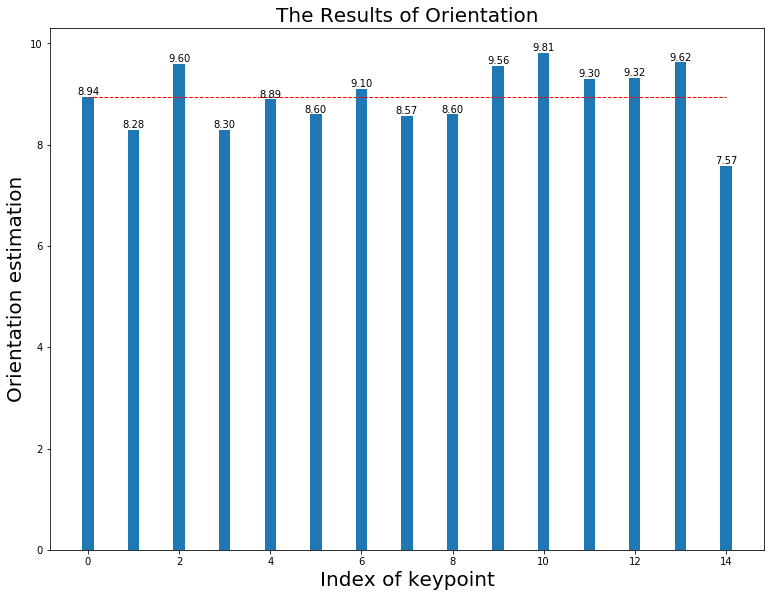

Final result: [     8.9404      8.2845      9.5977      8.2953      8.8939      8.5979      9.0992      8.5709      8.5974      9.5578      9.8132      9.3016      9.3207      9.6235      7.5749]
FD Rotate(9.1):mean(8.938), median(8.938) in 0.104
The HoG estimation when (9.1) is  9


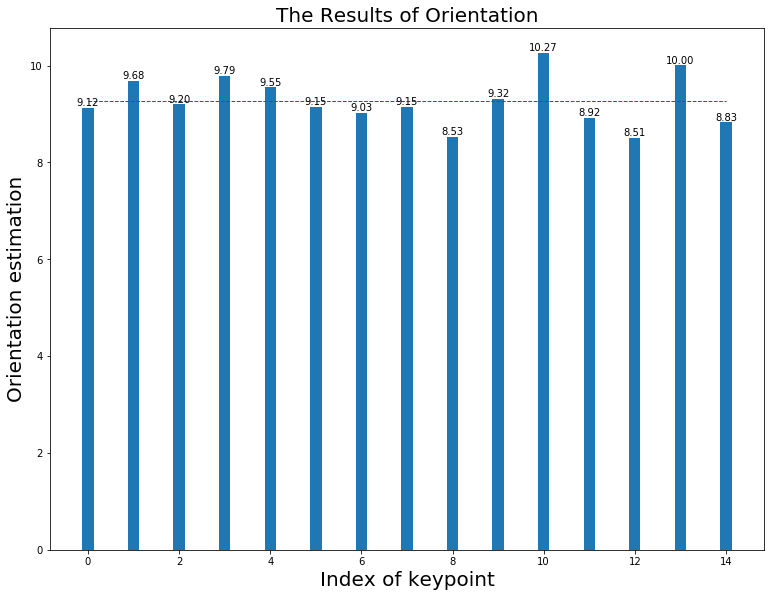

Final result: [     9.1227      9.6801      9.2015      9.7888      9.5499      9.1478      9.0294      9.1544      8.5292      9.3183      10.265      8.9165      8.5076      10.004      8.8294]
FD Rotate(9.2):mean(9.270), median(9.270) in 0.104
The HoG estimation when (9.2) is  9


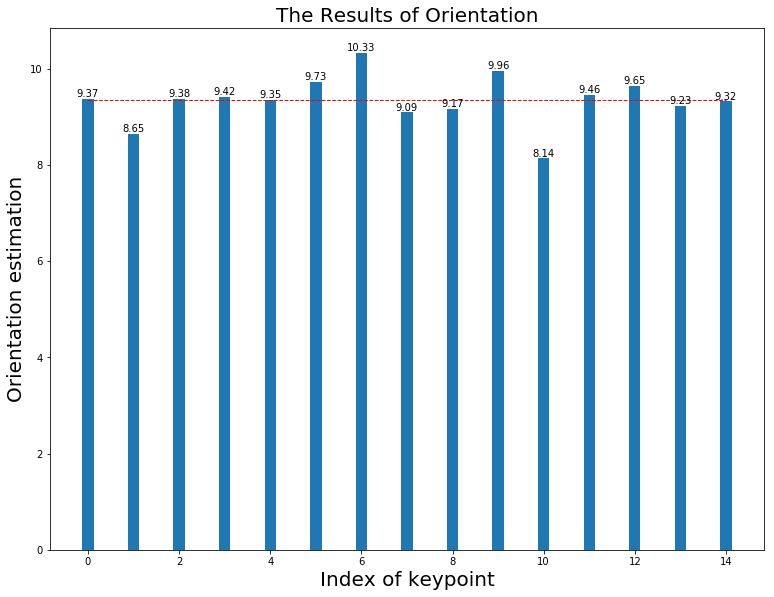

Final result: [     9.3669      8.6452      9.3805      9.4218      9.3461      9.7293      10.331       9.092      9.1677       9.958      8.1376      9.4608      9.6489      9.2254      9.3206]
FD Rotate(9.3):mean(9.349), median(9.349) in 0.102
The HoG estimation when (9.3) is  9


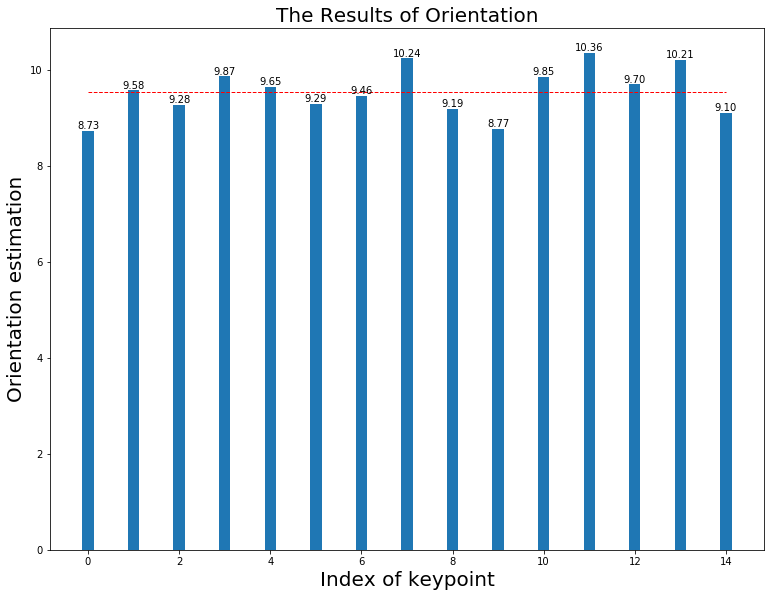

Final result: [     8.7324      9.5766      9.2808      9.8676      9.6543      9.2899      9.4638      10.241      9.1875      8.7726      9.8544       10.36      9.7043      10.207      9.1025]
FD Rotate(9.4):mean(9.553), median(9.553) in 0.104
The HoG estimation when (9.4) is  9


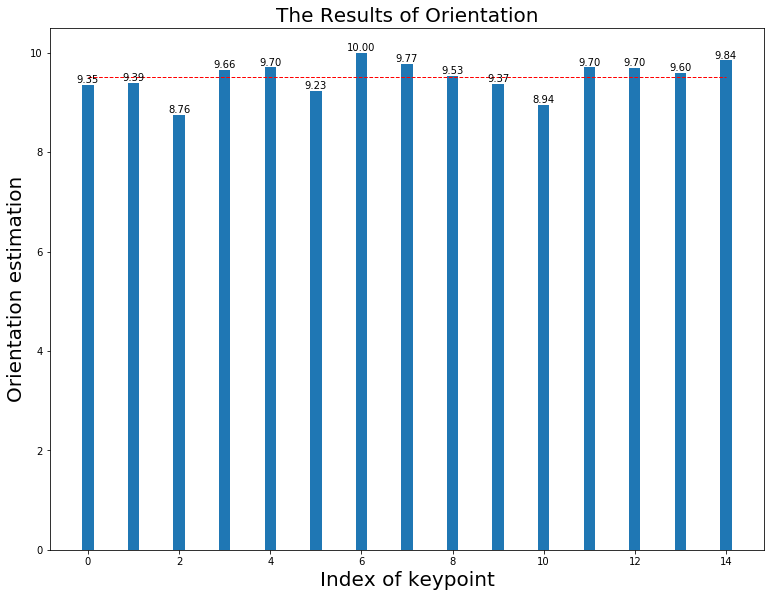

Final result: [     9.3517      9.3873      8.7563      9.6611      9.7029      9.2341      9.9979      9.7721      9.5304      9.3699      8.9433      9.7047      9.6986      9.5957      9.8445]
FD Rotate(9.5):mean(9.503), median(9.503) in 0.088
The HoG estimation when (9.5) is 10


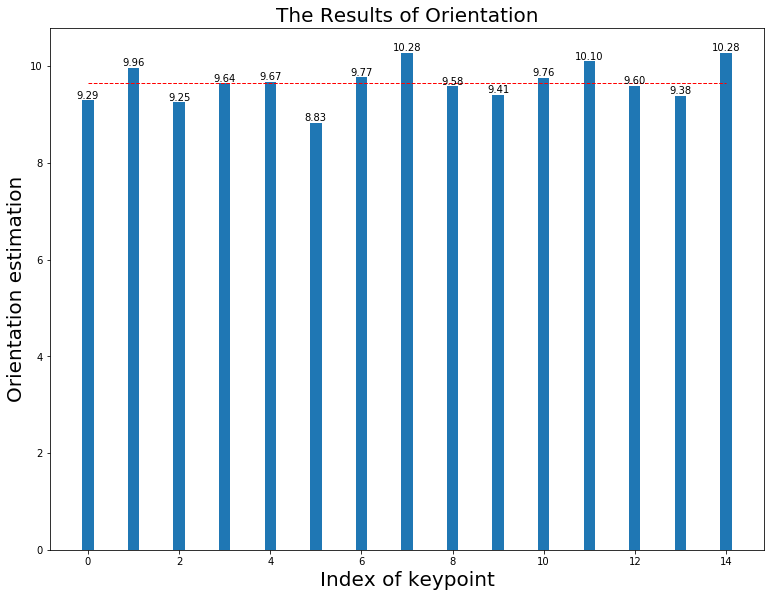

Final result: [     9.2927      9.9589      9.2518      9.6432      9.6691      8.8266       9.769      10.275      9.5819      9.4077      9.7639      10.097      9.5988      9.3813      10.277]
FD Rotate(9.6):mean(9.653), median(9.653) in 0.106
The HoG estimation when (9.6) is 10


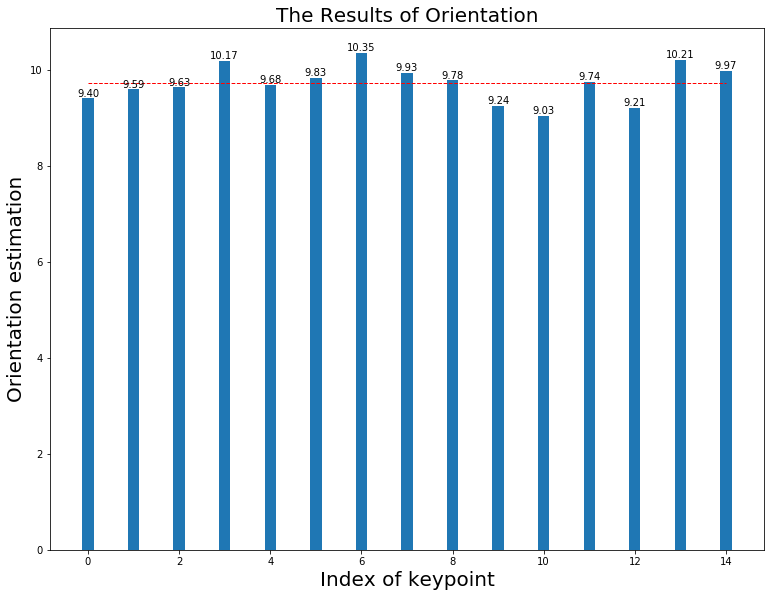

Final result: [     9.4014      9.5863      9.6274      10.175      9.6833      9.8285      10.349      9.9299      9.7753      9.2412       9.033      9.7408       9.206      10.208      9.9673]
FD Rotate(9.7):mean(9.717), median(9.717) in 0.103
The HoG estimation when (9.7) is 10


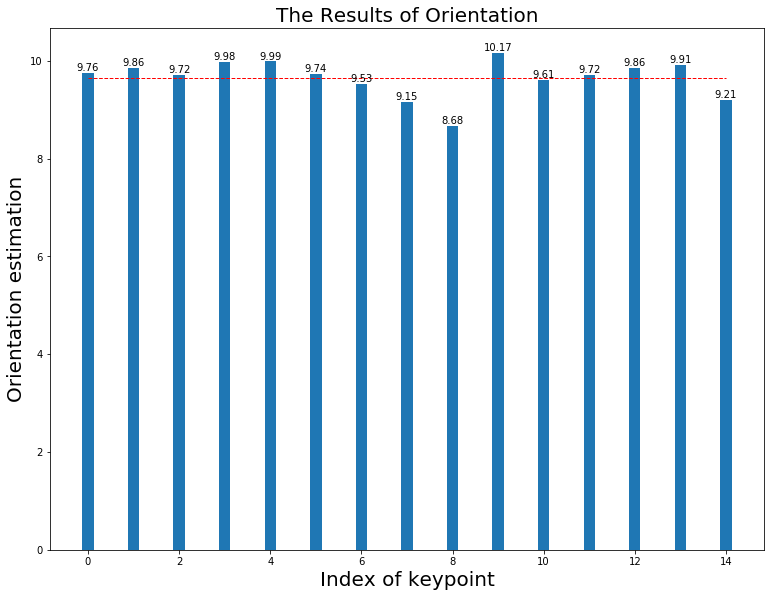

Final result: [     9.7599      9.8553       9.721      9.9787      9.9889      9.7417      9.5309      9.1541      8.6775      10.165      9.6061      9.7186      9.8636      9.9144        9.21]
FD Rotate(9.8):mean(9.659), median(9.659) in 0.101
The HoG estimation when (9.8) is 10


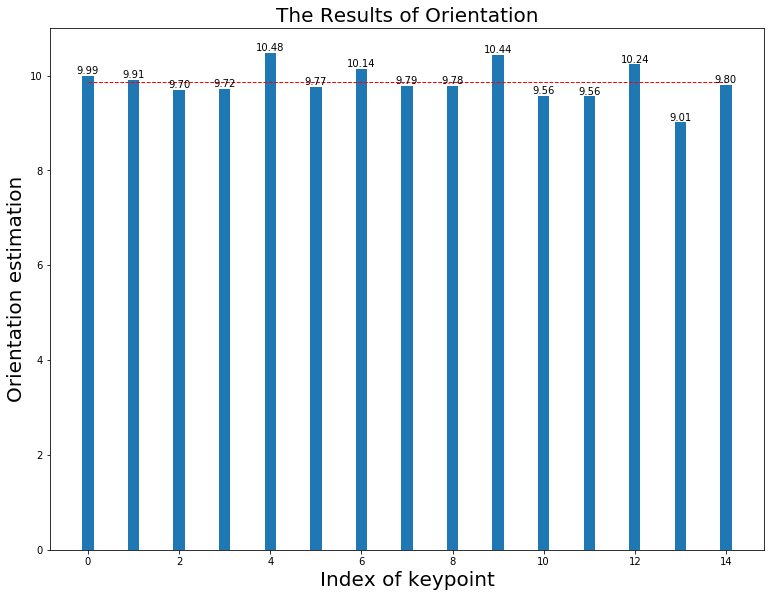

Final result: [     9.9881      9.9136      9.6985      9.7241      10.479      9.7668      10.141      9.7883      9.7758      10.435      9.5645      9.5594      10.236      9.0124      9.8003]
FD Rotate(9.9):mean(9.859), median(9.859) in 0.104
The HoG estimation when (9.9) is 10


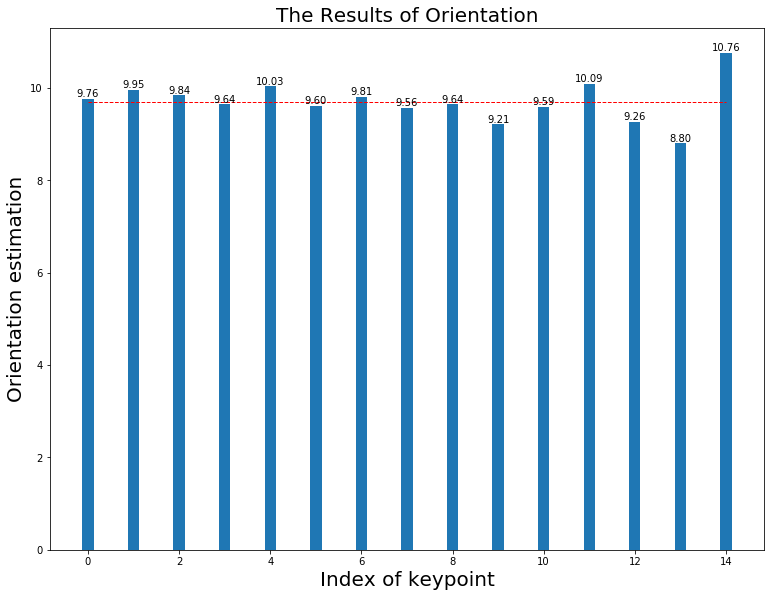

Final result: [     9.7607      9.9522      9.8415      9.6422      10.032      9.6043      9.8077      9.5633      9.6436      9.2112      9.5884      10.089      9.2586      8.7973      10.761]
FD Rotate(10.0):mean(9.704), median(9.704) in 0.104
The HoG estimation when (10.0) is 10


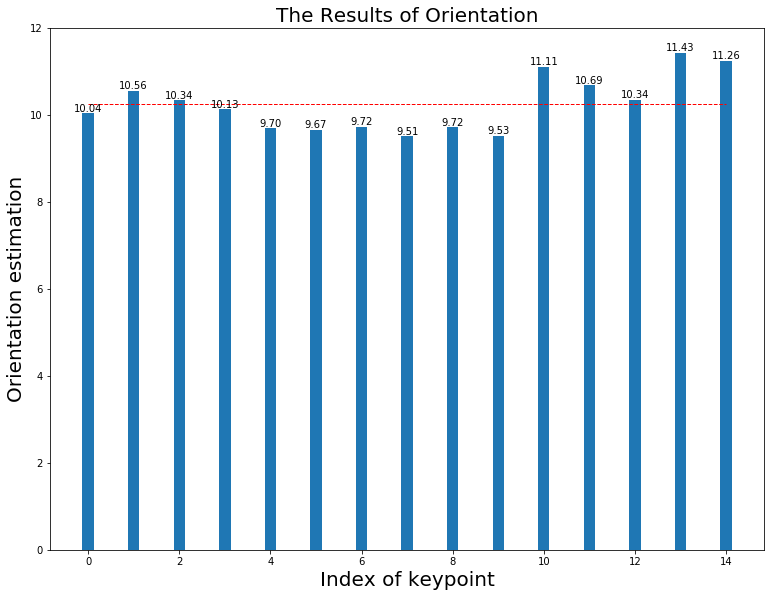

Final result: [     10.042      10.557      10.341      10.134      9.6989      9.6682      9.7221      9.5116      9.7167      9.5267      11.115      10.686      10.344      11.435      11.257]
FD Rotate(10.1):mean(10.250), median(10.250) in 0.103
The HoG estimation when (10.1) is 10


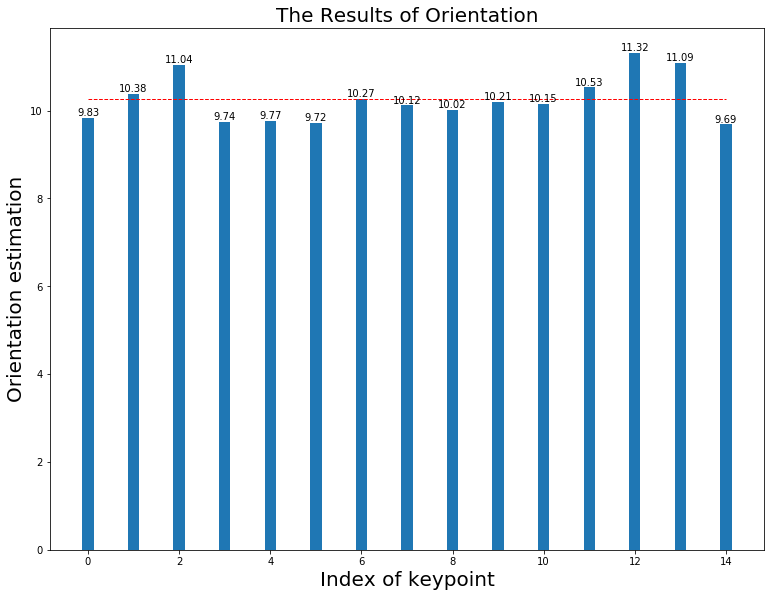

Final result: [     9.8328      10.377      11.043      9.7405        9.77      9.7199       10.27      10.121       10.02      10.206      10.152       10.53      11.317      11.086      9.6864]
FD Rotate(10.2):mean(10.258), median(10.258) in 0.109
The HoG estimation when (10.2) is 10


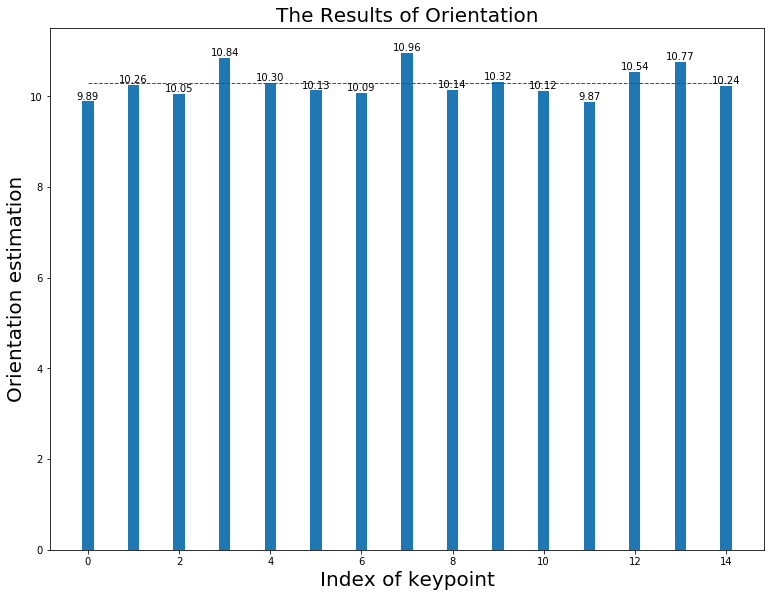

Final result: [     9.8915      10.258      10.052      10.842      10.298      10.133      10.085      10.961      10.136      10.322      10.121      9.8739      10.544      10.769      10.236]
FD Rotate(10.3):mean(10.302), median(10.302) in 0.102
The HoG estimation when (10.3) is 10


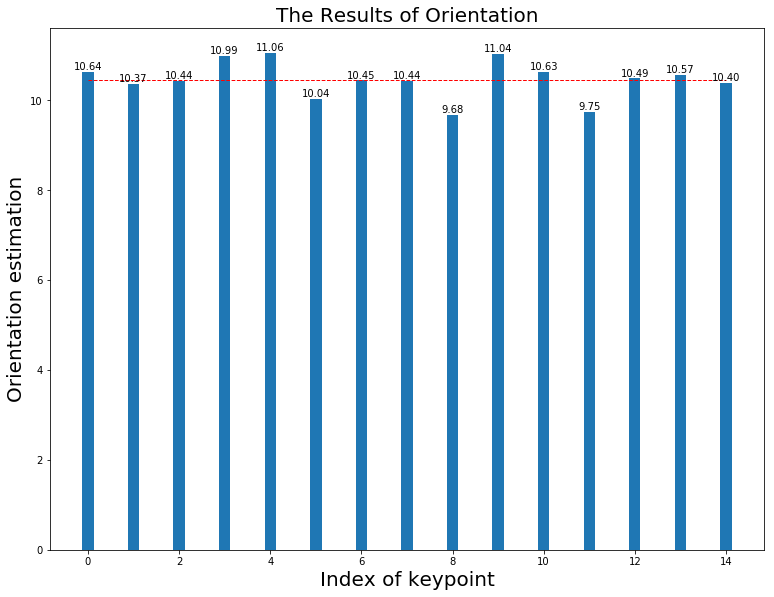

Final result: [     10.642      10.373      10.443      10.988       11.06      10.037      10.446      10.437      9.6784      11.037      10.631      9.7452      10.489      10.567      10.397]
FD Rotate(10.4):mean(10.465), median(10.465) in 0.103
The HoG estimation when (10.4) is 11


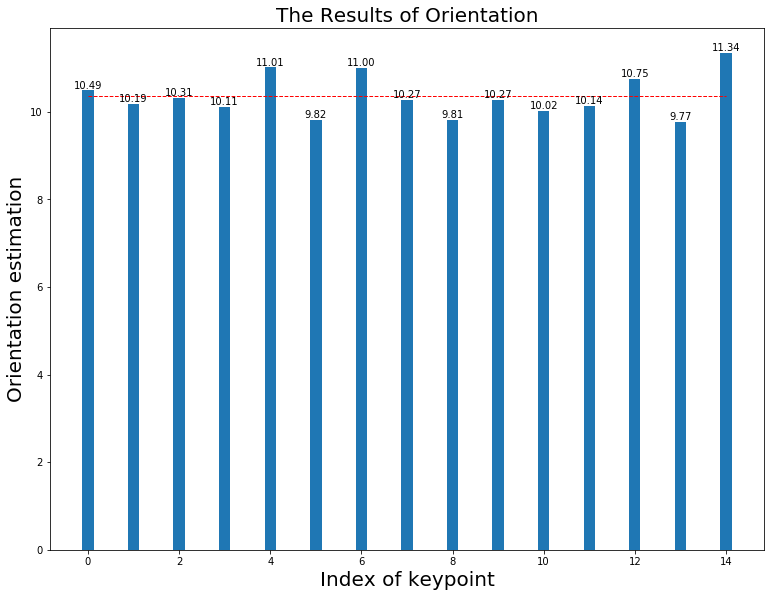

Final result: [     10.487      10.186      10.309       10.11      11.008      9.8206      11.001       10.27      9.8064       10.27      10.021      10.137      10.755      9.7708      11.344]
FD Rotate(10.5):mean(10.353), median(10.353) in 0.102
The HoG estimation when (10.5) is 10


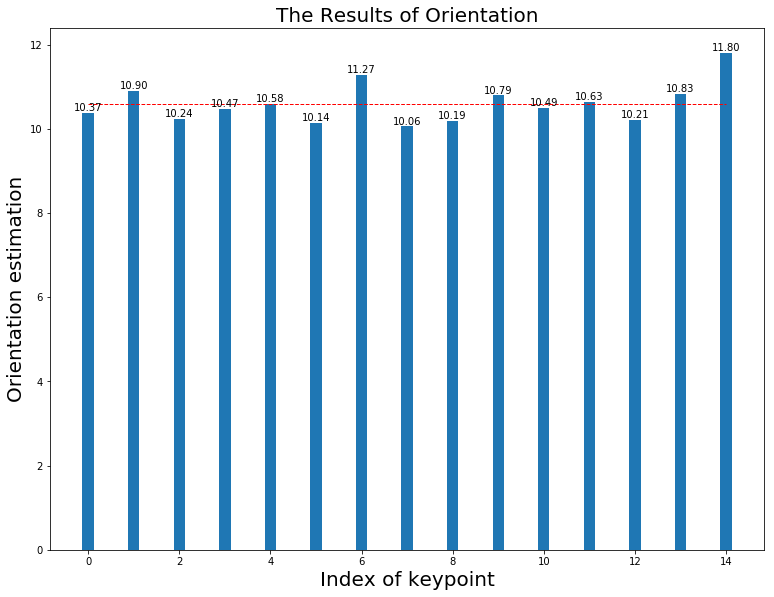

Final result: [     10.369      10.903      10.242      10.466      10.584      10.137      11.275      10.056       10.19      10.791      10.487      10.634      10.206      10.829      11.804]
FD Rotate(10.6):mean(10.598), median(10.598) in 0.106
The HoG estimation when (10.6) is 11


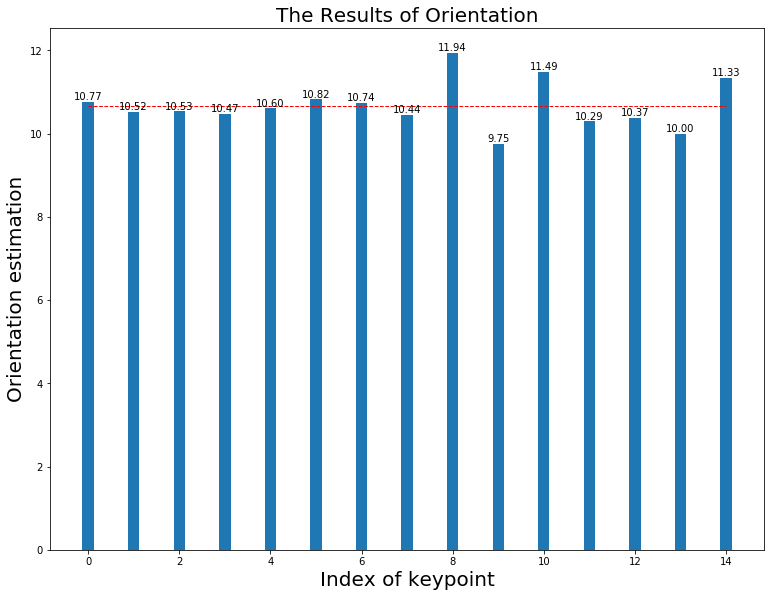

Final result: [     10.769      10.517      10.532      10.469      10.605      10.823      10.737      10.443      11.942      9.7484       11.49      10.292      10.373      9.9976      11.334]
FD Rotate(10.7):mean(10.672), median(10.672) in 0.100
The HoG estimation when (10.7) is 11


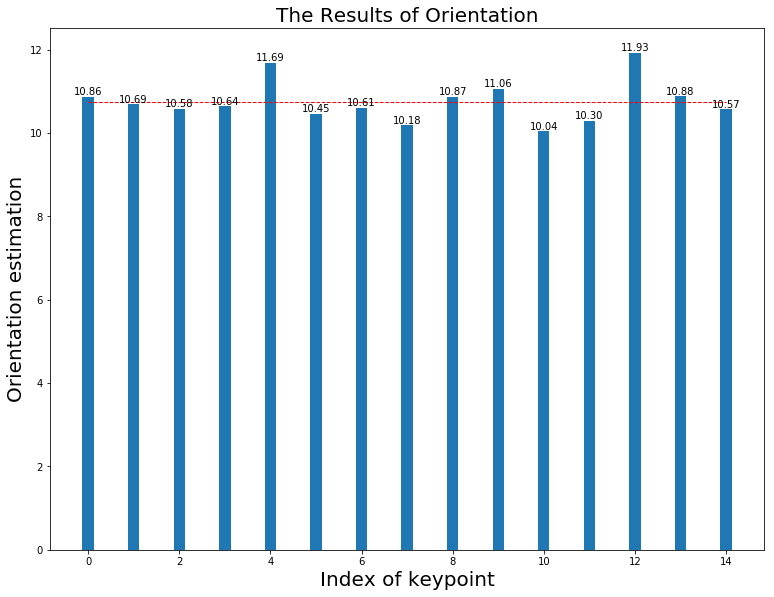

Final result: [     10.865       10.69      10.585      10.639       11.69      10.453      10.614      10.183      10.866       11.06      10.041      10.299      11.926      10.879       10.57]
FD Rotate(10.8):mean(10.757), median(10.757) in 0.098
The HoG estimation when (10.8) is 11


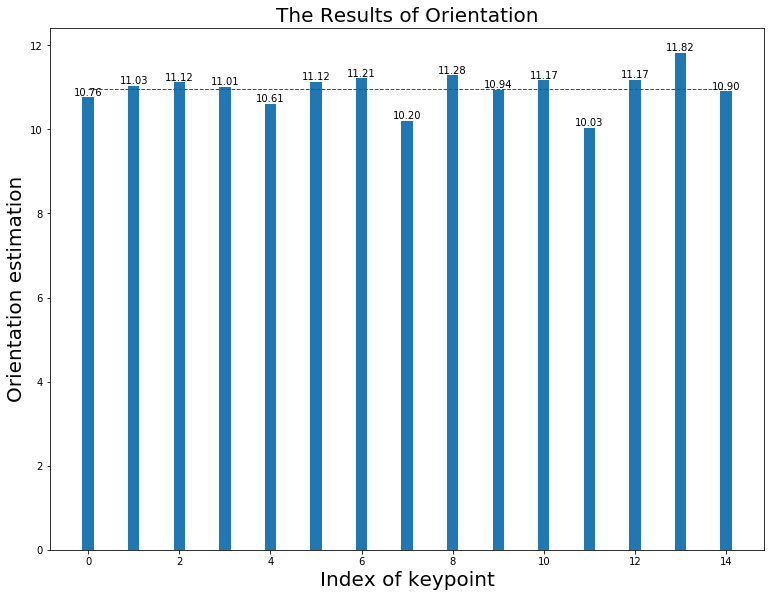

Final result: [      10.76      11.028      11.119      11.012      10.614      11.122      11.211      10.204      11.283      10.943      11.167      10.027      11.174      11.821      10.904]
FD Rotate(10.9):mean(10.959), median(10.959) in 0.106
The HoG estimation when (10.9) is 11


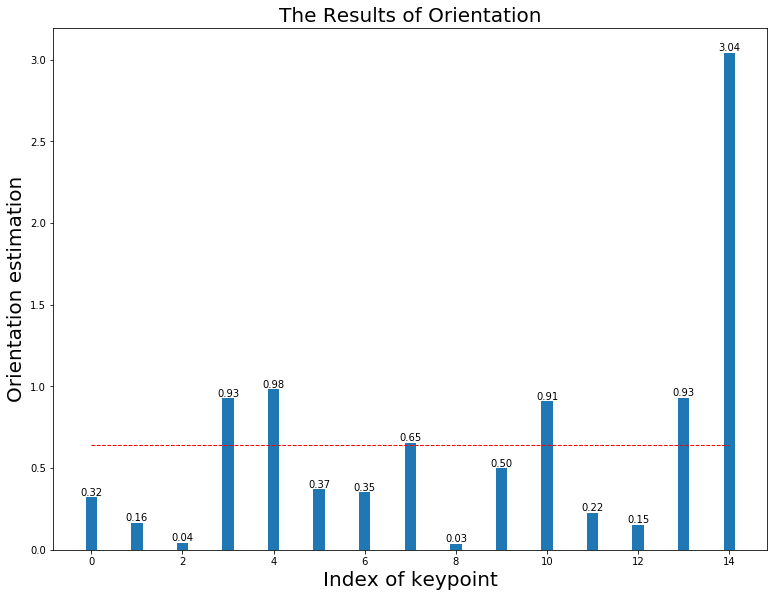

Final result: [    0.32072     0.16457    0.042694     0.92761     0.98158     0.36945     0.35223     0.65402    0.034241      0.4987     0.90826     0.22467     0.15311      0.9278      3.0423]
FD Rotate(1.0):mean(0.640), median(0.469) in 0.011
The HoG estimation when (1.0) is  1


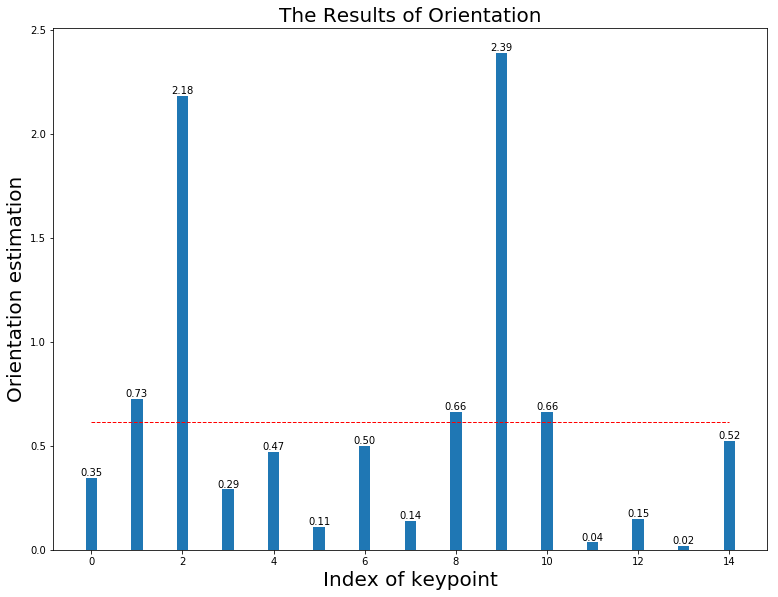

Final result: [    0.34673      0.7263      2.1831     0.29054     0.47104      0.1116     0.50075     0.13748     0.66439        2.39     0.66473    0.035202     0.14746     0.01799     0.52345]
FD Rotate(1.1):mean(0.614), median(0.614) in 0.011
The HoG estimation when (1.1) is  1


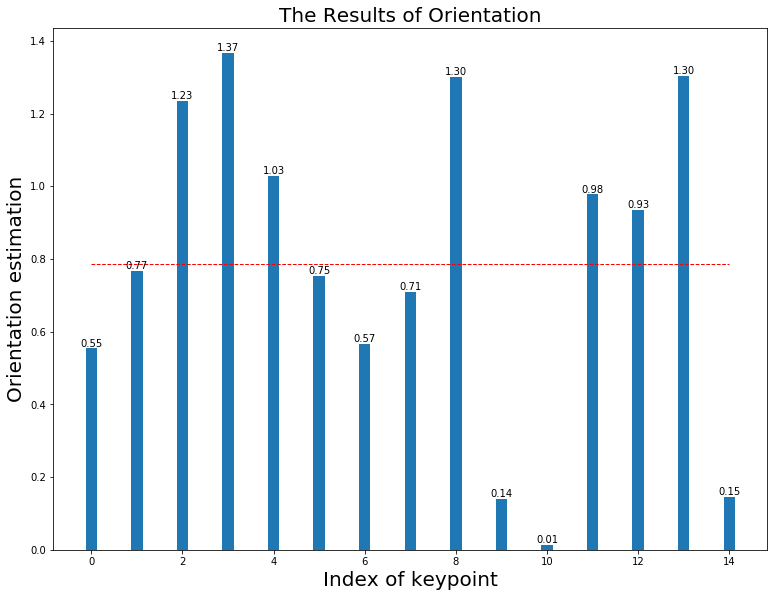

Final result: [     0.5543     0.76636      1.2342       1.367      1.0276     0.75332     0.56613     0.70934      1.3018     0.14072    0.013336     0.97754     0.93423      1.3035     0.14581]
FD Rotate(1.2):mean(0.786), median(0.786) in 0.011
The HoG estimation when (1.2) is  1


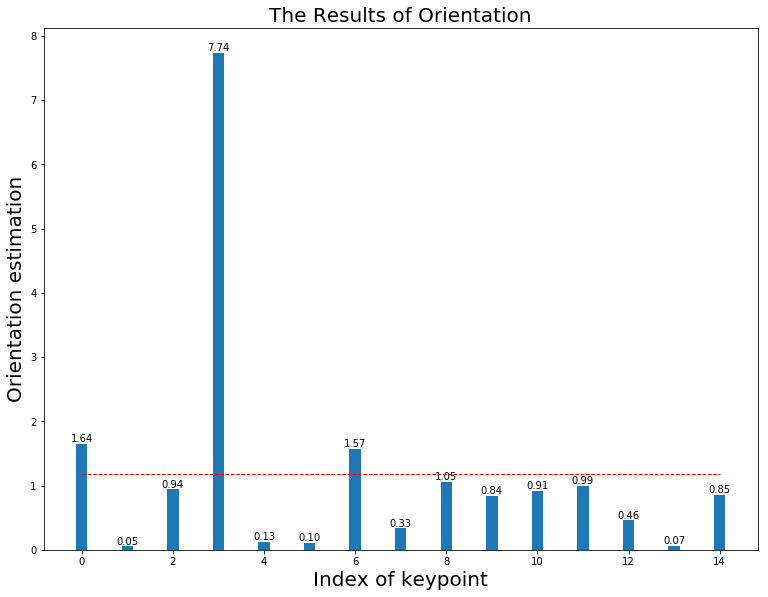

Final result: [     1.6448    0.053379     0.93921      7.7363     0.12578     0.10475      1.5666      0.3345      1.0545     0.83649     0.91206     0.99339     0.45761    0.065977     0.84931]
FD Rotate(1.3):mean(1.178), median(0.710) in 0.011
The HoG estimation when (1.3) is  1


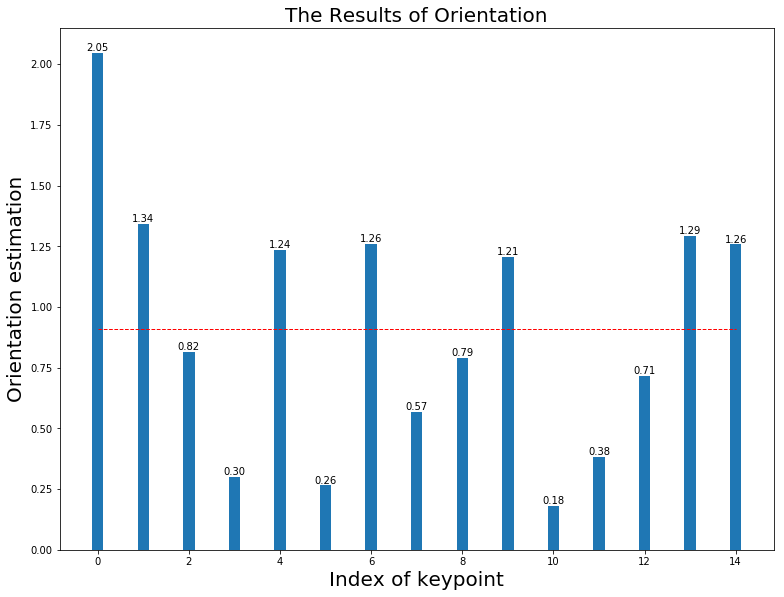

Final result: [     2.0471      1.3412     0.81586     0.30103      1.2351     0.26489      1.2589     0.56775     0.79008      1.2059     0.18152     0.38186     0.71495      1.2917      1.2583]
FD Rotate(1.4):mean(0.910), median(0.910) in 0.026
The HoG estimation when (1.4) is  2


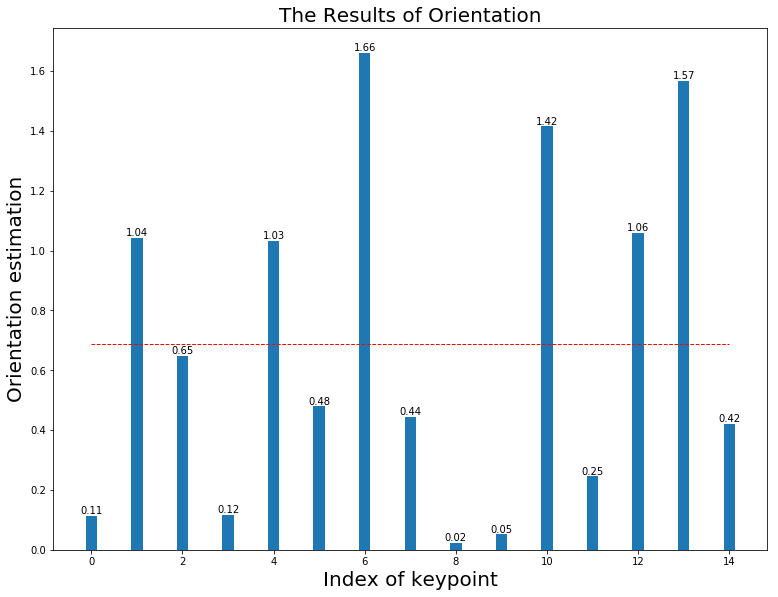

Final result: [    0.11377      1.0431     0.64809     0.11609      1.0317     0.47949      1.6614     0.44425    0.022461    0.051849      1.4151     0.24557      1.0604      1.5686     0.42099]
FD Rotate(1.5):mean(0.688), median(0.688) in 0.011
The HoG estimation when (1.5) is  2


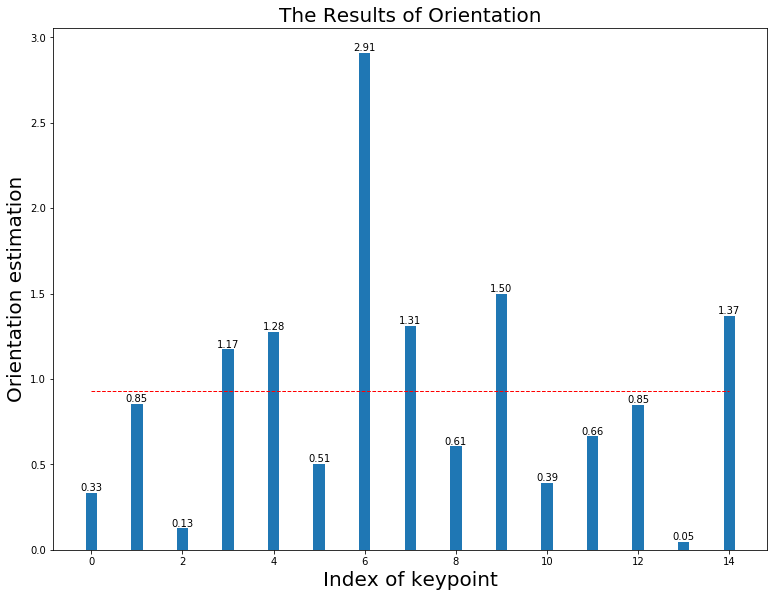

Final result: [    0.33472     0.85327     0.12612      1.1737      1.2778     0.50516        2.91      1.3127     0.60526      1.4986     0.39362     0.66415     0.84993    0.045502      1.3691]
FD Rotate(1.6):mean(0.928), median(0.786) in 0.011
The HoG estimation when (1.6) is  2


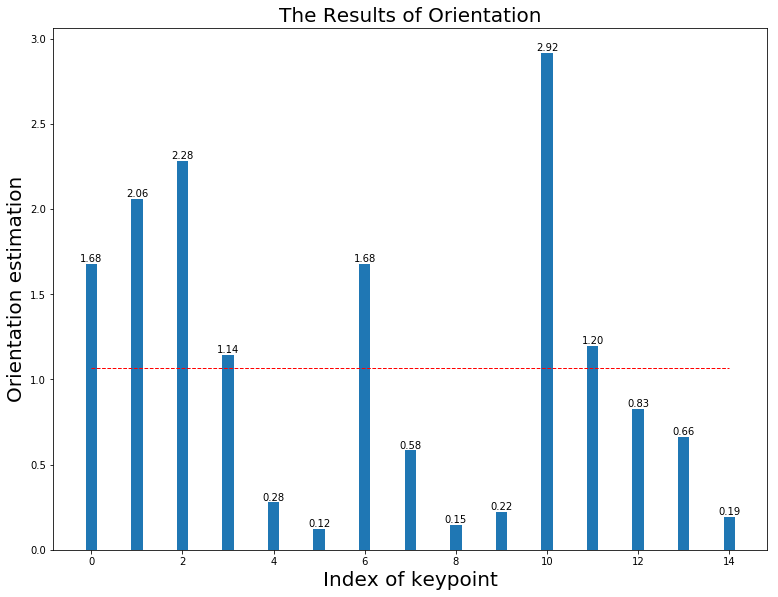

Final result: [     1.6805      2.0612      2.2821       1.144     0.27911     0.12344      1.6797     0.58426     0.14821     0.22269      2.9175      1.1951     0.82559     0.66306     0.19342]
FD Rotate(1.7):mean(1.067), median(0.934) in 0.012
The HoG estimation when (1.7) is  2


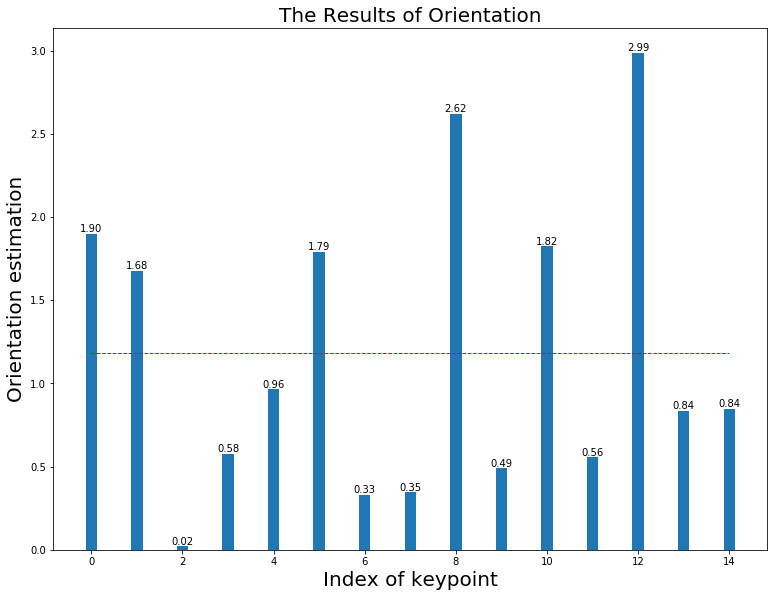

Final result: [     1.8972      1.6776     0.02037     0.57565      0.9648      1.7897     0.32996     0.34544      2.6194     0.48972      1.8239     0.55569      2.9866     0.83542     0.84479]
FD Rotate(1.8):mean(1.184), median(1.055) in 0.012
The HoG estimation when (1.8) is  2


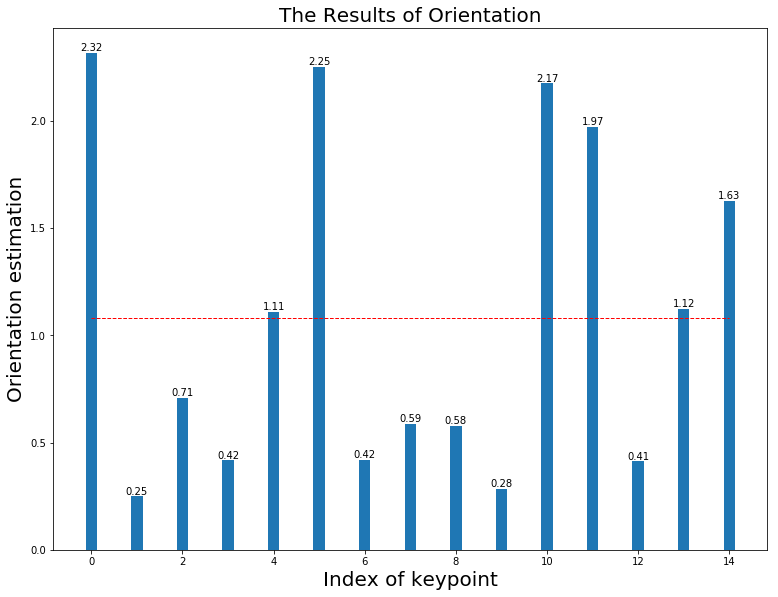

Final result: [     2.3169     0.24885     0.70868     0.41669      1.1083      2.2497     0.41988     0.58755     0.57787     0.28384      2.1739      1.9703     0.41229      1.1228      1.6271]
FD Rotate(1.9):mean(1.082), median(1.082) in 0.011
The HoG estimation when (1.9) is  2


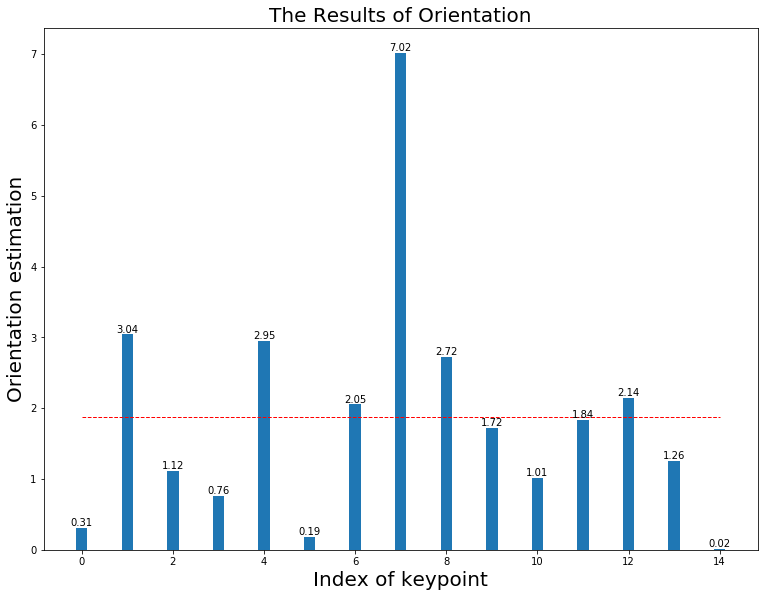

Final result: [    0.31226      3.0416       1.116     0.75957      2.9467     0.18735      2.0544      7.0191       2.724      1.7227      1.0114      1.8358      2.1422      1.2578    0.016342]
FD Rotate(2.0):mean(1.876), median(1.509) in 0.011
The HoG estimation when (2.0) is  2


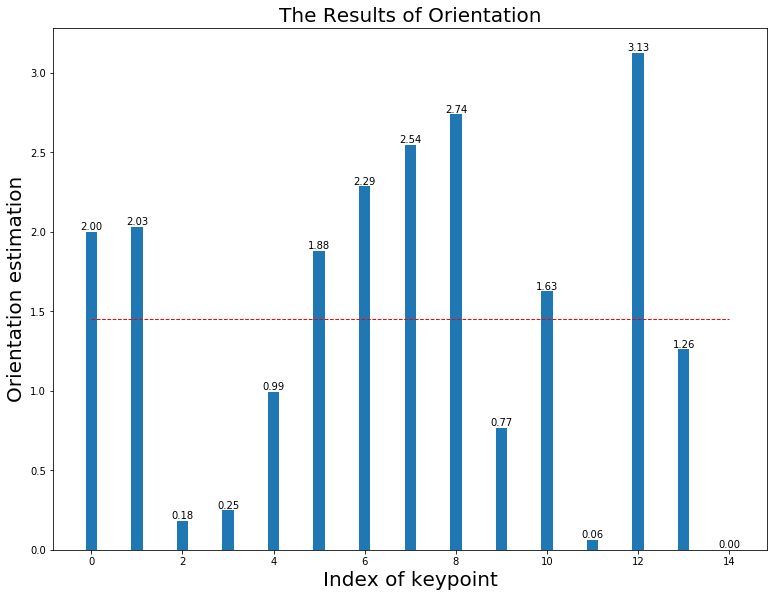

Final result: [      1.998      2.0323      0.1799     0.24796      0.9912      1.8817      2.2858      2.5444      2.7386     0.76693      1.6257    0.063488      3.1257       1.261   0.0014935]
FD Rotate(2.1):mean(1.450), median(1.450) in 0.011
The HoG estimation when (2.1) is  2


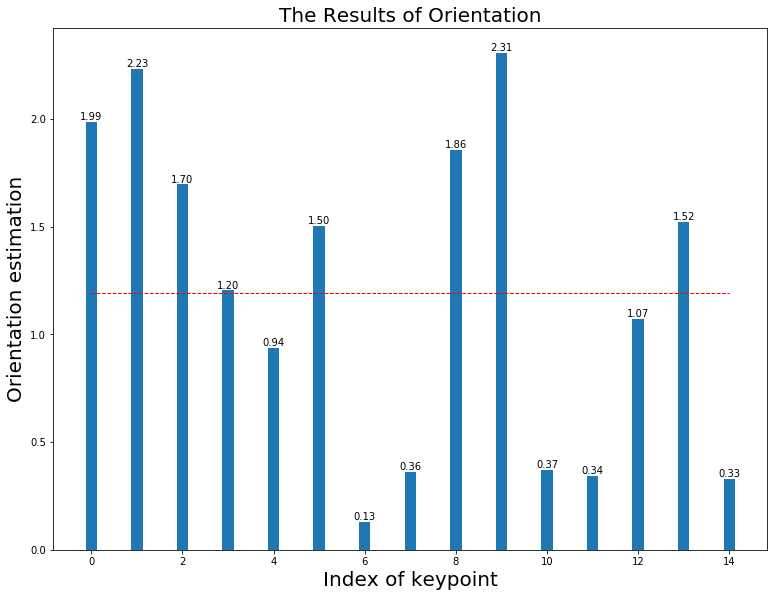

Final result: [     1.9878      2.2327      1.6965      1.2047      0.9389      1.5031     0.13006      0.3631      1.8581      2.3079     0.37095     0.34297      1.0728      1.5229     0.33055]
FD Rotate(2.2):mean(1.191), median(1.191) in 0.011
The HoG estimation when (2.2) is  2


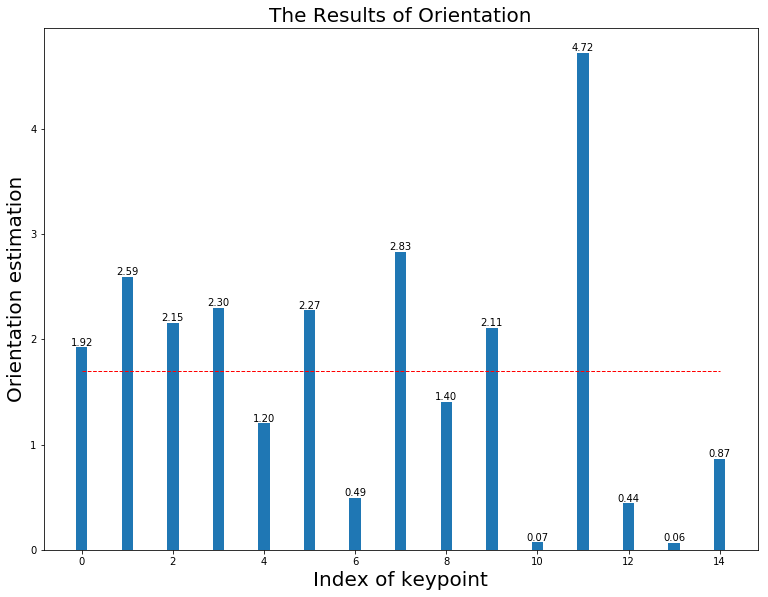

Final result: [     1.9217      2.5908      2.1521      2.3013      1.2016      2.2749     0.49475      2.8298      1.4035      2.1074    0.069885      4.7207     0.44073    0.063904      0.8665]
FD Rotate(2.3):mean(1.696), median(1.480) in 0.016
The HoG estimation when (2.3) is  2


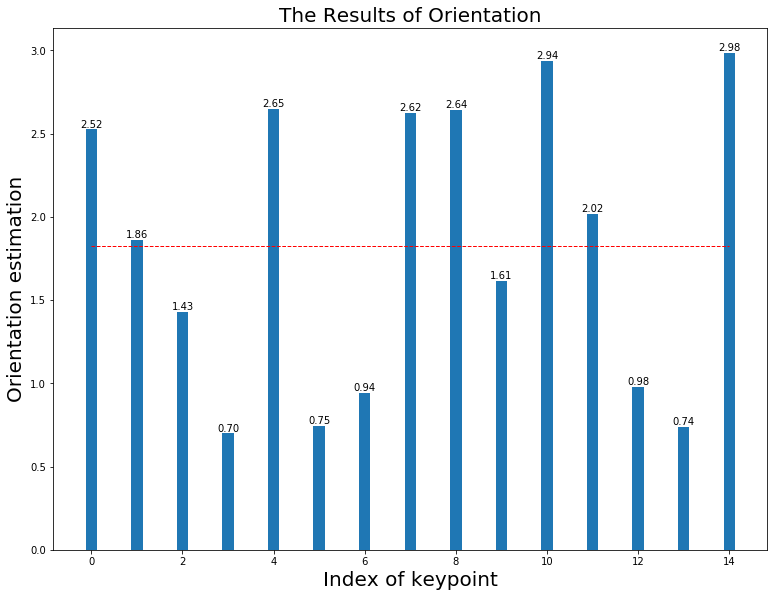

Final result: [     2.5249      1.8623      1.4295     0.69962       2.649     0.74567     0.94044      2.6237      2.6401      1.6148      2.9354      2.0193      0.9776     0.73928      2.9847]
FD Rotate(2.4):mean(1.826), median(1.826) in 0.011
The HoG estimation when (2.4) is  2


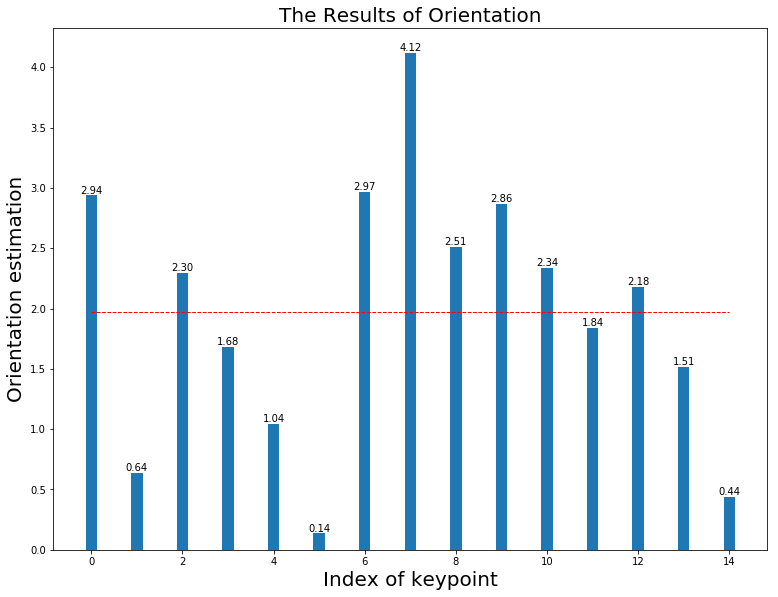

Final result: [     2.9374     0.63628      2.2971      1.6795      1.0432     0.13526      2.9652      4.1196      2.5125      2.8649      2.3354      1.8419      2.1815      1.5141     0.44064]
FD Rotate(2.5):mean(1.967), median(2.098) in 0.011
The HoG estimation when (2.5) is  3


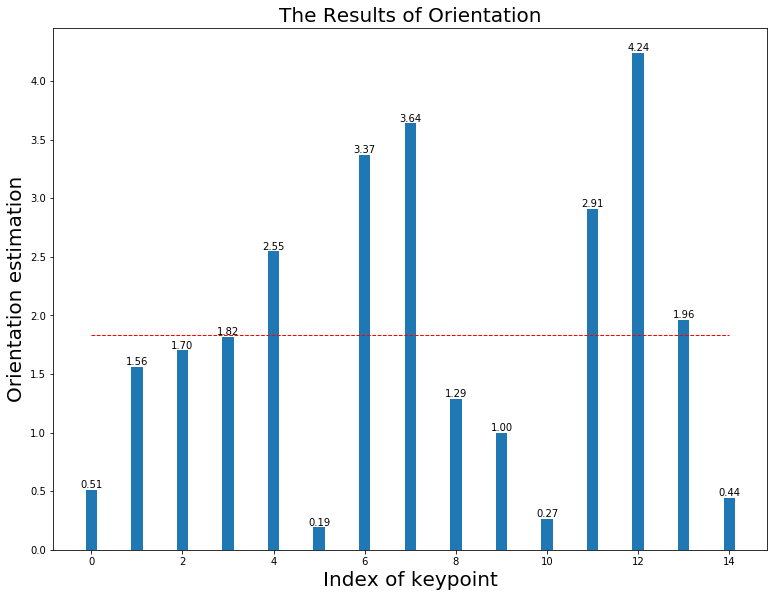

Final result: [    0.51219      1.5575      1.7004      1.8151      2.5452     0.19133      3.3687      3.6382      1.2875     0.99615     0.26555      2.9059      4.2397      1.9603     0.44438]
FD Rotate(2.6):mean(1.829), median(1.656) in 0.011
The HoG estimation when (2.6) is  3


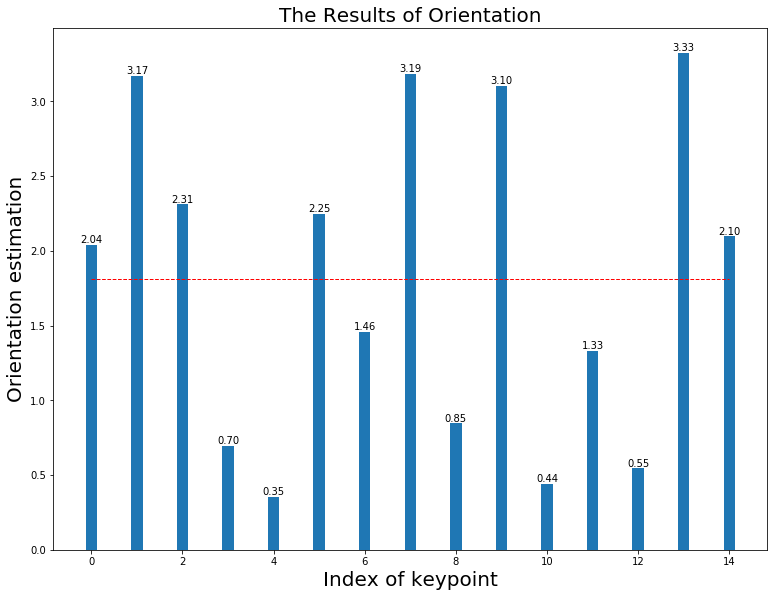

Final result: [     2.0421        3.17      2.3108     0.69521     0.35294       2.247      1.4603      3.1869      0.8455      3.1018     0.43881        1.33     0.54501      3.3254      2.0969]
FD Rotate(2.7):mean(1.810), median(1.810) in 0.011
The HoG estimation when (2.7) is  3


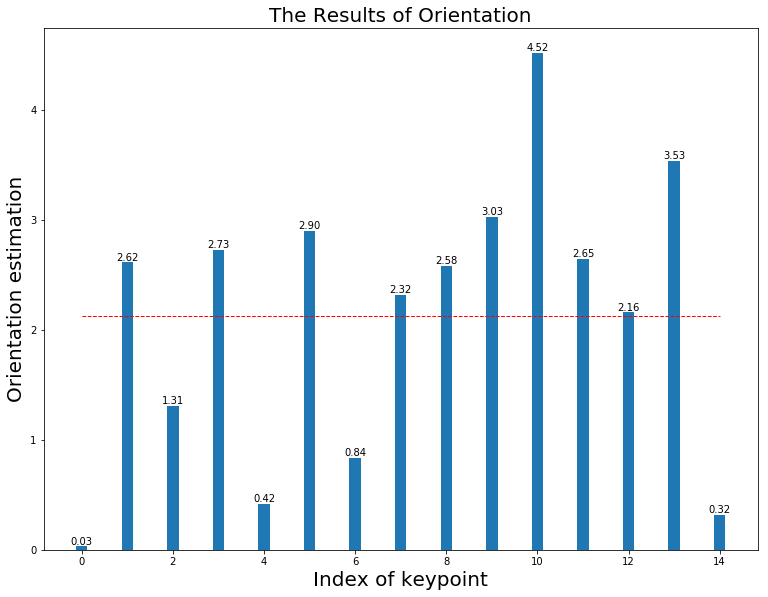

Final result: [   0.030773      2.6154      1.3122      2.7278      0.4193      2.9015     0.83676      2.3188      2.5829      3.0253      4.5208      2.6485      2.1606      3.5348     0.31812]
FD Rotate(2.8):mean(2.130), median(2.599) in 0.012
The HoG estimation when (2.8) is  3


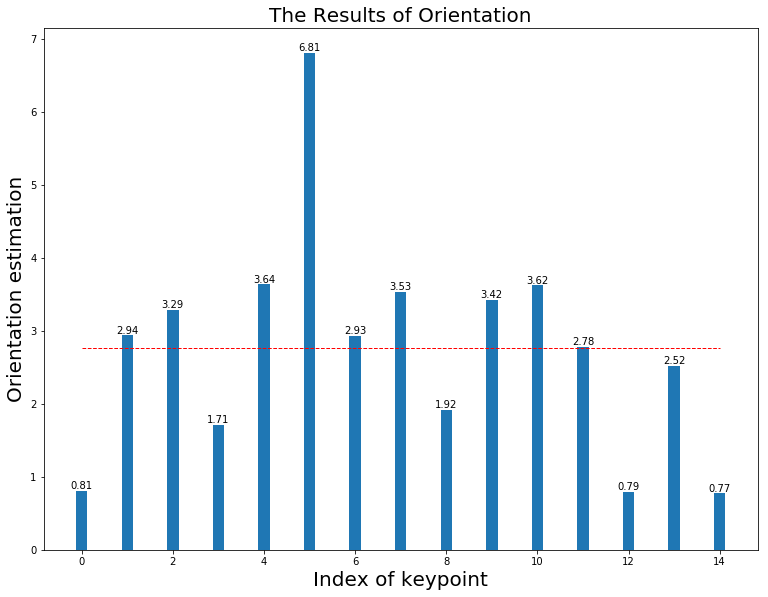

Final result: [    0.80849       2.937       3.287      1.7082      3.6364      6.8066      2.9299      3.5347      1.9157      3.4223      3.6225      2.7759      0.7948      2.5225     0.77176]
FD Rotate(2.9):mean(2.765), median(2.936) in 0.011
The HoG estimation when (2.9) is  3


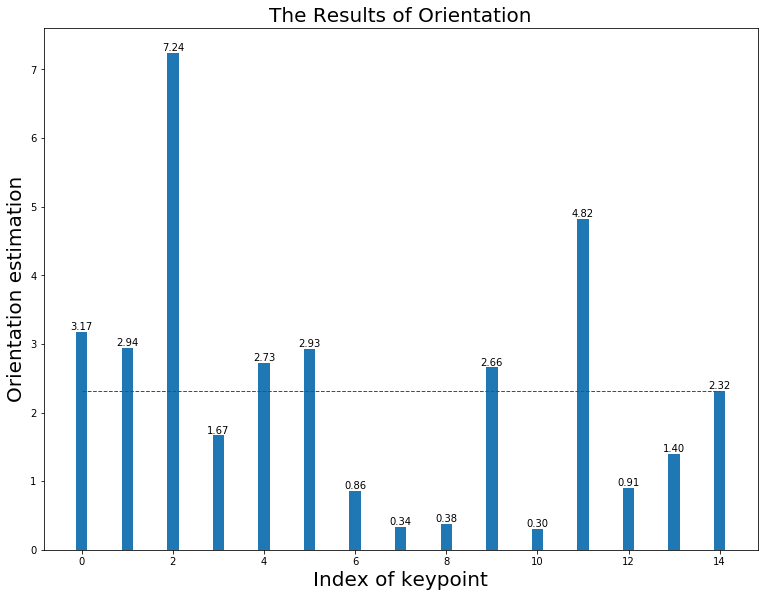

Final result: [     3.1724      2.9423      7.2432      1.6682      2.7284      2.9333     0.85925     0.33556     0.37825      2.6577     0.30188      4.8245     0.90689      1.4028      2.3208]
FD Rotate(3.0):mean(2.312), median(1.859) in 0.012
The HoG estimation when (3.0) is  3


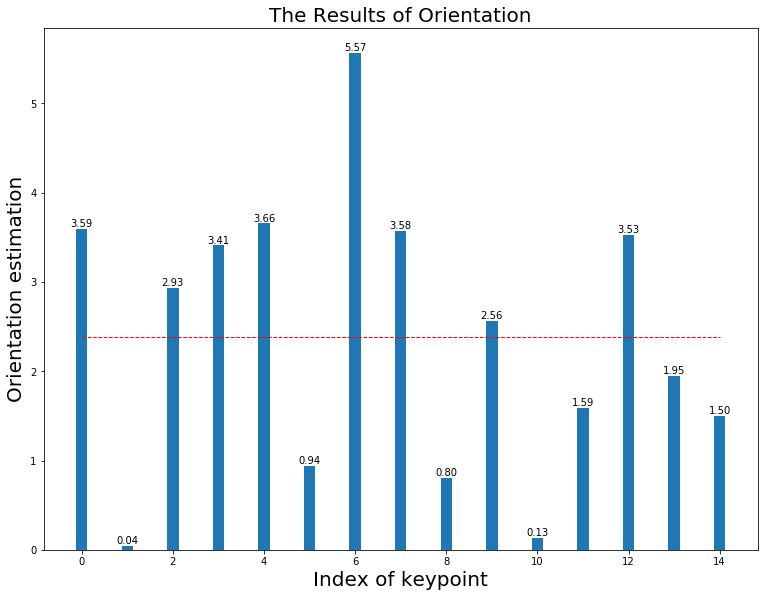

Final result: [     3.5914    0.040339      2.9306      3.4096      3.6565     0.94226      5.5679      3.5759     0.80389      2.5648     0.13232      1.5899      3.5256      1.9476      1.4978]
FD Rotate(3.1):mean(2.385), median(2.503) in 0.011
The HoG estimation when (3.1) is  3


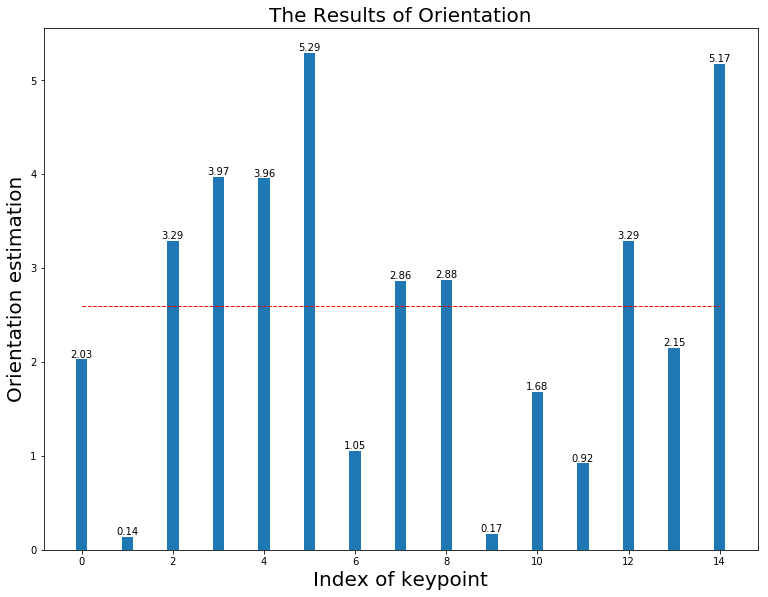

Final result: [     2.0287     0.14111       3.287      3.9741      3.9566       5.293       1.054      2.8635      2.8783     0.17328      1.6822     0.92102      3.2904      2.1536      5.1722]
FD Rotate(3.2):mean(2.591), median(2.554) in 0.011
The HoG estimation when (3.2) is  3


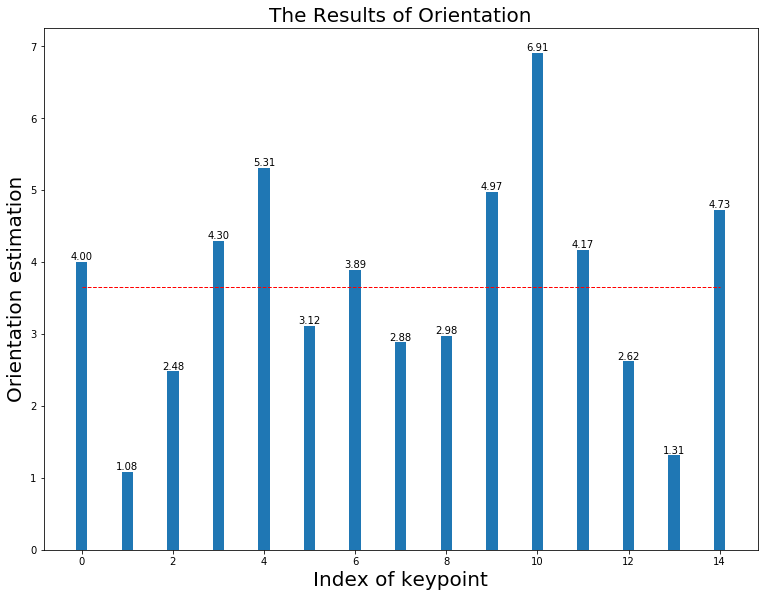

Final result: [     3.9999      1.0787      2.4793      4.2989      5.3072      3.1157      3.8882      2.8847      2.9786      4.9742       6.911      4.1705      2.6188      1.3115       4.731]
FD Rotate(3.3):mean(3.650), median(3.787) in 0.011
The HoG estimation when (3.3) is  3


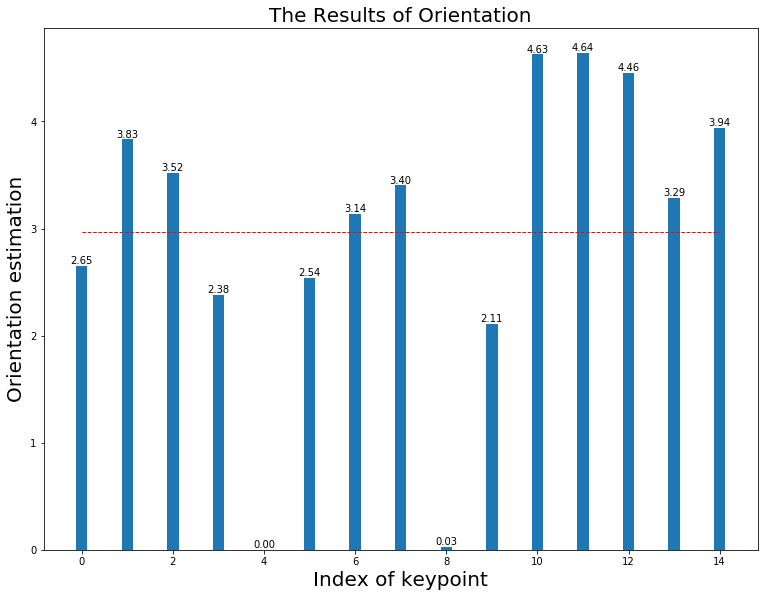

Final result: [     2.6536      3.8336      3.5208      2.3811   0.0026855      2.5368      3.1371      3.4027    0.025146      2.1112      4.6259      4.6409      4.4557      3.2863       3.939]
FD Rotate(3.4):mean(2.970), median(3.425) in 0.011
The HoG estimation when (3.4) is  3


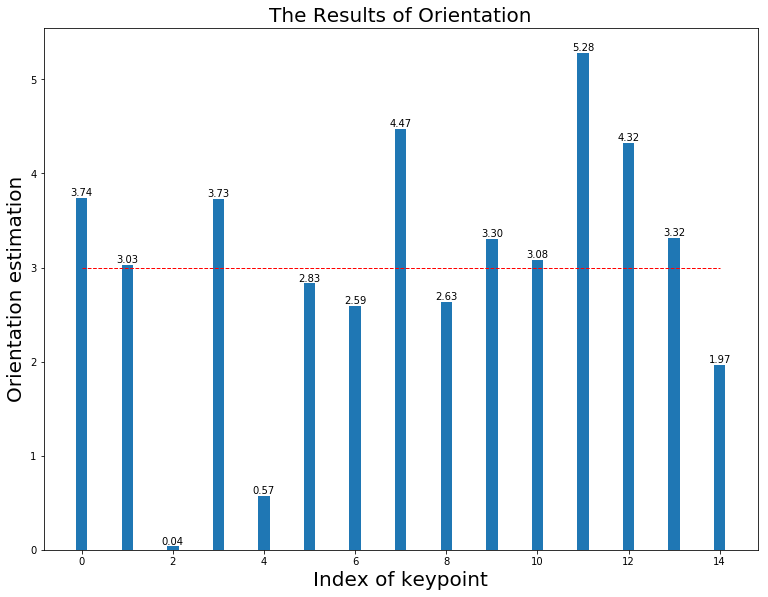

Final result: [     3.7398       3.027    0.036224       3.727      0.5741        2.83      2.5909      4.4711      2.6312      3.3023      3.0843      5.2817      4.3224       3.318      1.9689]
FD Rotate(3.5):mean(2.994), median(3.251) in 0.011
The HoG estimation when (3.5) is  3


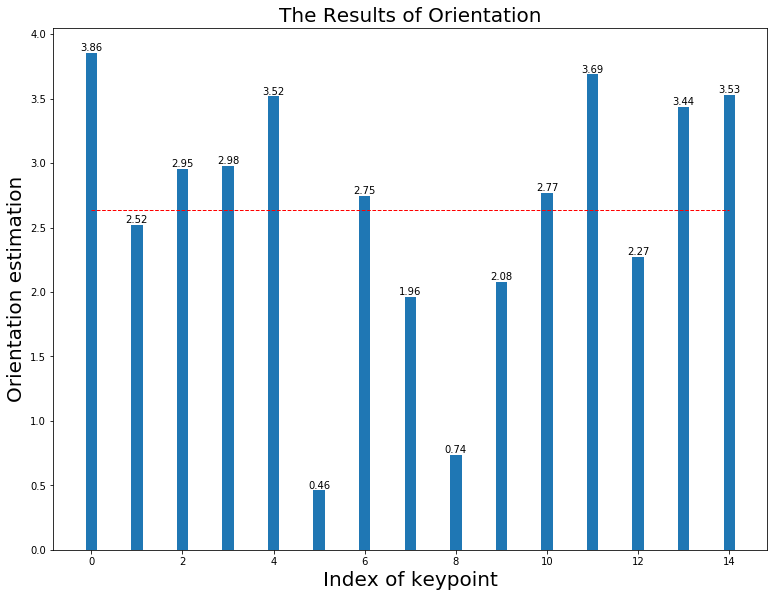

Final result: [     3.8553      2.5223       2.955      2.9785      3.5182      0.4613      2.7457      1.9629     0.73874      2.0807      2.7709      3.6869      2.2711       3.438      3.5271]
FD Rotate(3.6):mean(2.634), median(2.947) in 0.012
The HoG estimation when (3.6) is  4


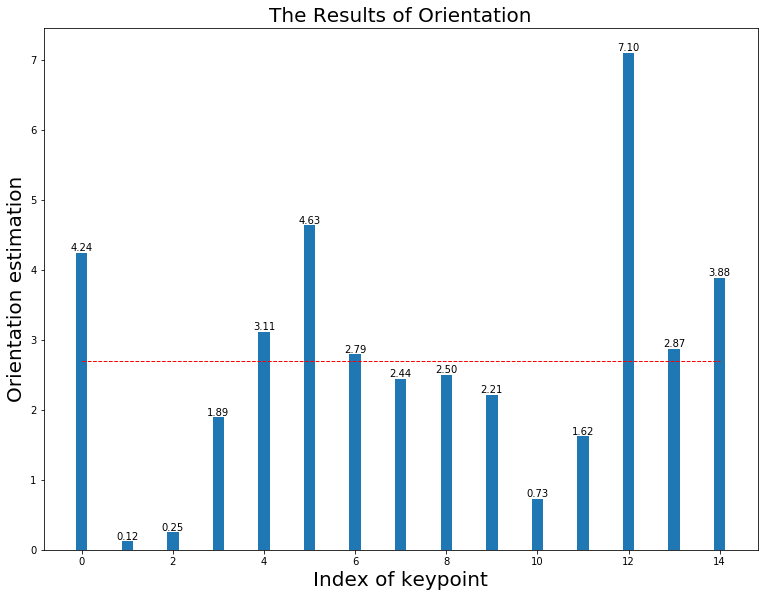

Final result: [     4.2441     0.11926      0.2486      1.8899      3.1144      4.6338      2.7918      2.4438      2.5006       2.213      0.7251      1.6201      7.0993      2.8715      3.8816]
FD Rotate(3.7):mean(2.693), median(2.572) in 0.011
The HoG estimation when (3.7) is  4


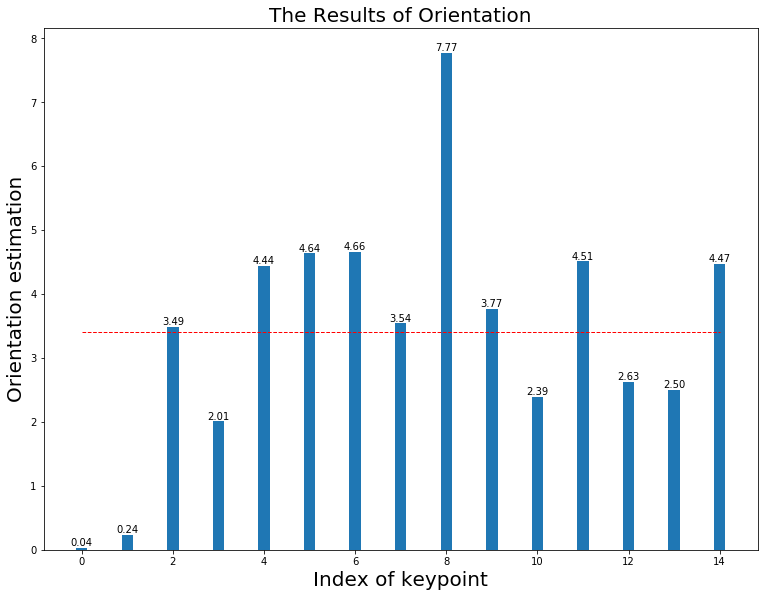

Final result: [   0.035049     0.23797      3.4906      2.0084       4.443      4.6354      4.6565      3.5421      7.7739      3.7705      2.3931       4.513      2.6274      2.4963      4.4734]
FD Rotate(3.8):mean(3.406), median(3.587) in 0.012
The HoG estimation when (3.8) is  4


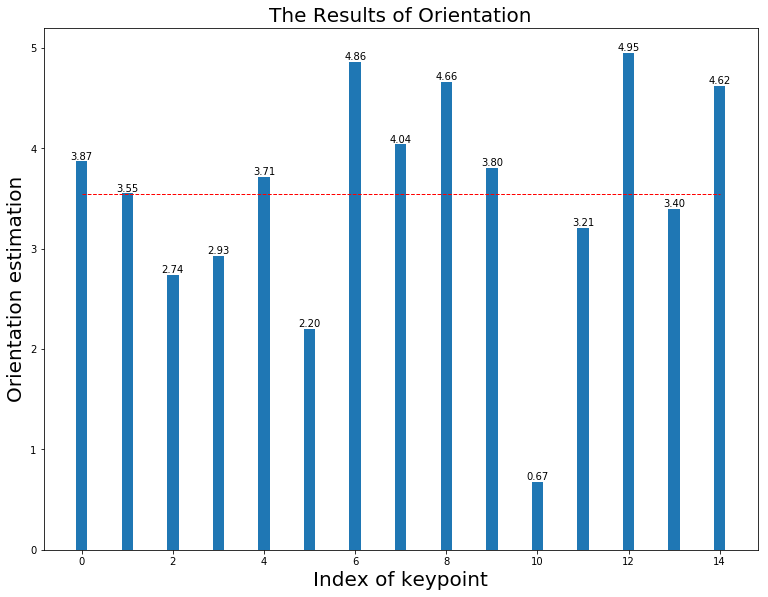

Final result: [     3.8712      3.5504      2.7426      2.9264      3.7139      2.1996       4.859      4.0396      4.6619      3.8048     0.67419      3.2103      4.9518         3.4      4.6212]
FD Rotate(3.9):mean(3.548), median(3.754) in 0.012
The HoG estimation when (3.9) is  4


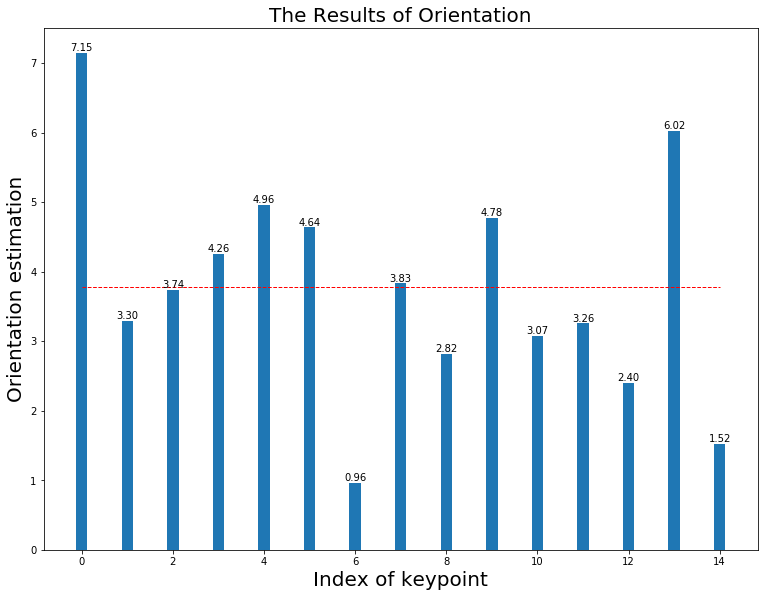

Final result: [     7.1464      3.2957      3.7399      4.2559      4.9585      4.6376     0.96226      3.8299      2.8195      4.7754      3.0724      3.2575      2.4022      6.0243      1.5208]
FD Rotate(4.0):mean(3.780), median(3.731) in 0.011
The HoG estimation when (4.0) is  4


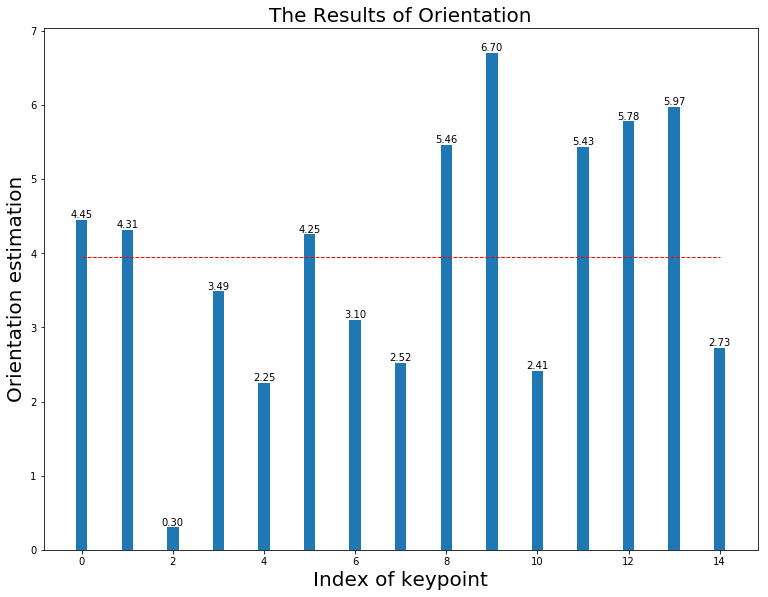

Final result: [     4.4487      4.3136     0.30127       3.487      2.2472      4.2541      3.1021      2.5225       5.463      6.7045      2.4121      5.4341       5.779      5.9746      2.7269]
FD Rotate(4.1):mean(3.945), median(4.160) in 0.011
The HoG estimation when (4.1) is  4


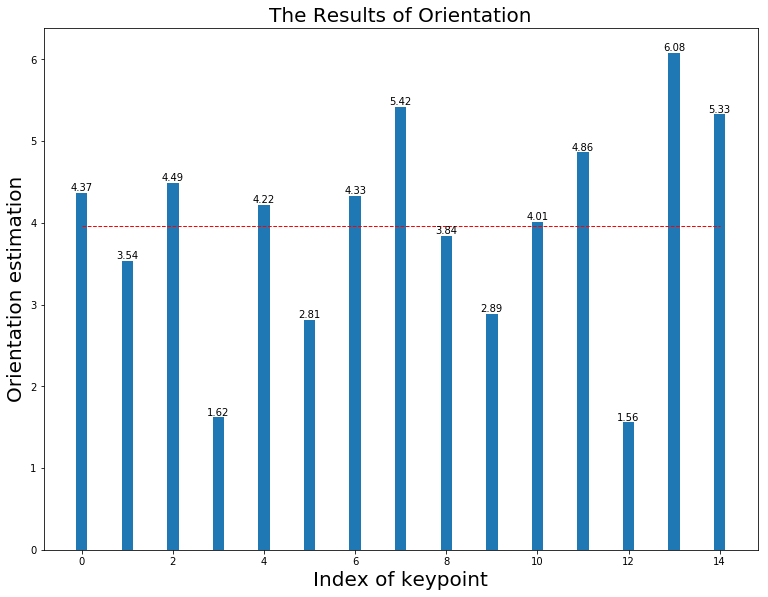

Final result: [     4.3688        3.54      4.4899      1.6192      4.2171      2.8132      4.3305      5.4205      3.8425      2.8891      4.0097      4.8643      1.5594      6.0818      5.3289]
FD Rotate(4.2):mean(3.958), median(4.323) in 0.012
The HoG estimation when (4.2) is  4


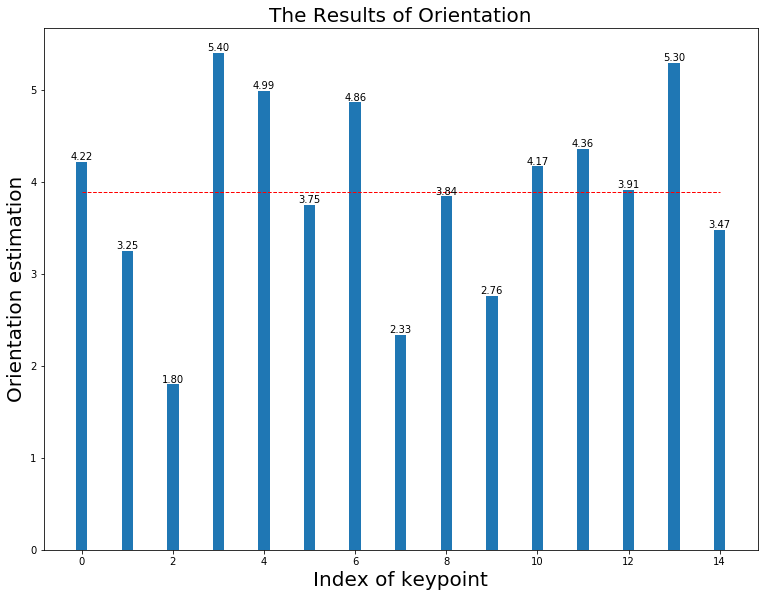

Final result: [     4.2186      3.2475      1.7975      5.4024      4.9895       3.751      4.8625      2.3331      3.8429      2.7594      4.1674      4.3586      3.9109      5.2968      3.4745]
FD Rotate(4.3):mean(3.894), median(4.044) in 0.012
The HoG estimation when (4.3) is  4


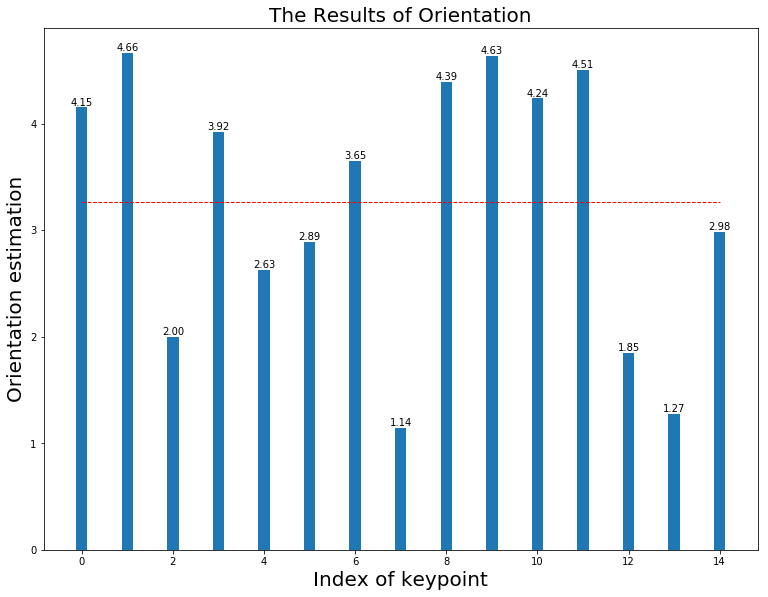

Final result: [      4.152      4.6649      2.0017      3.9206       2.628      2.8878      3.6516      1.1421      4.3943      4.6335      4.2362      4.5062      1.8489      1.2745      2.9816]
FD Rotate(4.4):mean(3.262), median(3.577) in 0.012
The HoG estimation when (4.4) is  5


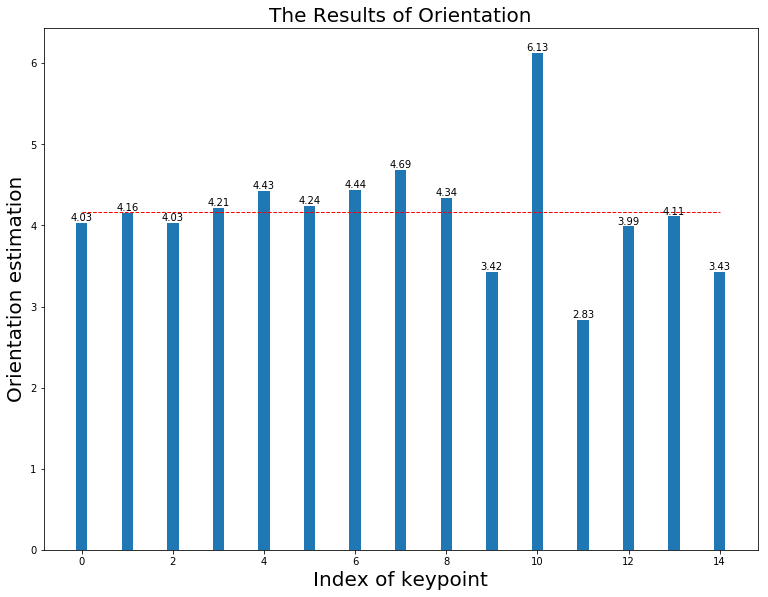

Final result: [     4.0294      4.1561      4.0283      4.2128      4.4263      4.2407      4.4428      4.6868      4.3378      3.4246      6.1289       2.831      3.9892      4.1118      3.4282]
FD Rotate(4.5):mean(4.165), median(4.165) in 0.012
The HoG estimation when (4.5) is  5


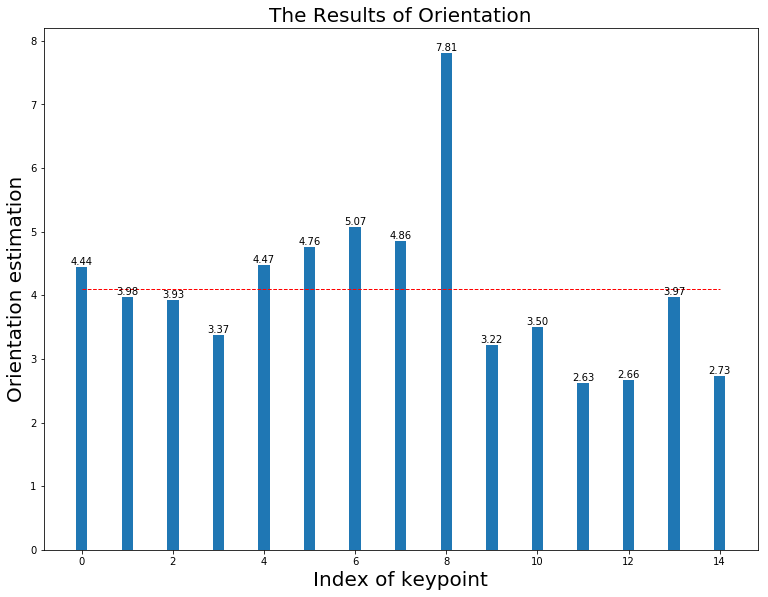

Final result: [     4.4424      3.9786      3.9294      3.3718      4.4723      4.7589      5.0712      4.8585      7.8094      3.2221      3.5006      2.6254      2.6645      3.9693      2.7317]
FD Rotate(4.6):mean(4.094), median(3.828) in 0.012
The HoG estimation when (4.6) is  5


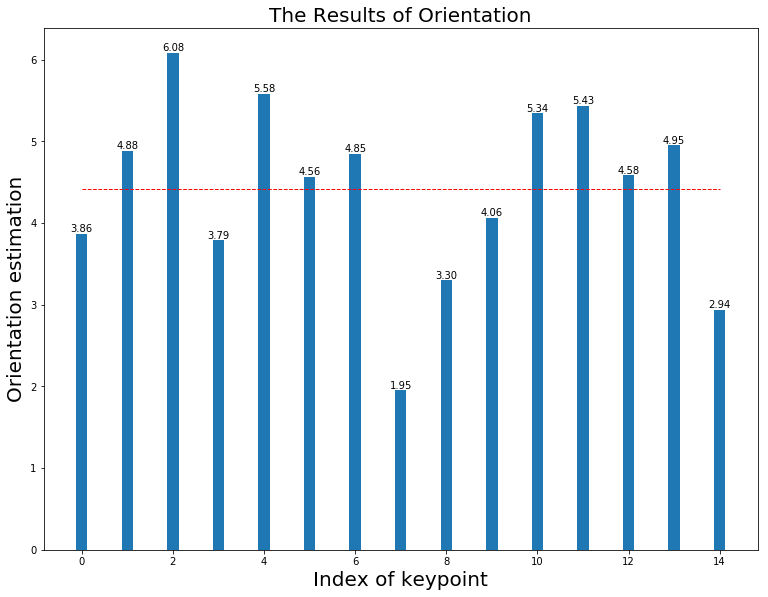

Final result: [      3.863      4.8834      6.0828      3.7869      5.5801      4.5624      4.8483      1.9498      3.2965      4.0615      5.3404      5.4327      4.5819      4.9495      2.9388]
FD Rotate(4.7):mean(4.411), median(4.586) in 0.011
The HoG estimation when (4.7) is  5


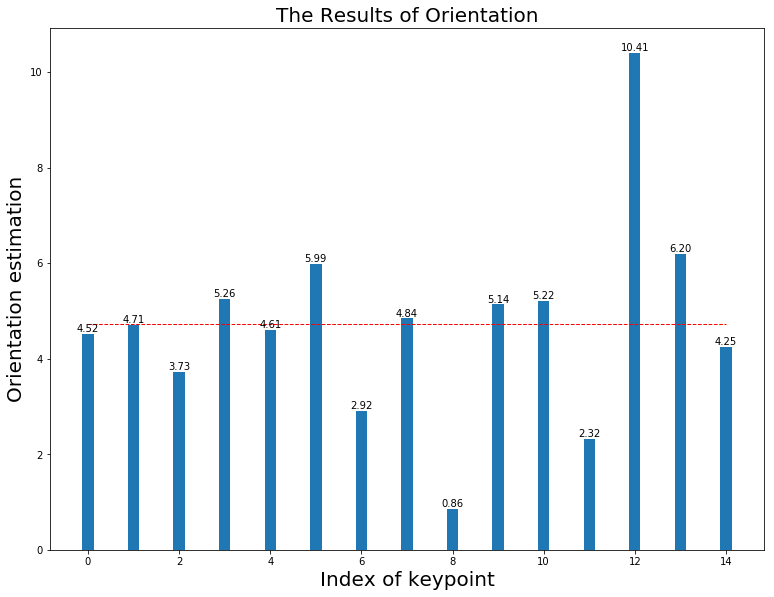

Final result: [      4.516      4.7141      3.7315      5.2604      4.6074      5.9883       2.916      4.8441     0.86199      5.1388      5.2182      2.3159      10.406      6.1971       4.249]
FD Rotate(4.8):mean(4.731), median(4.782) in 0.011
The HoG estimation when (4.8) is  5


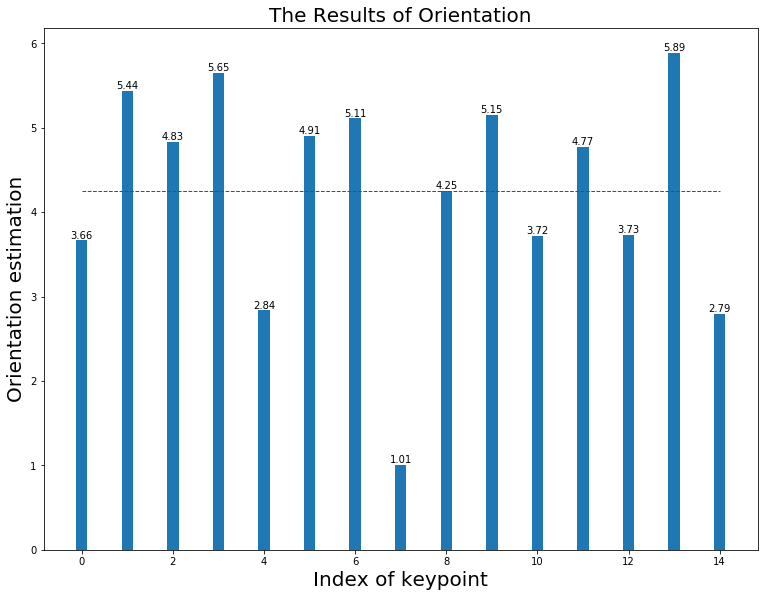

Final result: [     3.6643      5.4363      4.8327      5.6514      2.8356      4.9066      5.1121      1.0102      4.2513       5.154      3.7205      4.7708      3.7298      5.8878      2.7937]
FD Rotate(4.9):mean(4.250), median(4.482) in 0.012
The HoG estimation when (4.9) is  5


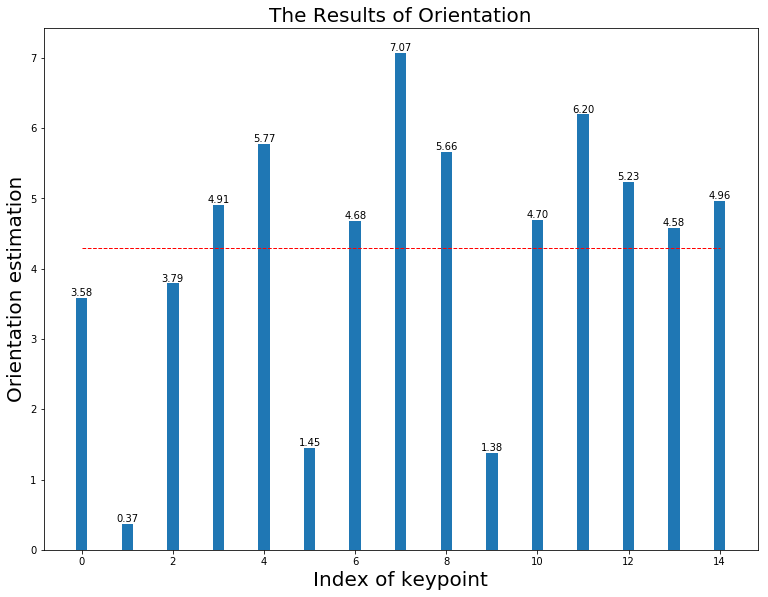

Final result: [     3.5797     0.37156      3.7894      4.9118       5.775      1.4457      4.6822      7.0717      5.6644      1.3788      4.6978       6.197      5.2307      4.5842       4.961]
FD Rotate(5.0):mean(4.289), median(4.916) in 0.011
The HoG estimation when (5.0) is  5


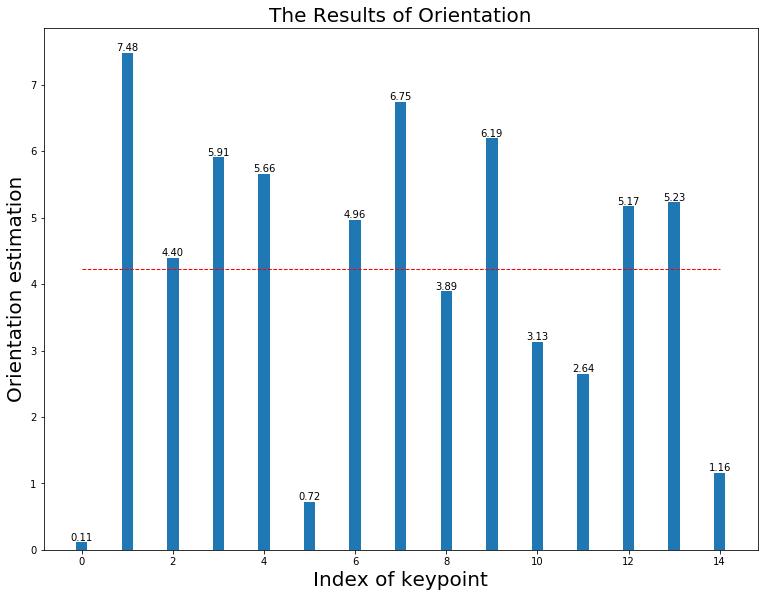

Final result: [    0.11015      7.4818      4.3965      5.9086      5.6625     0.72485      4.9614      6.7461      3.8892       6.192      3.1294       2.644      5.1709      5.2318      1.1603]
FD Rotate(5.1):mean(4.227), median(5.129) in 0.011
The HoG estimation when (5.1) is  5


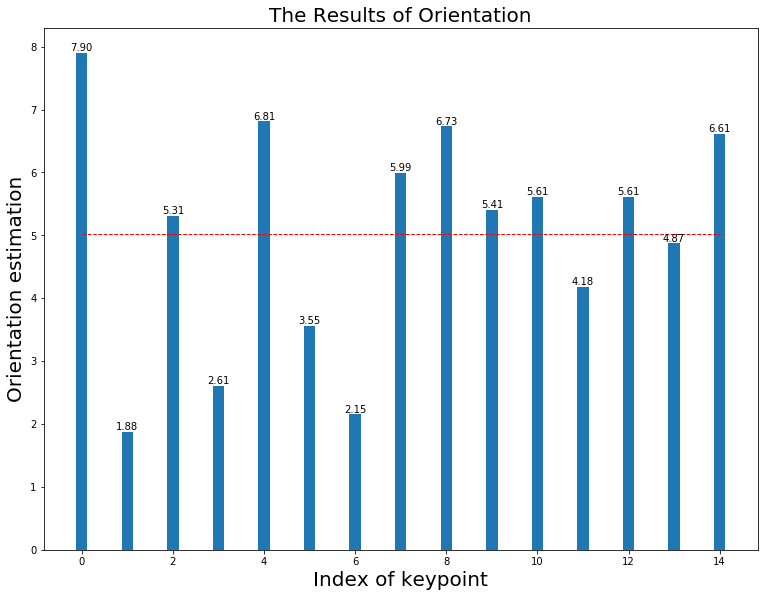

Final result: [     7.9021      1.8794      5.3141      2.6096      6.8116      3.5546      2.1543      5.9876      6.7332      5.4092      5.6089      4.1768      5.6118       4.873      6.6081]
FD Rotate(5.2):mean(5.016), median(5.517) in 0.011
The HoG estimation when (5.2) is  5


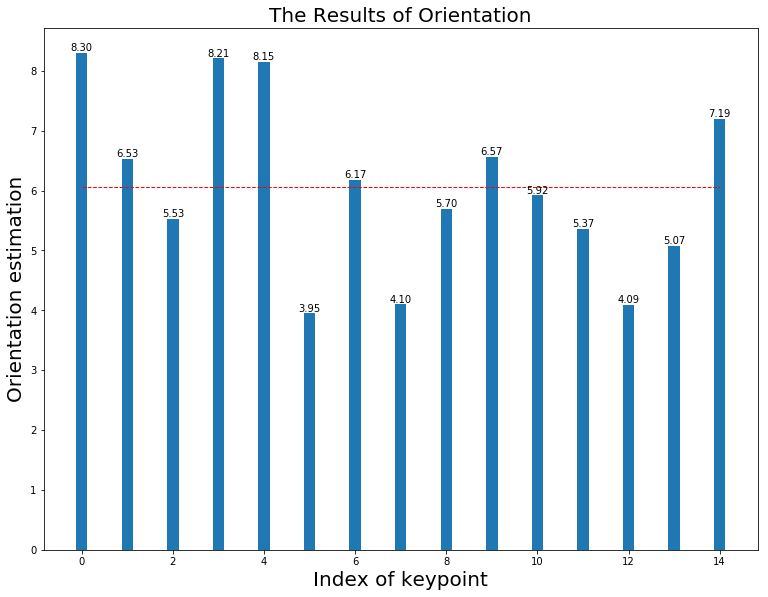

Final result: [      8.301      6.5349      5.5257      8.2059      8.1492      3.9502      6.1747      4.0997       5.698      6.5686      5.9189      5.3654      4.0921      5.0717      7.1916]
FD Rotate(5.3):mean(6.057), median(5.516) in 0.012
The HoG estimation when (5.3) is  5


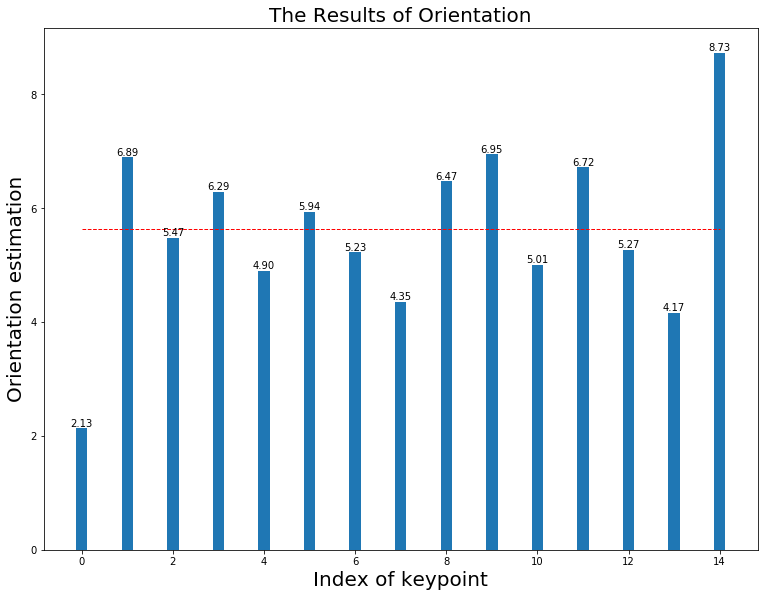

Final result: [     2.1345       6.894       5.474      6.2861      4.8965      5.9395      5.2254      4.3536      6.4741      6.9464      5.0094      6.7177      5.2691      4.1677      8.7308]
FD Rotate(5.4):mean(5.635), median(5.666) in 0.012
The HoG estimation when (5.4) is  5


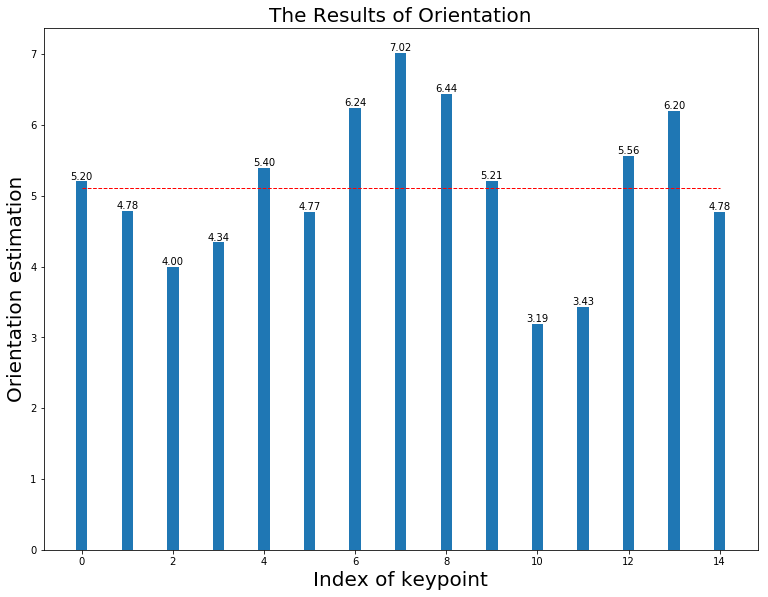

Final result: [     5.2025      4.7842       3.996      4.3428      5.3969      4.7718      6.2415      7.0201      6.4439      5.2103      3.1921      3.4325        5.56      6.1953       4.775]
FD Rotate(5.5):mean(5.104), median(5.241) in 0.011
The HoG estimation when (5.5) is  6


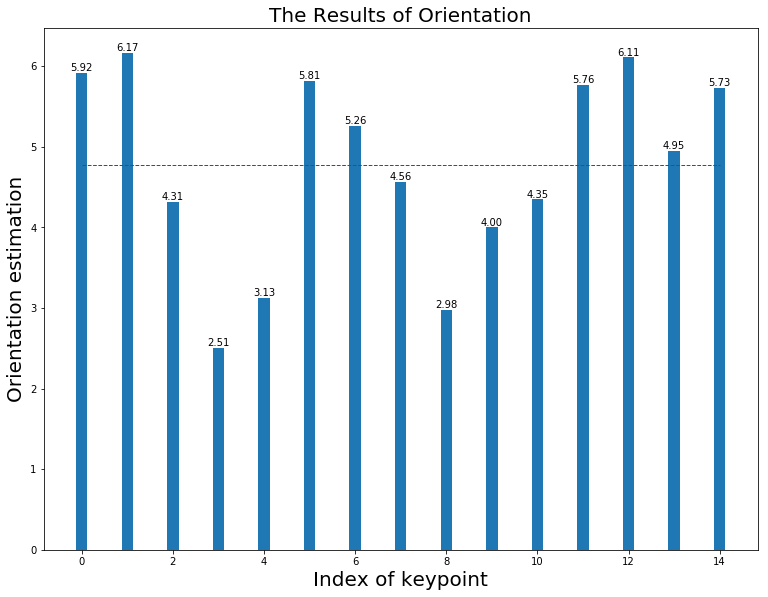

Final result: [     5.9181      6.1657      4.3126      2.5092      3.1279      5.8137      5.2608      4.5601      2.9809      4.0002      4.3468      5.7631      6.1073      4.9512      5.7331]
FD Rotate(5.6):mean(4.770), median(4.932) in 0.011
The HoG estimation when (5.6) is  6


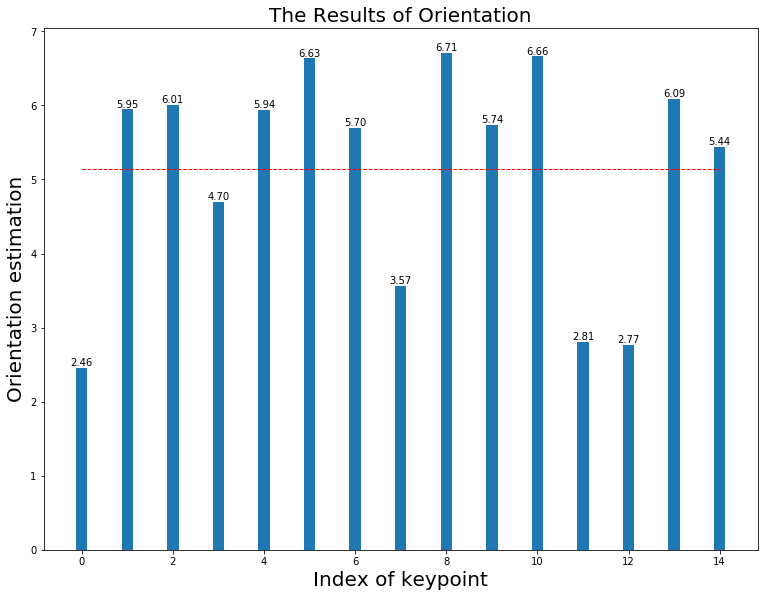

Final result: [     2.4596      5.9455      6.0114       4.696      5.9413      6.6347      5.7015      3.5662      6.7108      5.7379      6.6633      2.8091       2.767      6.0915      5.4433]
FD Rotate(5.7):mean(5.145), median(5.962) in 0.012
The HoG estimation when (5.7) is  6


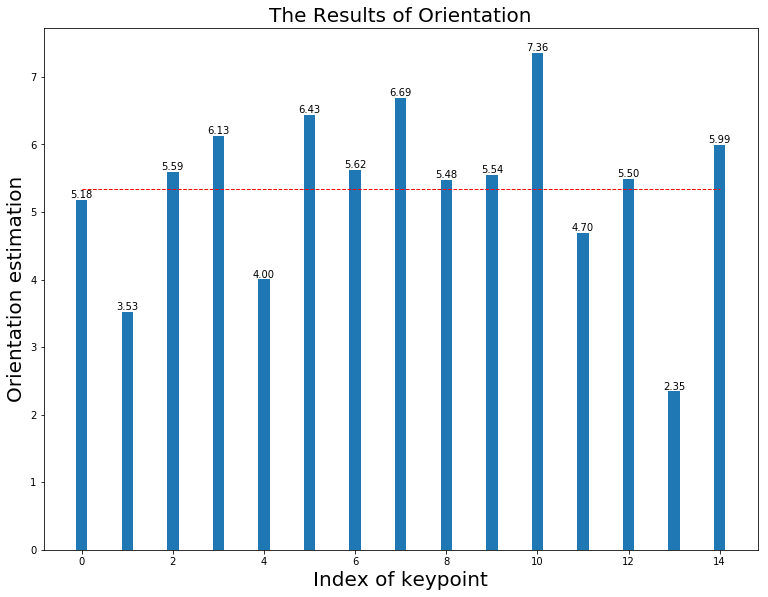

Final result: [     5.1759      3.5257      5.5935      6.1291      4.0032      6.4319      5.6187      6.6944      5.4795      5.5439      7.3561      4.6953      5.4951      2.3458      5.9933]
FD Rotate(5.8):mean(5.339), median(5.708) in 0.012
The HoG estimation when (5.8) is  6


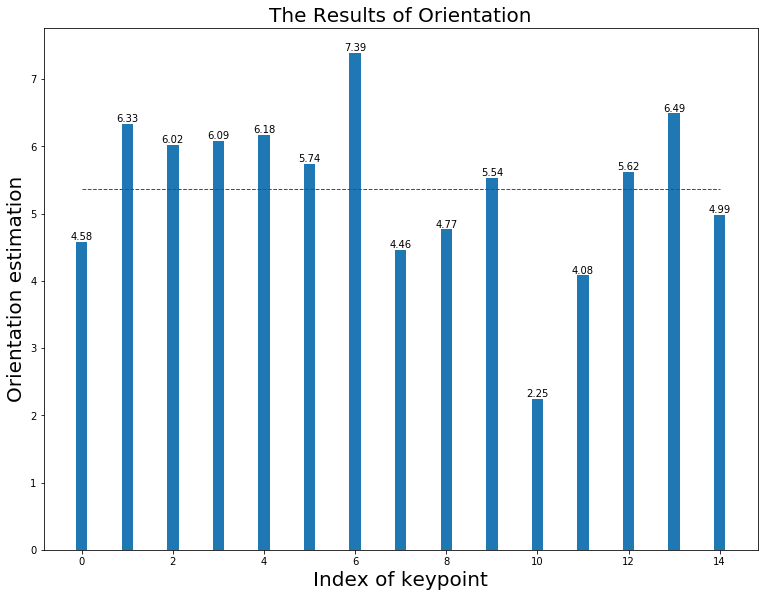

Final result: [     4.5791      6.3319      6.0223      6.0862      6.1753      5.7376      7.3934      4.4593      4.7668      5.5355      2.2453       4.082      5.6175      6.4905      4.9857]
FD Rotate(5.9):mean(5.367), median(5.590) in 0.012
The HoG estimation when (5.9) is  6


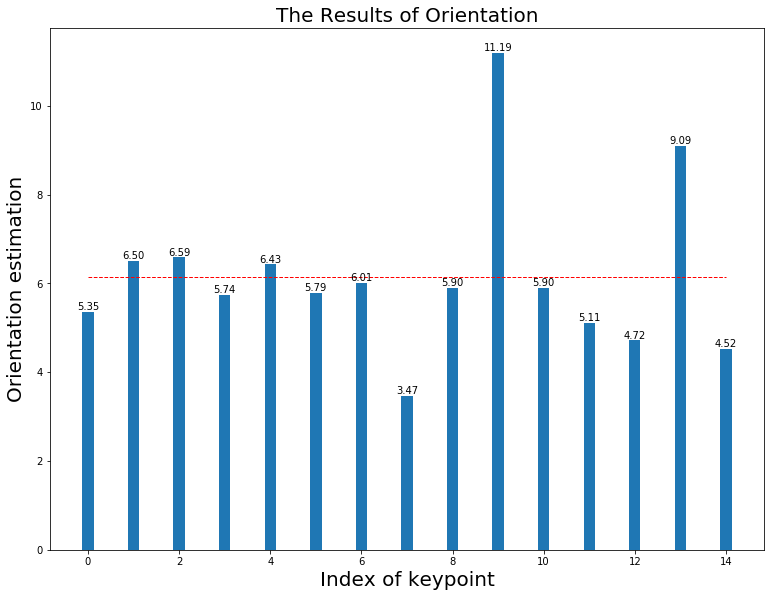

Final result: [      5.352      6.5029      6.5874      5.7373       6.428      5.7928      6.0139      3.4669      5.9022      11.193      5.8995      5.1103       4.716      9.0939      4.5193]
FD Rotate(6.0):mean(6.154), median(5.713) in 0.011
The HoG estimation when (6.0) is  6


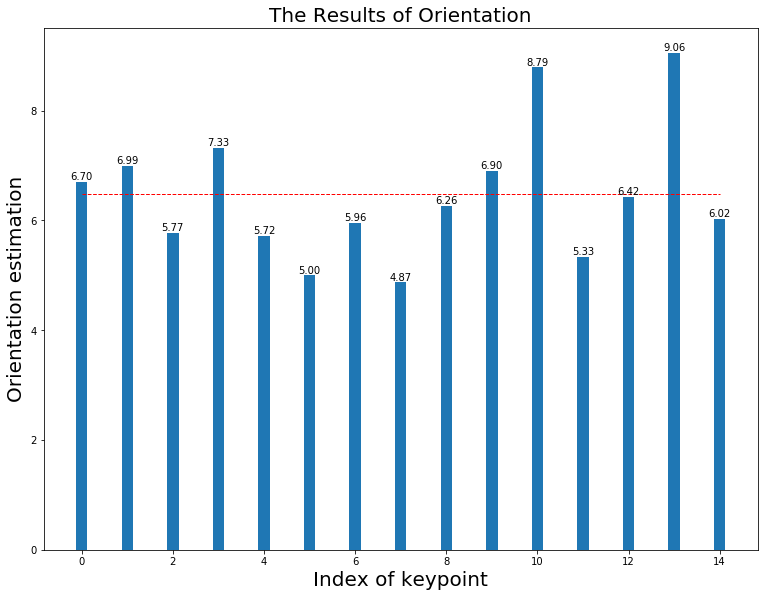

Final result: [     6.6978      6.9935      5.7748      7.3275       5.719      5.0017      5.9577      4.8743      6.2625      6.9027      8.7875      5.3315      6.4245      9.0554      6.0231]
FD Rotate(6.1):mean(6.476), median(6.099) in 0.011
The HoG estimation when (6.1) is  6


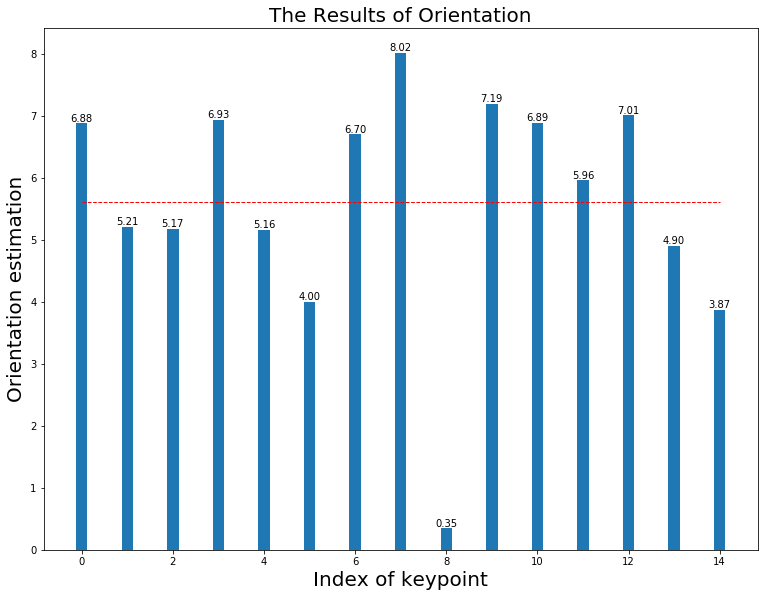

Final result: [     6.8789      5.2058      5.1707      6.9341      5.1648      4.0013      6.7009      8.0164     0.34566      7.1926      6.8892      5.9589      7.0088      4.9019      3.8694]
FD Rotate(6.2):mean(5.616), median(6.001) in 0.012
The HoG estimation when (6.2) is  6


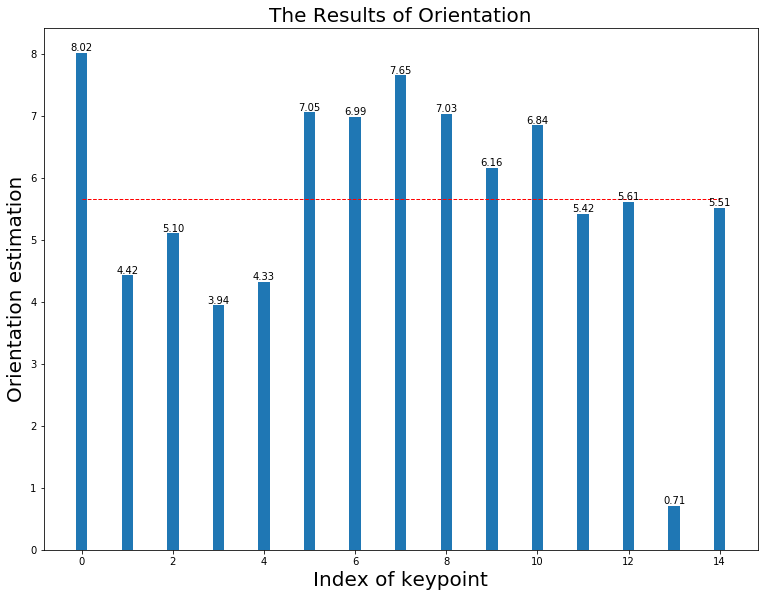

Final result: [     8.0173      4.4248      5.1038      3.9443      4.3258      7.0547      6.9878      7.6527      7.0286      6.1578      6.8448      5.4217       5.607     0.71259      5.5149]
FD Rotate(6.3):mean(5.653), median(5.701) in 0.012
The HoG estimation when (6.3) is  6


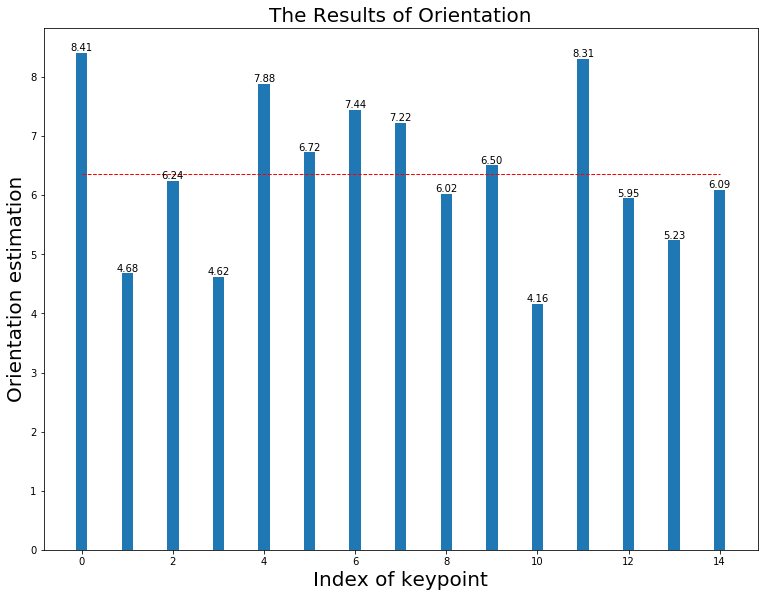

Final result: [     8.4099      4.6775      6.2424      4.6168      7.8786      6.7239      7.4424      7.2208       6.021      6.5039      4.1602      8.3051      5.9482      5.2342      6.0886]
FD Rotate(6.4):mean(6.365), median(6.217) in 0.011
The HoG estimation when (6.4) is  6


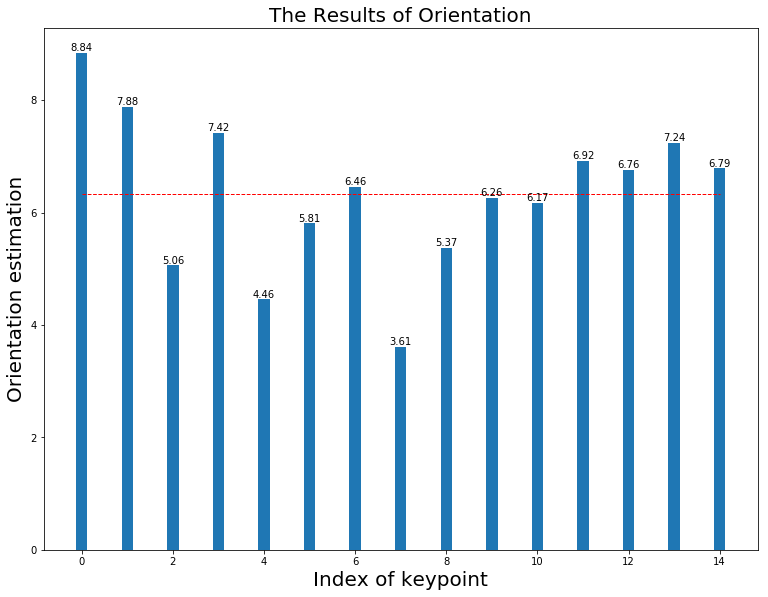

Final result: [     8.8429      7.8758      5.0623      7.4162      4.4574      5.8081      6.4627      3.6094      5.3701      6.2552      6.1673      6.9229      6.7552      7.2447      6.7853]
FD Rotate(6.5):mean(6.336), median(6.510) in 0.011
The HoG estimation when (6.5) is  7


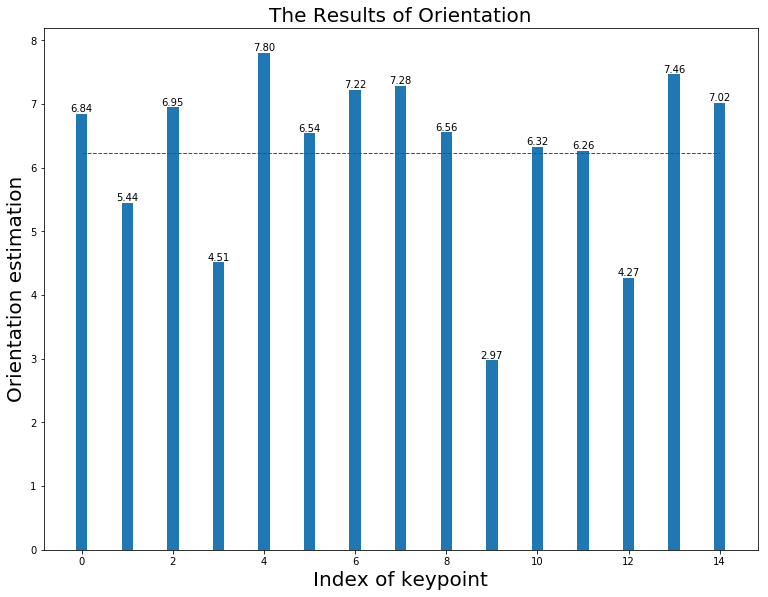

Final result: [     6.8419      5.4434      6.9472      4.5146      7.8039      6.5377      7.2159      7.2806      6.5562      2.9724       6.321      6.2649      4.2695      7.4639      7.0154]
FD Rotate(6.6):mean(6.230), median(6.808) in 0.012
The HoG estimation when (6.6) is  7


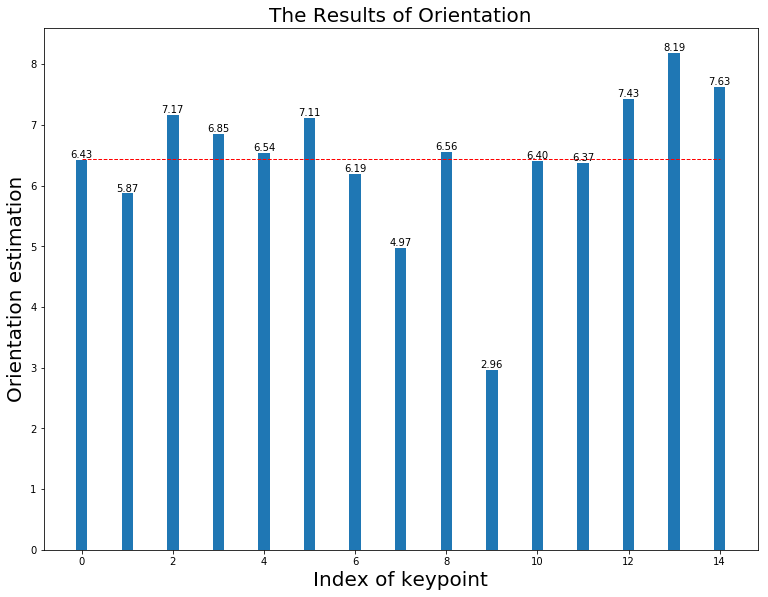

Final result: [     6.4271      5.8718       7.166      6.8489      6.5363      7.1148      6.1869      4.9712      6.5587      2.9637      6.4029      6.3707      7.4268      8.1867      7.6272]
FD Rotate(6.7):mean(6.444), median(6.693) in 0.011
The HoG estimation when (6.7) is  7


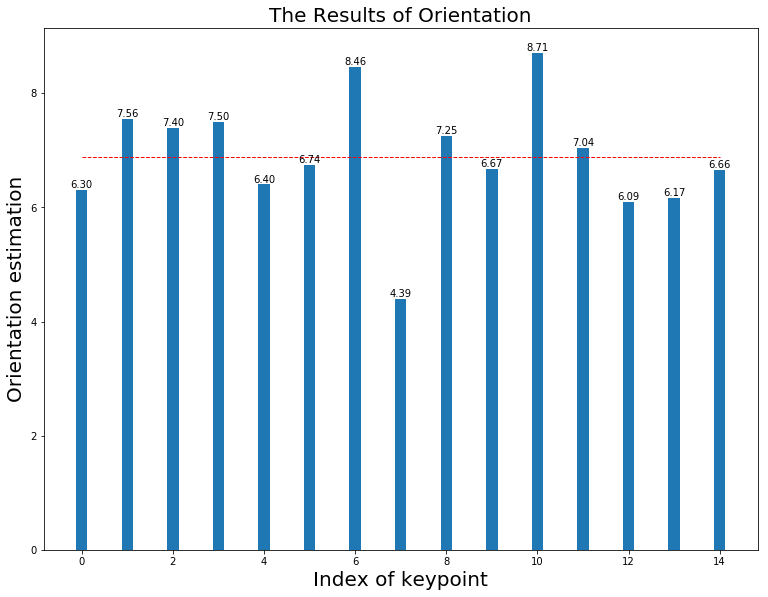

Final result: [     6.3008      7.5564      7.3951      7.5015      6.4041      6.7445      8.4634      4.3929      7.2534      6.6743      8.7084      7.0414      6.0948      6.1651      6.6624]
FD Rotate(6.8):mean(6.891), median(7.069) in 0.011
The HoG estimation when (6.8) is  7


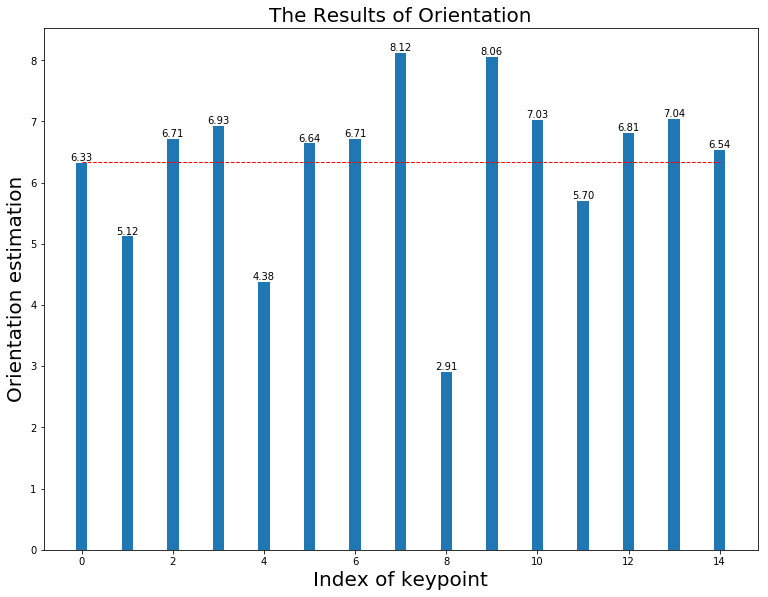

Final result: [     6.3273      5.1205      6.7122      6.9256      4.3774      6.6421       6.715      8.1221      2.9097      8.0596      7.0265       5.705      6.8114      7.0442      6.5406]
FD Rotate(6.9):mean(6.336), median(6.750) in 0.011
The HoG estimation when (6.9) is  7


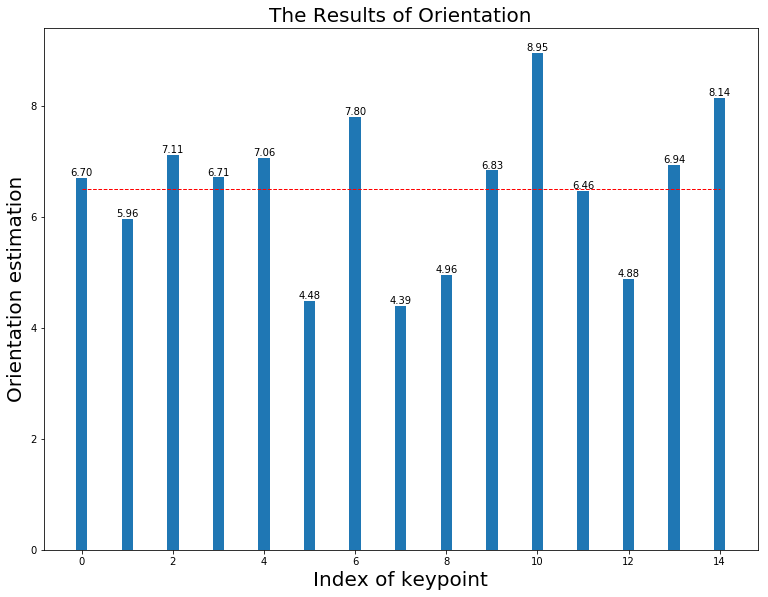

Final result: [     6.7003      5.9561      7.1089      6.7092      7.0637      4.4775       7.795      4.3944      4.9561      6.8348      8.9517      6.4636      4.8816      6.9386       8.139]
FD Rotate(7.0):mean(6.491), median(6.629) in 0.012
The HoG estimation when (7.0) is  7


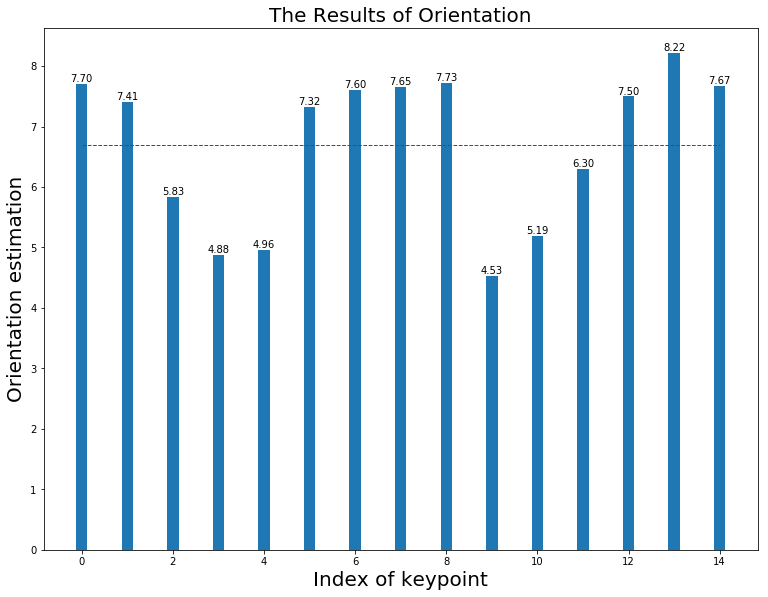

Final result: [     7.6991      7.4099      5.8339      4.8817      4.9613      7.3239      7.6029      7.6538      7.7258      4.5271      5.1882      6.2951      7.5001      8.2191      7.6689]
FD Rotate(7.1):mean(6.699), median(7.358) in 0.011
The HoG estimation when (7.1) is  7


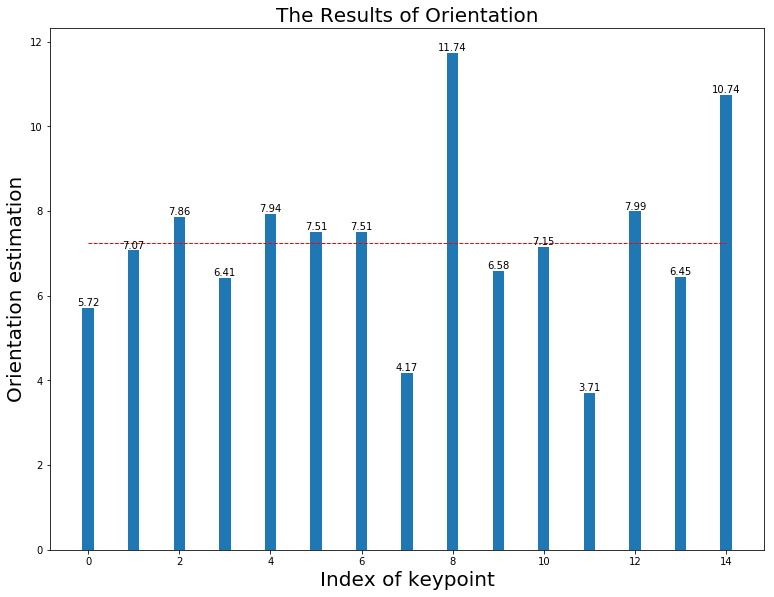

Final result: [     5.7195      7.0731      7.8586      6.4141      7.9372      7.5083      7.5066      4.1744      11.737       6.583      7.1502      3.7108      7.9939      6.4503      10.745]
FD Rotate(7.2):mean(7.237), median(7.109) in 0.011
The HoG estimation when (7.2) is  7


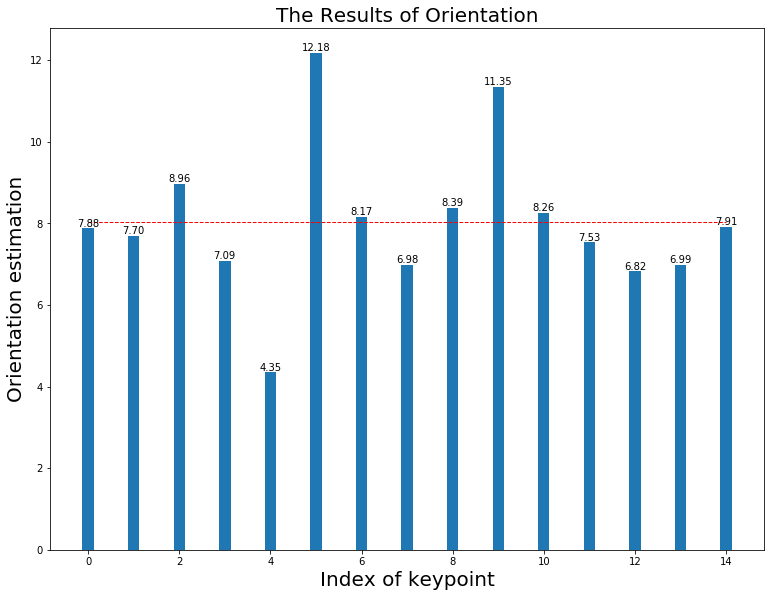

Final result: [      7.879      7.6996      8.9621      7.0888      4.3453       12.18      8.1675      6.9788      8.3852      11.353      8.2632      7.5313      6.8244       6.987      7.9114]
FD Rotate(7.3):mean(8.037), median(7.723) in 0.012
The HoG estimation when (7.3) is  7


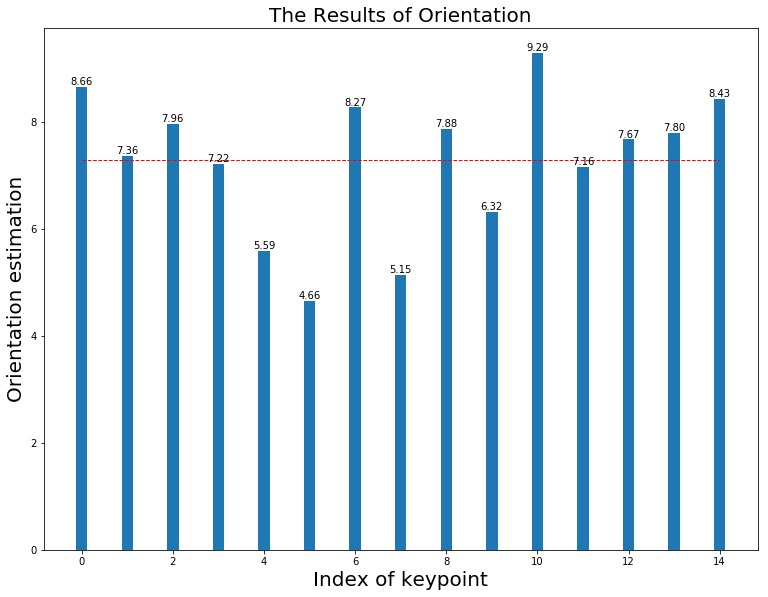

Final result: [     8.6617      7.3612        7.96      7.2217       5.589      4.6554      8.2745      5.1472      7.8767      6.3222      9.2929      7.1645      7.6731      7.8013      8.4324]
FD Rotate(7.4):mean(7.296), median(7.837) in 0.011
The HoG estimation when (7.4) is  8


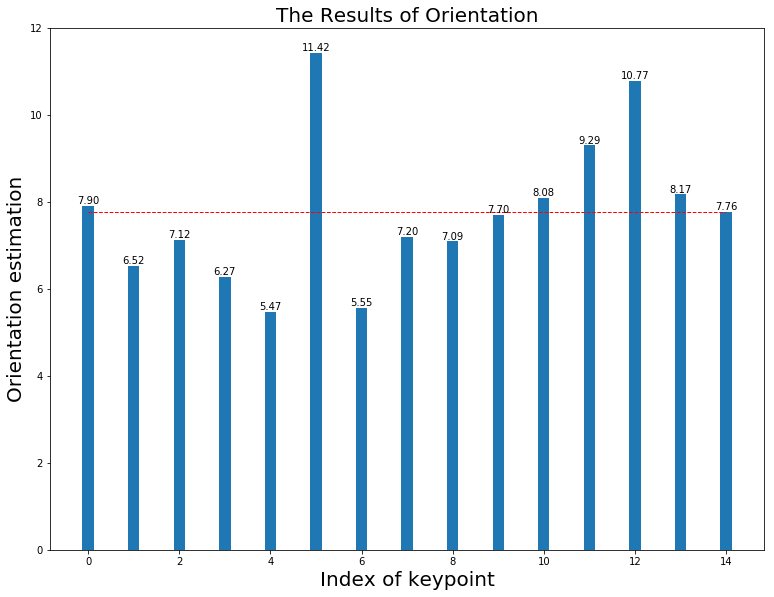

Final result: [     7.9018      6.5184      7.1194      6.2691      5.4738      11.422      5.5518      7.1962       7.086      7.7011      8.0844      9.2942      10.768      8.1708      7.7626]
FD Rotate(7.5):mean(7.755), median(7.555) in 0.012
The HoG estimation when (7.5) is  8


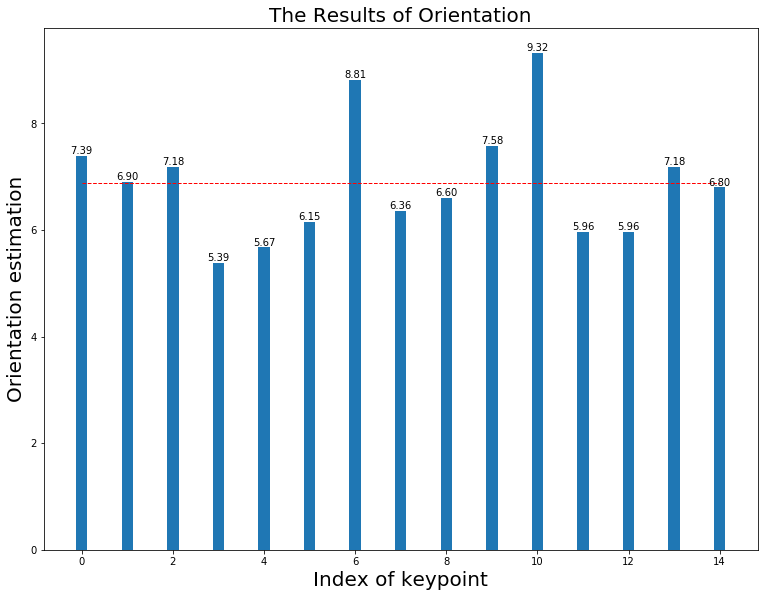

Final result: [     7.3919      6.9014       7.183      5.3854      5.6734      6.1536      8.8111      6.3629      6.6048       7.576      9.3217      5.9617      5.9584      7.1817      6.7995]
FD Rotate(7.6):mean(6.884), median(6.549) in 0.011
The HoG estimation when (7.6) is  8


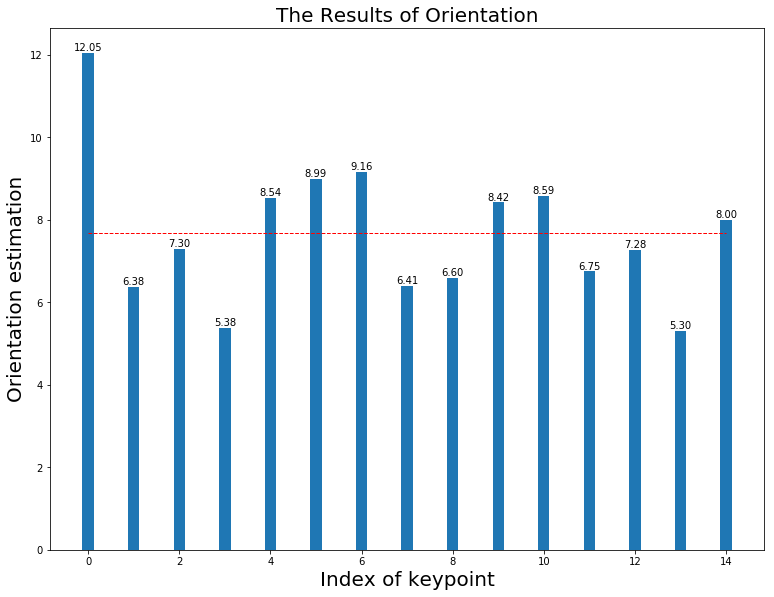

Final result: [      12.05       6.382      7.3011      5.3842      8.5362      8.9902      9.1609      6.4073      6.5956      8.4216      8.5857      6.7527      7.2805       5.303      7.9963]
FD Rotate(7.7):mean(7.677), median(7.364) in 0.012
The HoG estimation when (7.7) is  8


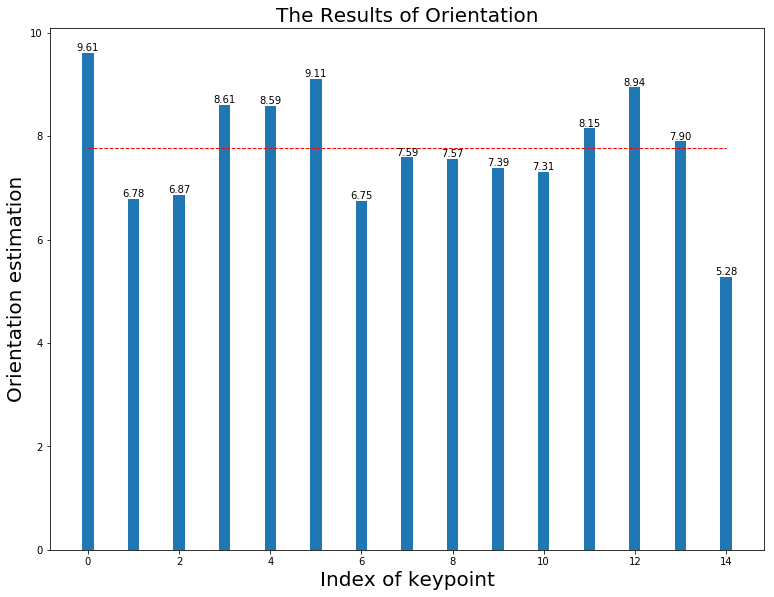

Final result: [     9.6135       6.782      6.8651      8.6055      8.5871      9.1065      6.7522      7.5915      7.5659      7.3864      7.3135      8.1521      8.9443      7.8985      5.2784]
FD Rotate(7.8):mean(7.763), median(7.812) in 0.011
The HoG estimation when (7.8) is  8


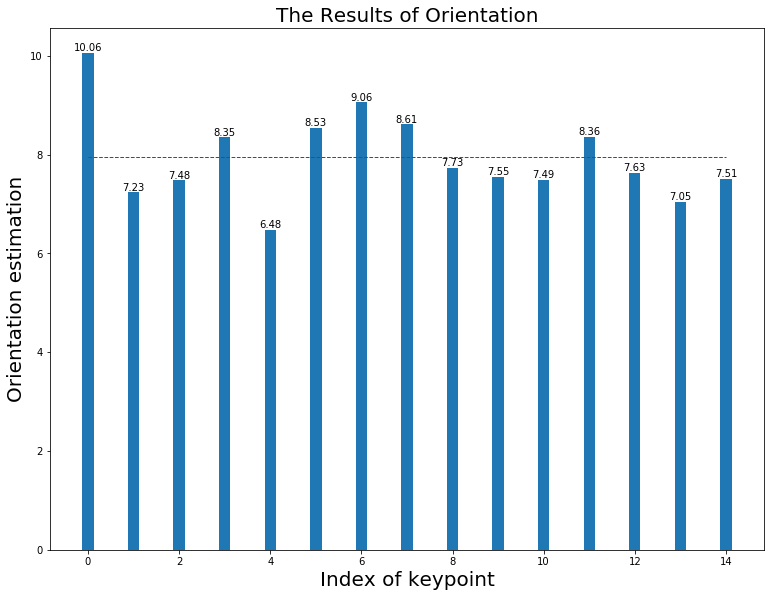

Final result: [      10.06      7.2331      7.4759      8.3487      6.4817      8.5329      9.0573      8.6093      7.7313       7.554       7.491      8.3563      7.6309      7.0491      7.5141]
FD Rotate(7.9):mean(7.942), median(7.790) in 0.023
The HoG estimation when (7.9) is  8


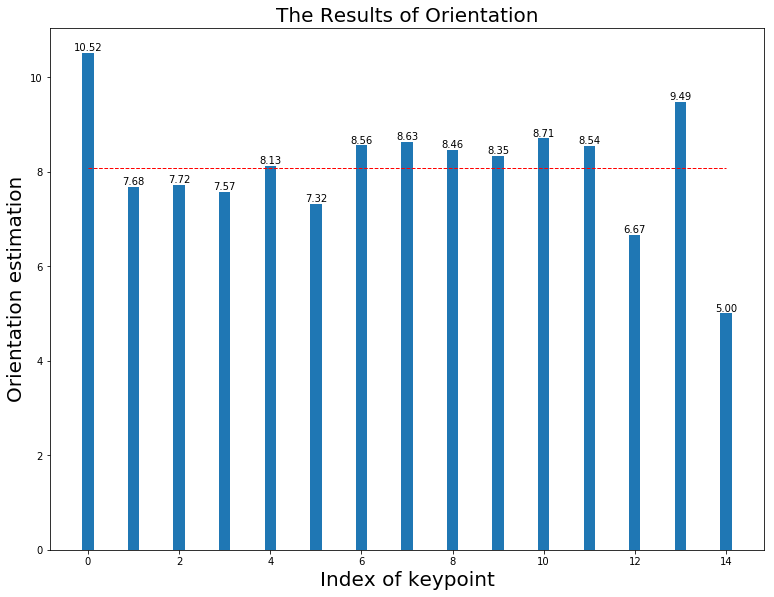

Final result: [      10.52      7.6757      7.7171      7.5713      8.1263      7.3167      8.5617      8.6349      8.4594      8.3462      8.7094       8.543      6.6671      9.4884      5.0042]
FD Rotate(8.0):mean(8.089), median(8.140) in 0.011
The HoG estimation when (8.0) is  8


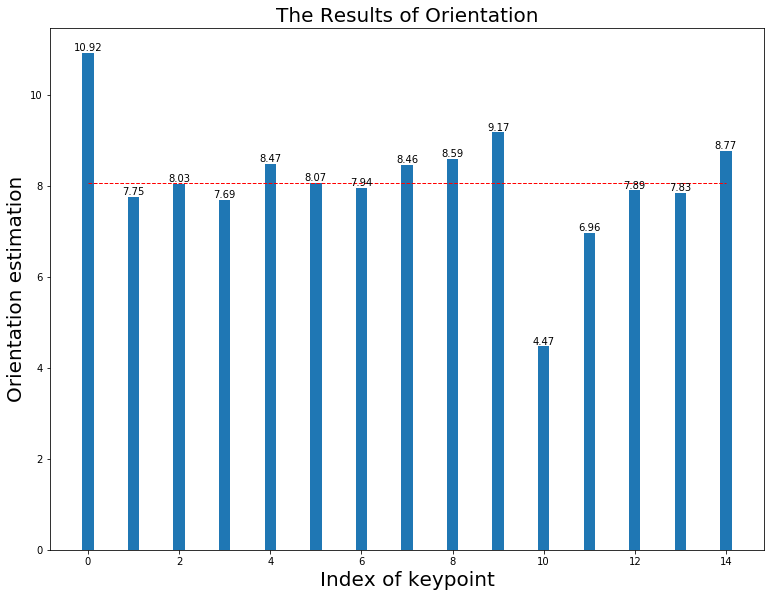

Final result: [     10.918       7.754      8.0336      7.6886      8.4742      8.0679      7.9427      8.4583      8.5915      9.1683      4.4661       6.959      7.8937      7.8332      8.7707]
FD Rotate(8.1):mean(8.068), median(8.126) in 0.011
The HoG estimation when (8.1) is  8


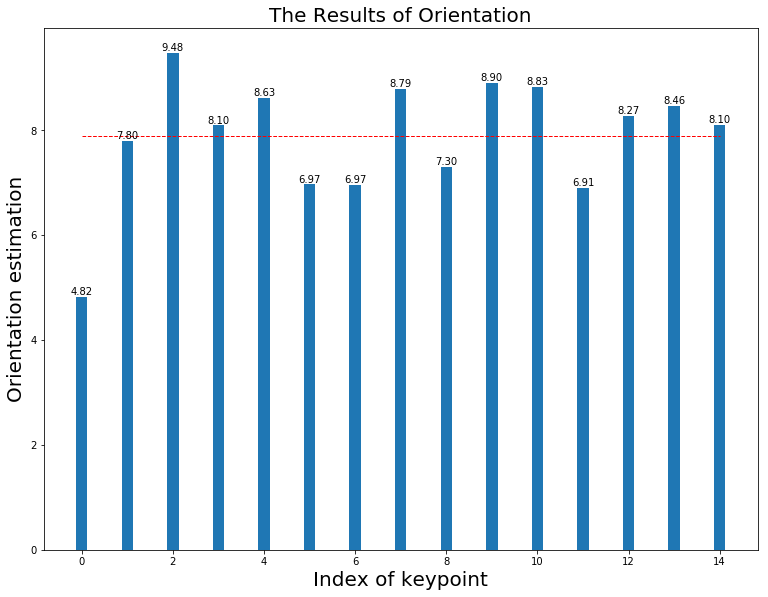

Final result: [     4.8201      7.7965      9.4793       8.095      8.6252      6.9683      6.9662      8.7865      7.3019      8.9034      8.8315       6.909      8.2703      8.4617      8.0998]
FD Rotate(8.2):mean(7.888), median(8.107) in 0.011
The HoG estimation when (8.2) is  8


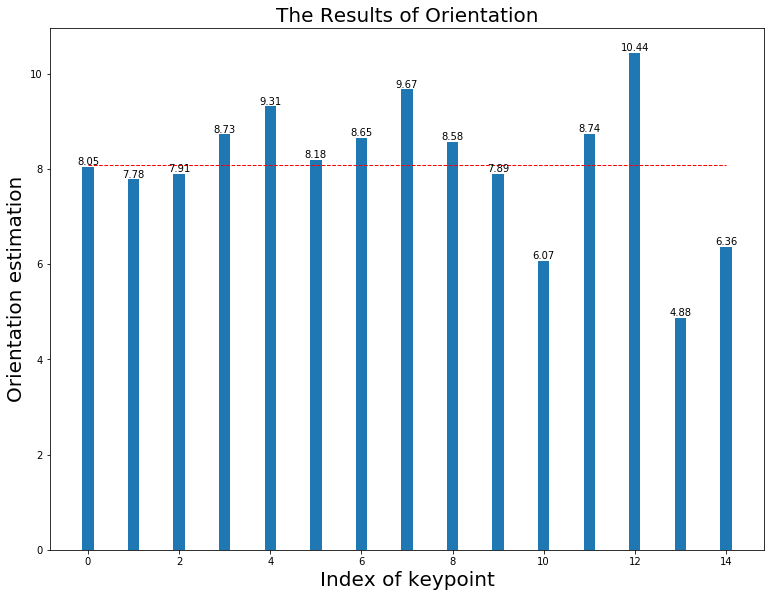

Final result: [     8.0472      7.7829      7.9051      8.7291      9.3129       8.184      8.6481      9.6718      8.5754      7.8942      6.0739      8.7364      10.441      4.8769      6.3637]
FD Rotate(8.3):mean(8.083), median(8.321) in 0.021
The HoG estimation when (8.3) is  8


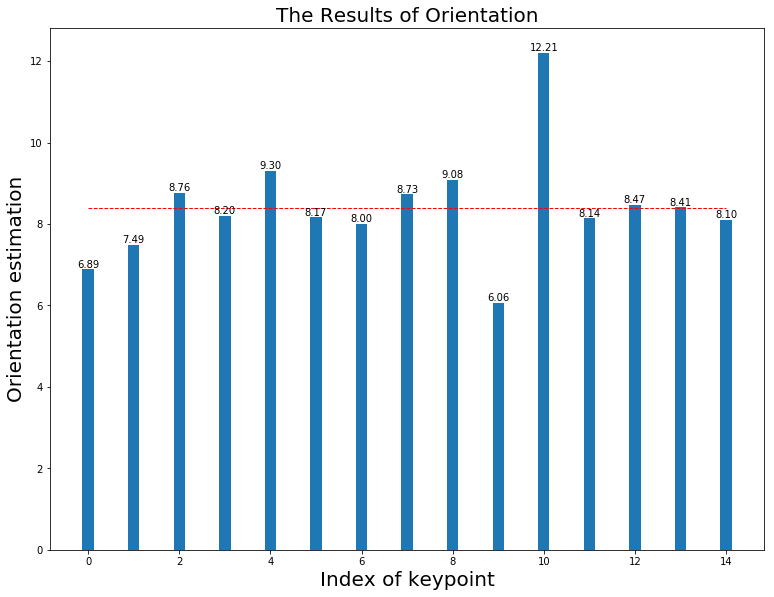

Final result: [     6.8897      7.4946      8.7637      8.1969      9.2975      8.1657      7.9971      8.7274      9.0766      6.0606      12.206      8.1367       8.466      8.4124      8.1038]
FD Rotate(8.4):mean(8.400), median(8.287) in 0.012
The HoG estimation when (8.4) is  9


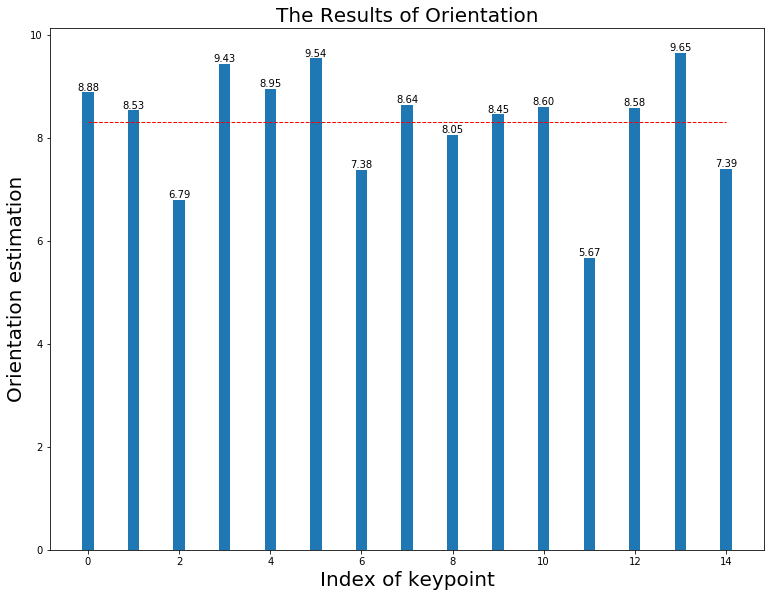

Final result: [      8.882      8.5305      6.7927      9.4297      8.9482      9.5412      7.3807      8.6385      8.0549      8.4519      8.5986       5.666      8.5783      9.6482       7.392]
FD Rotate(8.5):mean(8.302), median(8.491) in 0.012
The HoG estimation when (8.5) is  9


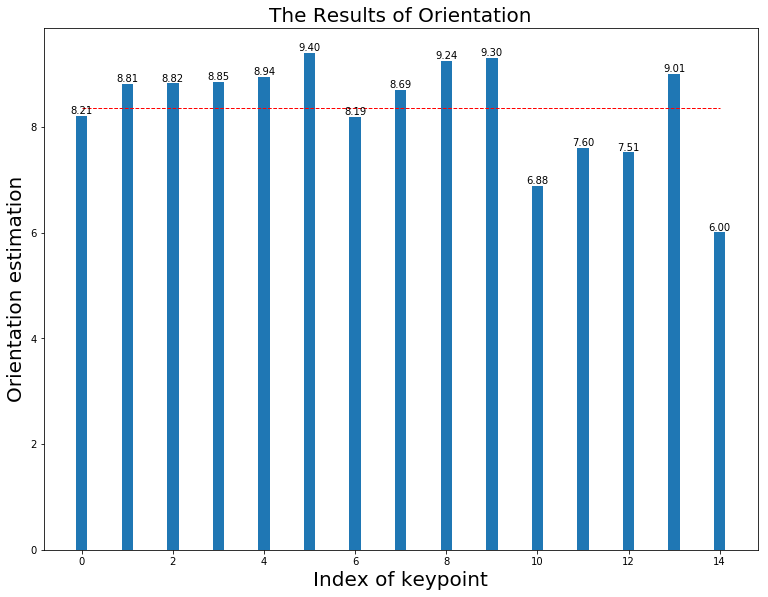

Final result: [     8.2126      8.8068      8.8195       8.853      8.9426      9.4001      8.1881      8.6924      9.2404      9.3021      6.8844      7.6041      7.5144      9.0085      6.0029]
FD Rotate(8.6):mean(8.365), median(8.534) in 0.011
The HoG estimation when (8.6) is  9


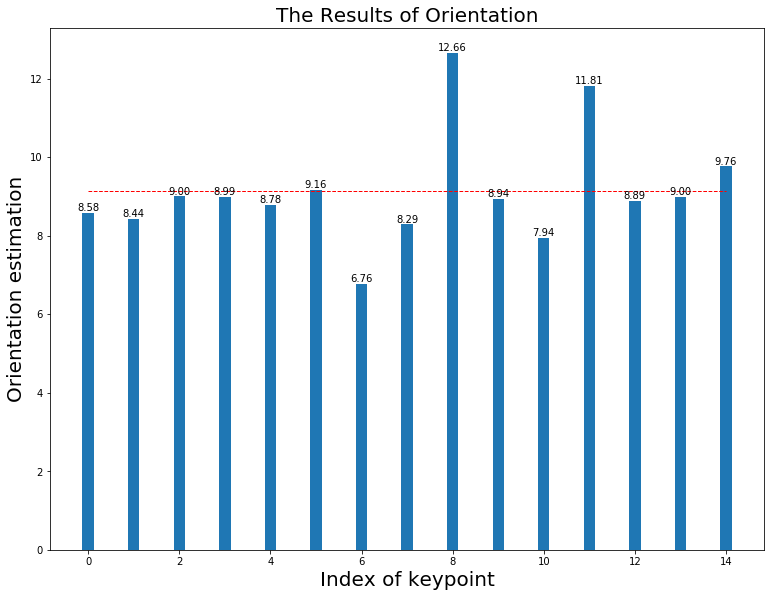

Final result: [     8.5833      8.4357      9.0017      8.9899      8.7781      9.1629      6.7641      8.2861      12.657      8.9372      7.9421      11.806      8.8938       8.996      9.7616]
FD Rotate(8.7):mean(9.133), median(8.814) in 0.012
The HoG estimation when (8.7) is  9


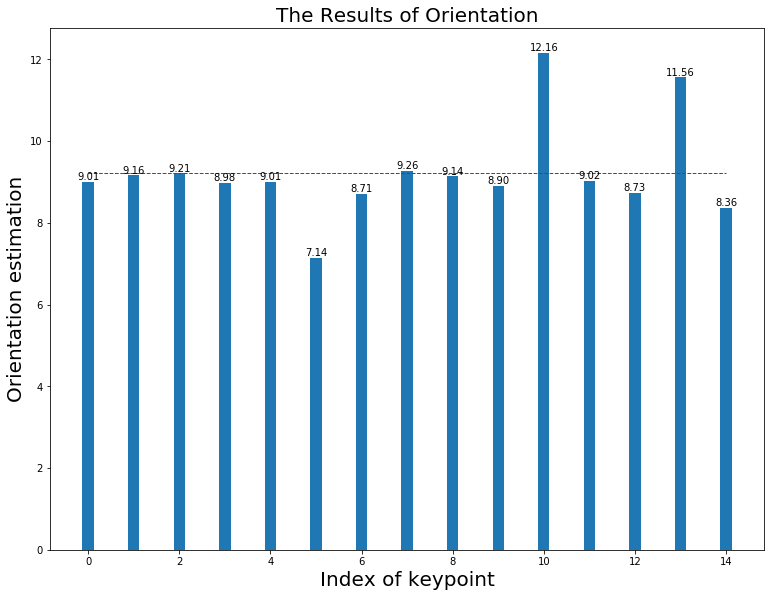

Final result: [     9.0071       9.162      9.2082       8.983      9.0068      7.1408      8.7144       9.265      9.1373      8.8973      12.161      9.0223      8.7325      11.557      8.3576]
FD Rotate(8.8):mean(9.223), median(8.818) in 0.011
The HoG estimation when (8.8) is  9


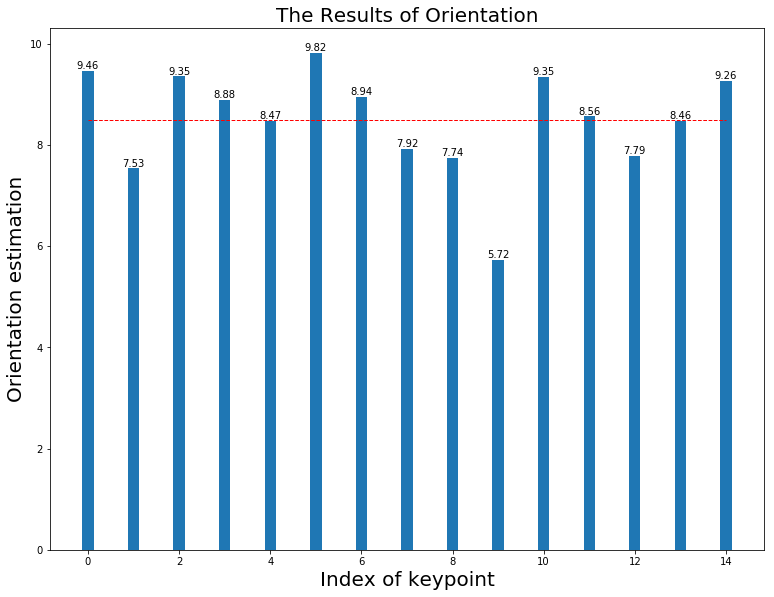

Final result: [     9.4643      7.5329      9.3487      8.8841      8.4725      9.8166      8.9421       7.921      7.7414      5.7233      9.3453      8.5585      7.7869      8.4648      9.2552]
FD Rotate(8.9):mean(8.484), median(8.681) in 0.019
The HoG estimation when (8.9) is  9


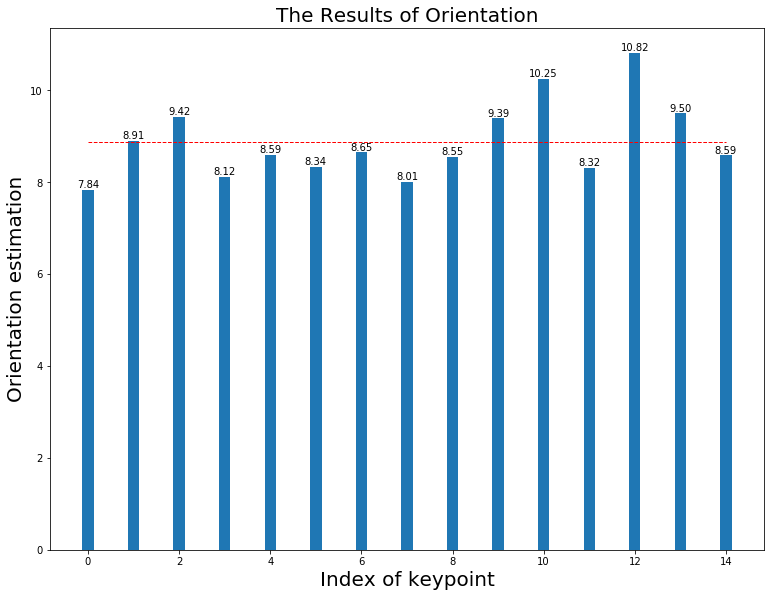

Final result: [     7.8369      8.9079      9.4229      8.1225      8.5901      8.3399      8.6539      8.0072      8.5497      9.3944       10.25      8.3166      10.821      9.5042      8.5866]
FD Rotate(9.0):mean(8.887), median(8.749) in 0.012
The HoG estimation when (9.0) is  9


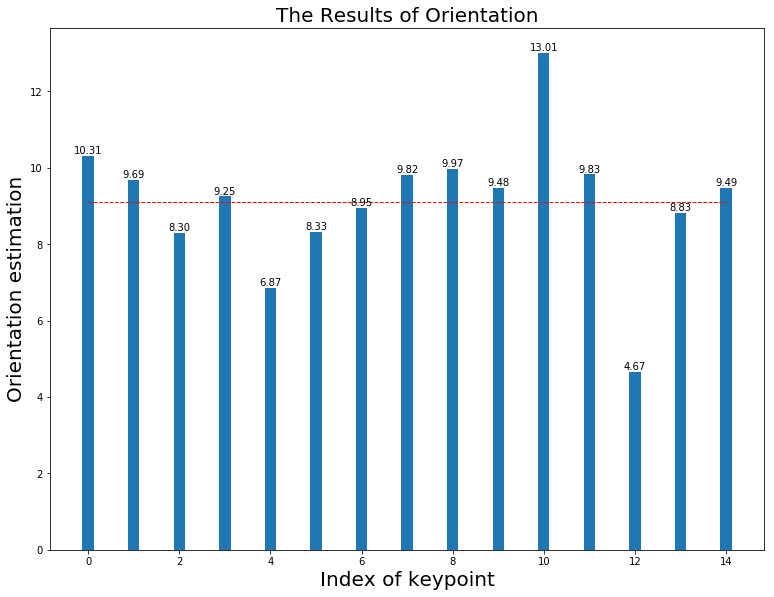

Final result: [     10.312      9.6852      8.2957      9.2529      6.8671      8.3276      8.9538      9.8209      9.9727      9.4828      13.013      9.8292      4.6675      8.8296       9.485]
FD Rotate(9.1):mean(9.120), median(9.354) in 0.011
The HoG estimation when (9.1) is  9


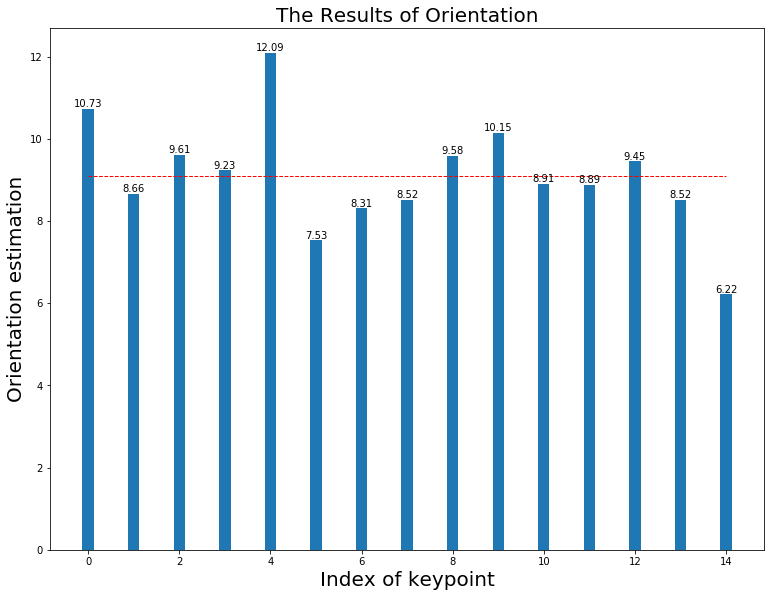

Final result: [     10.733      8.6584      9.6109      9.2345      12.092      7.5283      8.3081      8.5214      9.5801      10.147      8.9093      8.8876        9.45      8.5161      6.2166]
FD Rotate(9.2):mean(9.093), median(9.083) in 0.017
The HoG estimation when (9.2) is  9


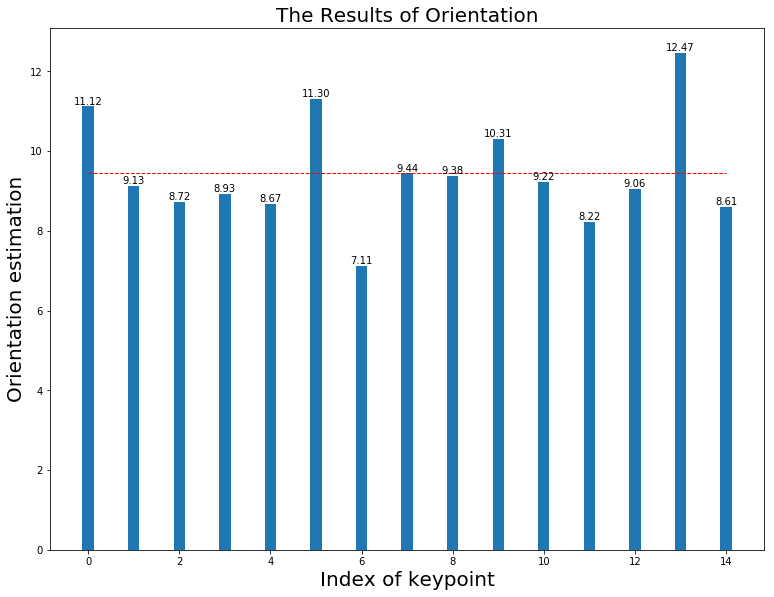

Final result: [      11.12      9.1336      8.7173      8.9319      8.6674        11.3      7.1148       9.441      9.3848       10.31      9.2216      8.2193      9.0594      12.465      8.6094]
FD Rotate(9.3):mean(9.446), median(9.235) in 0.011
The HoG estimation when (9.3) is  9


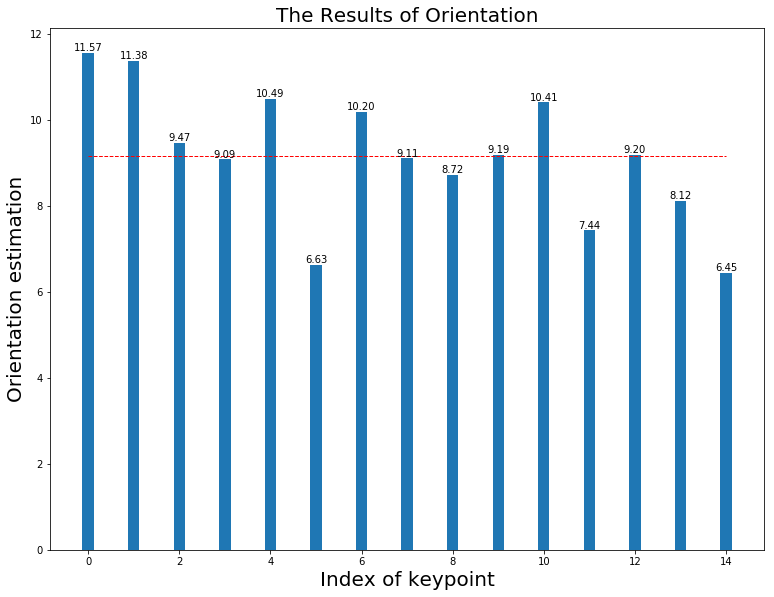

Final result: [     11.568      11.385      9.4696      9.0874      10.495      6.6346      10.198      9.1082       8.721      9.1896      10.413      7.4351      9.1955      8.1214      6.4457]
FD Rotate(9.4):mean(9.164), median(9.221) in 0.012
The HoG estimation when (9.4) is  9


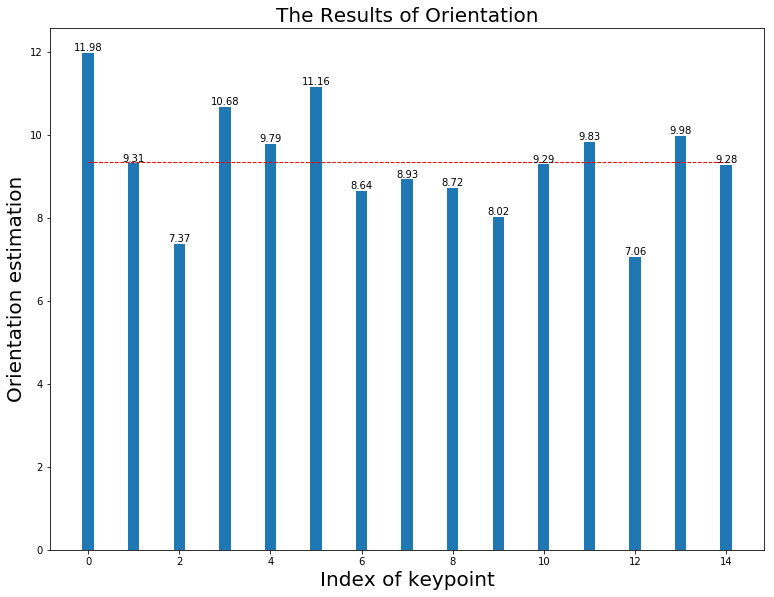

Final result: [     11.977      9.3137      7.3693      10.679      9.7891      11.161      8.6403       8.927      8.7178      8.0204      9.2899      9.8311      7.0576      9.9803      9.2765]
FD Rotate(9.5):mean(9.335), median(9.307) in 0.011
The HoG estimation when (9.5) is 10


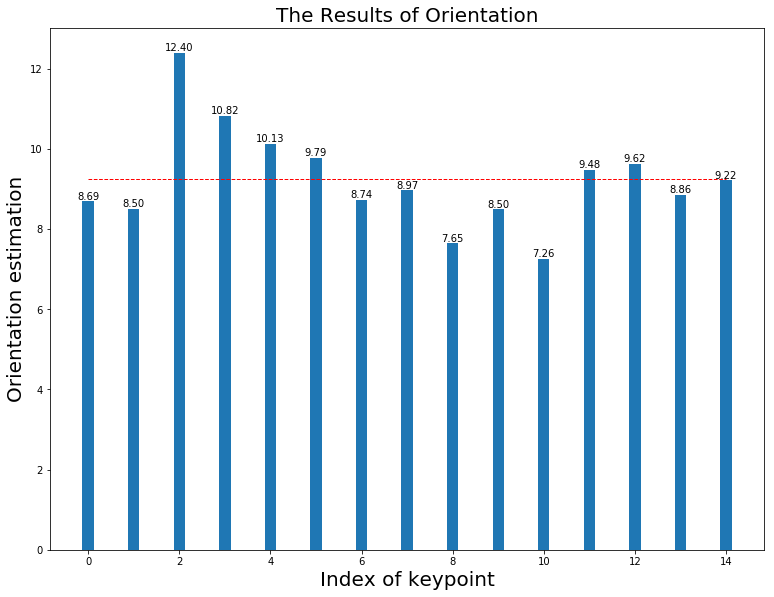

Final result: [     8.6946      8.5025      12.401      10.821      10.127      9.7863      8.7367      8.9672       7.647      8.4962      7.2629      9.4785      9.6232      8.8611      9.2171]
FD Rotate(9.6):mean(9.241), median(9.016) in 0.012
The HoG estimation when (9.6) is 10


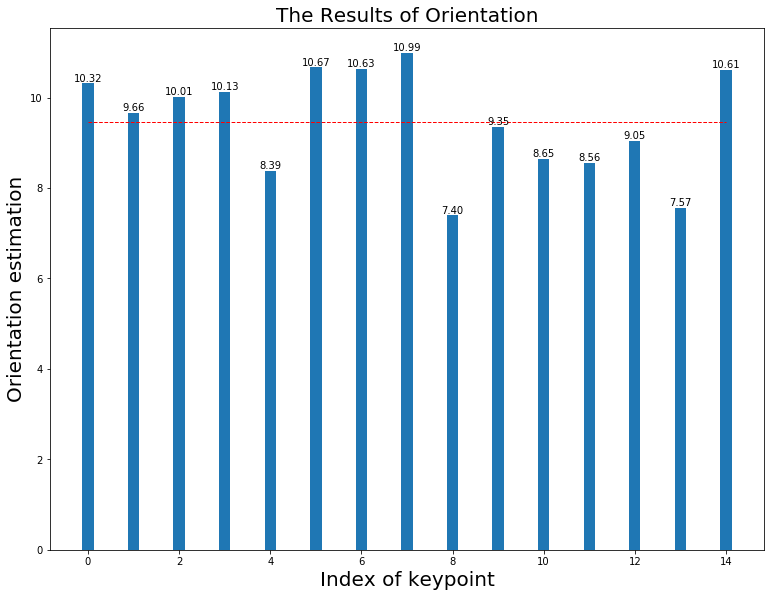

Final result: [     10.316      9.6636      10.014       10.13      8.3859      10.668      10.627      10.991       7.397      9.3541       8.652      8.5575      9.0463      7.5662      10.606]
FD Rotate(9.7):mean(9.465), median(9.770) in 0.011
The HoG estimation when (9.7) is 10


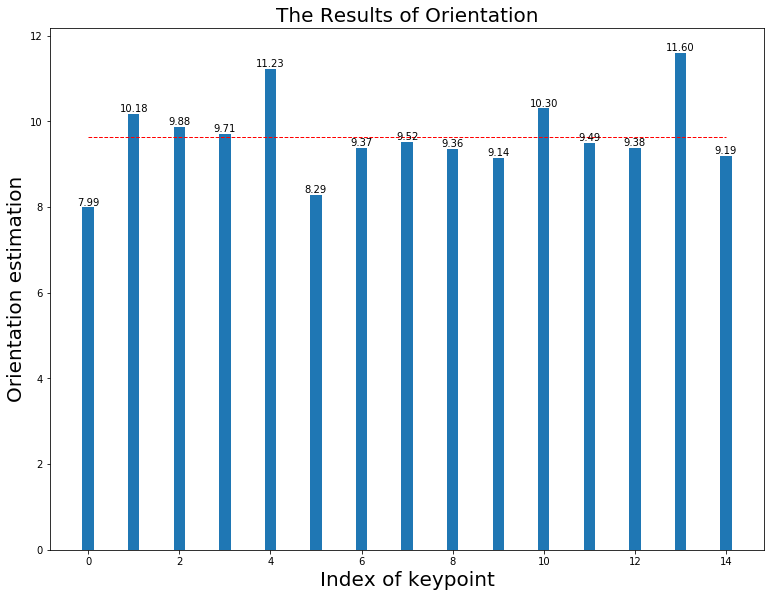

Final result: [     7.9916      10.178      9.8776      9.7071      11.228      8.2895      9.3741      9.5232      9.3568      9.1403      10.299      9.4918      9.3805      11.599      9.1949]
FD Rotate(9.8):mean(9.642), median(9.502) in 0.011
The HoG estimation when (9.8) is 10


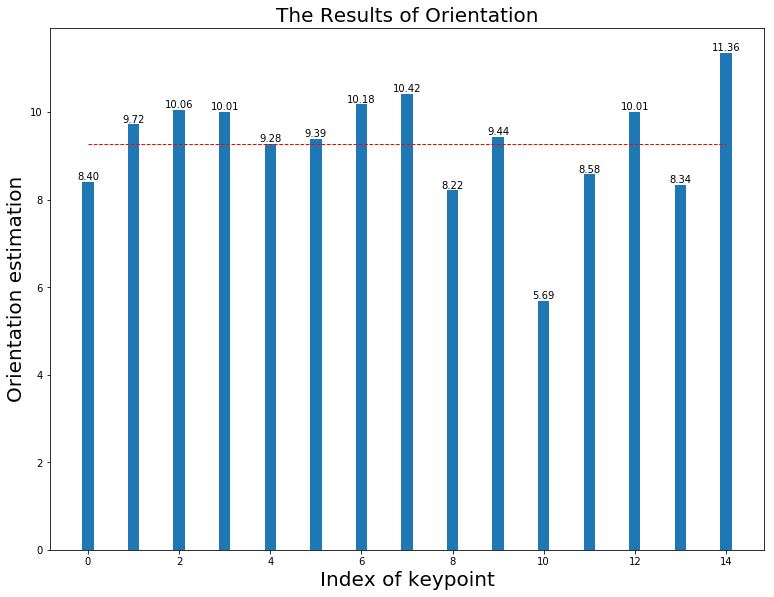

Final result: [     8.4021      9.7224      10.062      10.011      9.2831      9.3888       10.18      10.425      8.2151      9.4428      5.6919      8.5804      10.005      8.3352      11.358]
FD Rotate(9.9):mean(9.274), median(9.529) in 0.016
The HoG estimation when (9.9) is 10


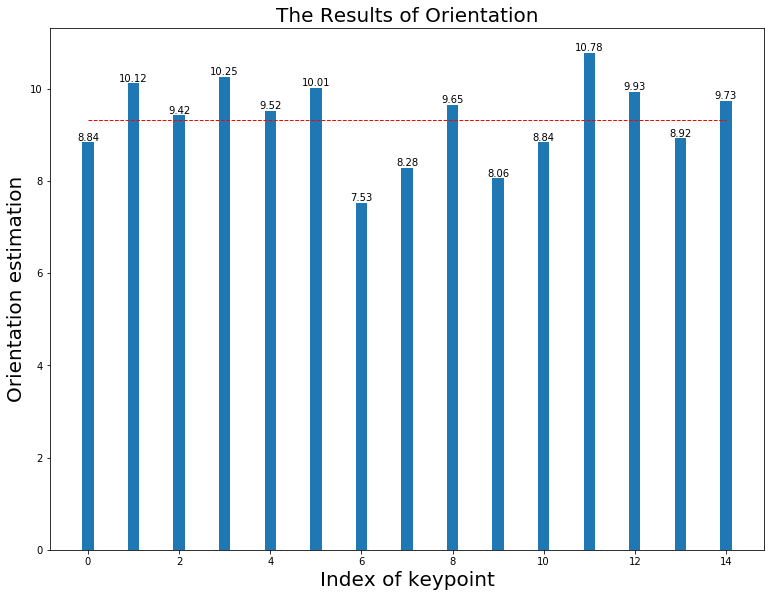

Final result: [     8.8366      10.119      9.4227      10.251      9.5223      10.013      7.5317      8.2779      9.6463      8.0561       8.836      10.779      9.9338      8.9231      9.7337]
FD Rotate(10.0):mean(9.325), median(9.325) in 0.012
The HoG estimation when (10.0) is 10


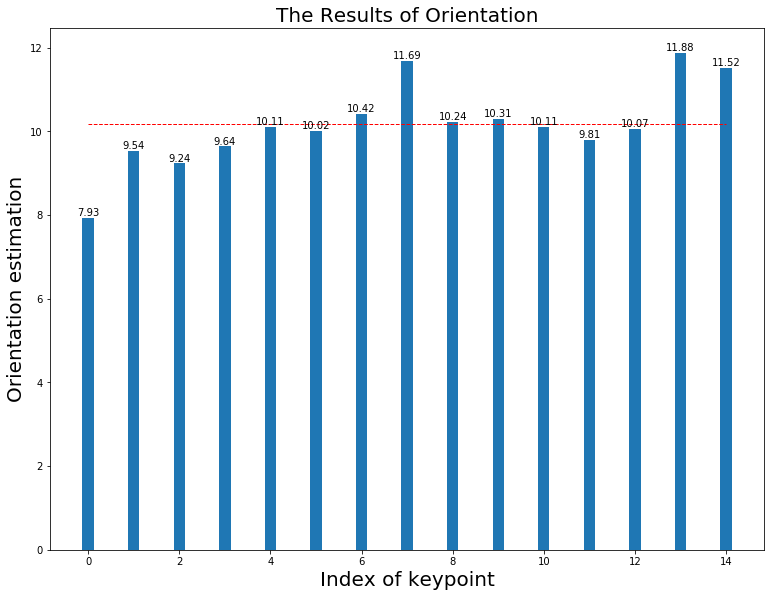

Final result: [     7.9265      9.5391      9.2396      9.6426      10.108       10.02      10.419      11.694      10.235       10.31      10.112      9.8069      10.066      11.881      11.519]
FD Rotate(10.1):mean(10.168), median(10.328) in 0.011
The HoG estimation when (10.1) is 10


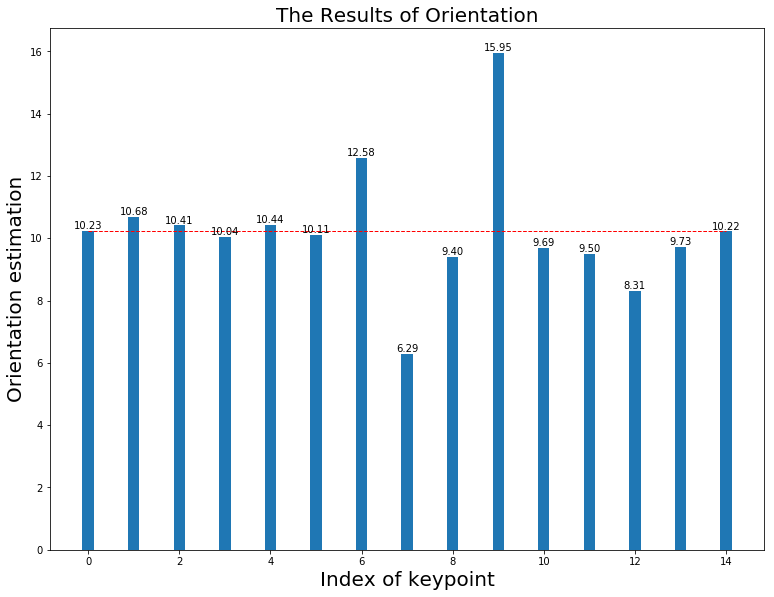

Final result: [     10.229       10.68      10.408      10.044      10.438      10.112      12.585      6.2866      9.4009      15.951      9.6883      9.4988      8.3079       9.727      10.217]
FD Rotate(10.2):mean(10.238), median(9.896) in 0.021
The HoG estimation when (10.2) is 10


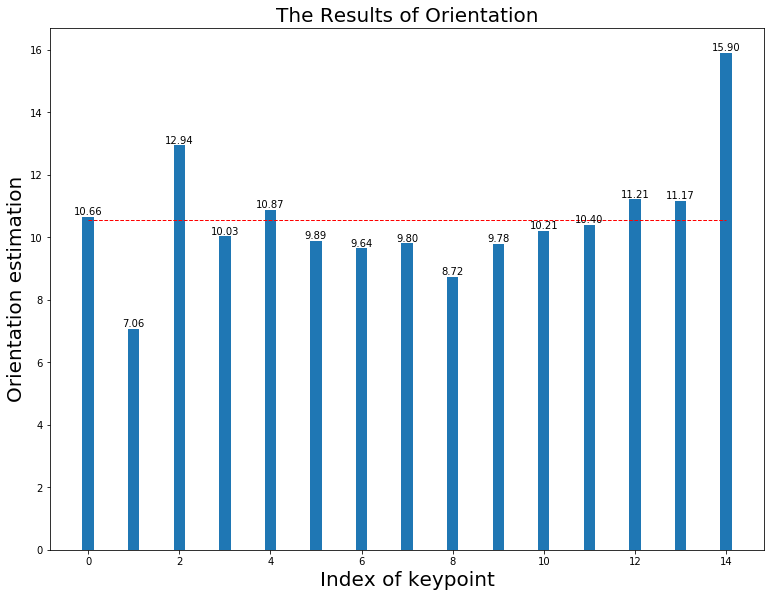

Final result: [     10.657       7.064      12.939      10.033       10.87      9.8871       9.642      9.8013      8.7218      9.7792       10.21      10.405      11.212       11.17      15.903]
FD Rotate(10.3):mean(10.553), median(10.199) in 0.012
The HoG estimation when (10.3) is 10


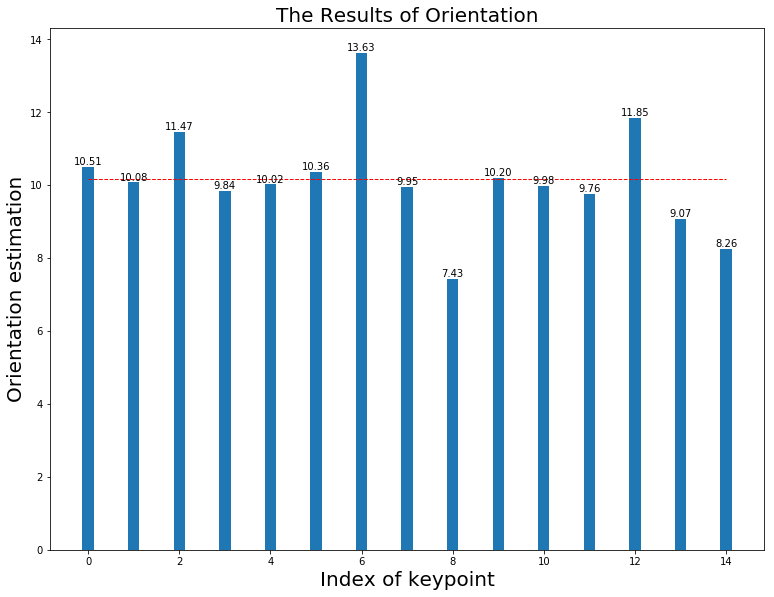

Final result: [     10.508      10.075      11.471      9.8433      10.023       10.36      13.632      9.9476       7.426      10.195      9.9759      9.7555      11.852      9.0744      8.2561]
FD Rotate(10.4):mean(10.160), median(10.103) in 0.012
The HoG estimation when (10.4) is 11


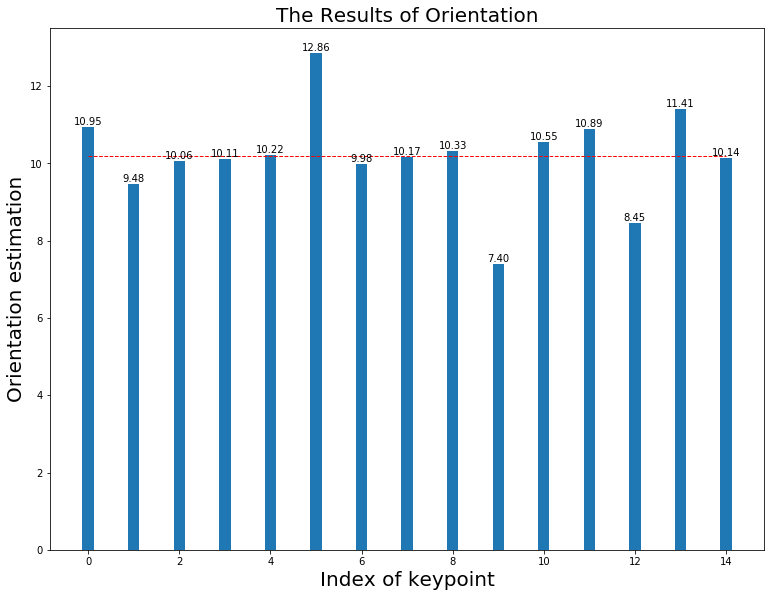

Final result: [     10.948      9.4758      10.059      10.112      10.217      12.862      9.9817      10.167      10.327      7.4031      10.552      10.894      8.4529      11.412      10.145]
FD Rotate(10.5):mean(10.201), median(10.211) in 0.012
The HoG estimation when (10.5) is 10


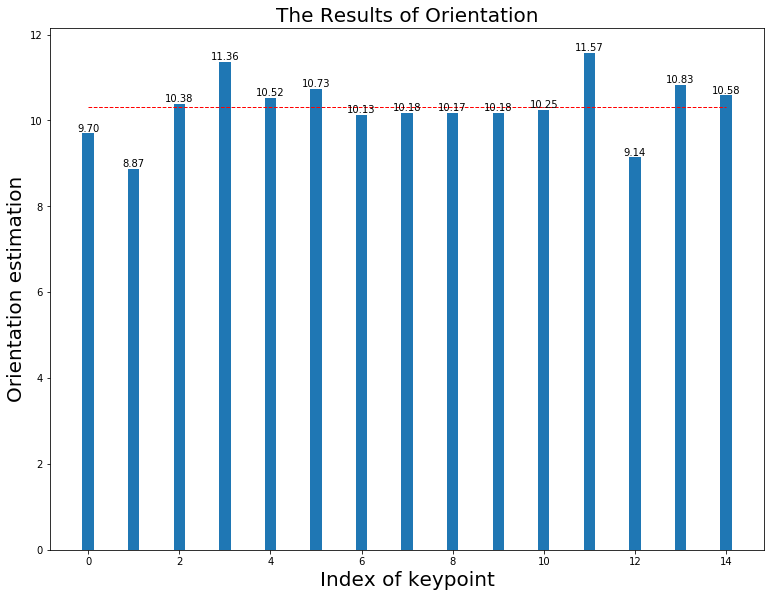

Final result: [     9.6976      8.8674       10.38      11.359      10.517      10.733      10.134      10.178      10.173      10.181       10.25      11.574      9.1413      10.835       10.58]
FD Rotate(10.6):mean(10.307), median(10.307) in 0.011
The HoG estimation when (10.6) is 11


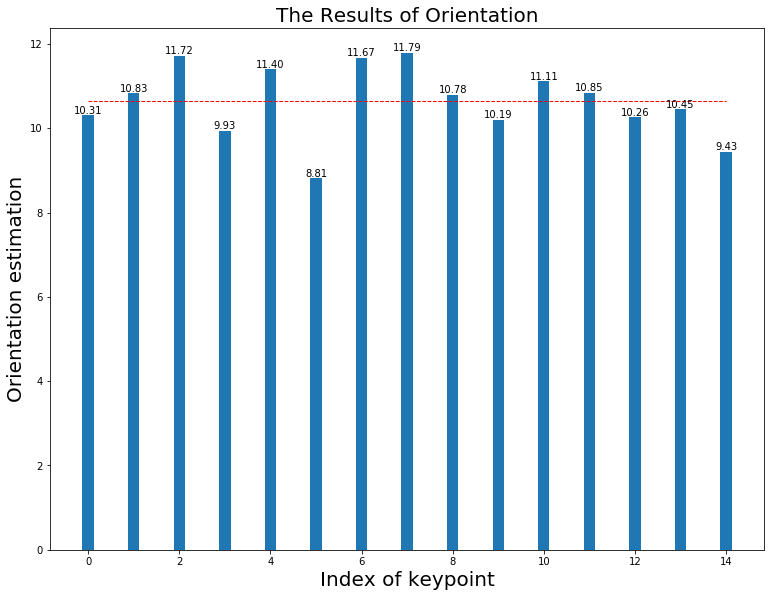

Final result: [     10.305      10.825       11.72      9.9321      11.398      8.8101      11.666       11.79      10.783      10.194       11.11      10.847      10.258      10.446      9.4345]
FD Rotate(10.7):mean(10.635), median(10.635) in 0.011
The HoG estimation when (10.7) is 11


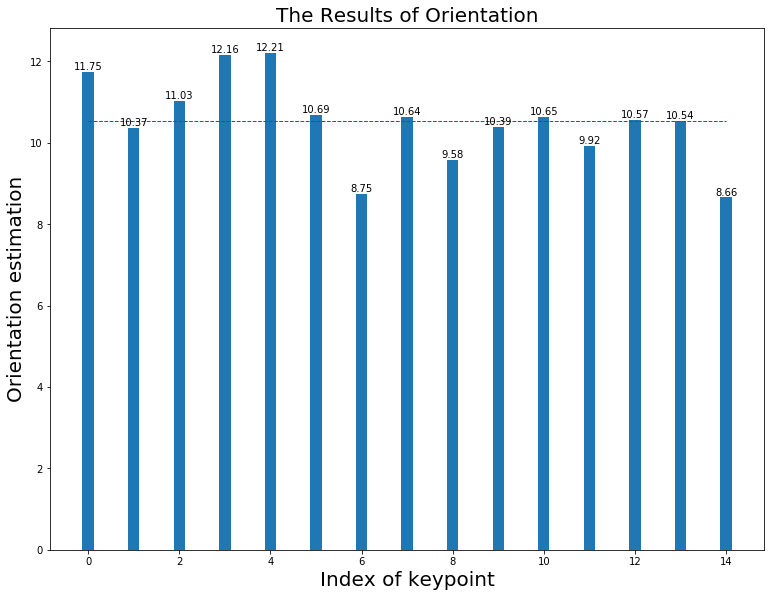

Final result: [     11.751      10.373       11.03      12.162      12.213      10.691      8.7535      10.635      9.5808      10.393      10.647      9.9213      10.567       10.54      8.6617]
FD Rotate(10.8):mean(10.528), median(10.528) in 0.012
The HoG estimation when (10.8) is 11


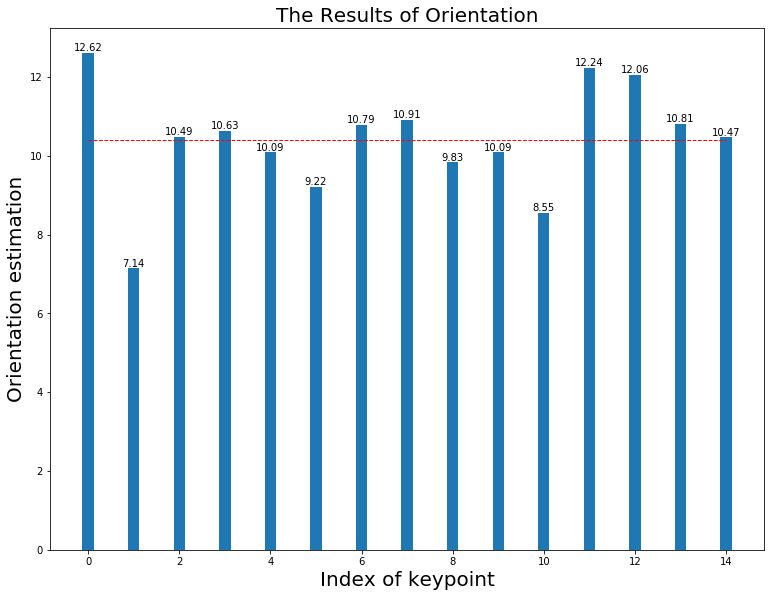

Final result: [     12.618      7.1424      10.487      10.629       10.09      9.2162      10.794      10.908      9.8339      10.086      8.5547      12.237      12.063      10.815      10.471]
FD Rotate(10.9):mean(10.396), median(10.476) in 0.011
The HoG estimation when (10.9) is 11


In [6]:
mode_list = ["SIFT", "ORB"]

sift_error = np.array([])
orb_error = np.array([])

for mode in mode_list:
    for rotate_angle in np.arange(1.0, 11.0, 0.1):
        M = cv2.getRotationMatrix2D(center, rotate_angle, 1)
        img_rotate = cv2.warpAffine(img_base, M, (w, h))
        
        fd_median, fd_mean, exe_time = angle_cal(img_orig, img_rotate, mode, show_results= True)
        
        print("FD Rotate({0:3.1f}):mean({1:5.3f}), median({2:5.3f}) in {3:.3f}"\
              .format(rotate_angle, fd_mean, fd_median, exe_time))
        
        # Gradients Method
        hist_base = HoG_cal(img_base, mag_thres= thres, bin_num= bins)
        hist_rotate = HoG_cal(img_rotate, mag_thres= thres, bin_num= bins)
        
        angle = angle_HoG(hist_base, hist_rotate, limits = angle_limits)
        print("The HoG estimation when ({0:.1f}) is {1:2d}" \
            .format(rotate_angle ,angle))
        
        if mode == "SIFT":
            sift_error = np.append(sift_error, np.abs(fd_mean - rotate_angle))
        elif mode == "ORB":
            orb_error = np.append(orb_error, np.abs(fd_mean - rotate_angle))

In [ ]:
plt.figure(figsize=(16, 8))
index_error = np.arange(1.0, 11.0, 0.1)
plt.plot(index_error, sift_error, 'r', label = 'SIFT error')
plt.plot(index_error, orb_error, 'g', label = 'ORB error')
plt.legend(fontsize = 14)
plt.xlabel('Real rotation angle (degree)' , fontsize = 16)
plt.ylabel('Absolute error (degree)', fontsize = 16)
plt.xticks(np.arange(1.0, 11.0, 0.5))
plt.savefig('output/siftorb_error.png')
plt.show()

KeyboardInterrupt: 

<font face='Ubuntu' size = 4>
    
## Histogram Filter
### SIFT 
Using sift as the \textbf{Feature descriptor}  


In [ ]:
sift_error_fd = np.array([])
sift_error_hog_fd = np.array([])

for rotate_angle in np.arange(0.5, 8.0, 0.1):
    print("-" * 100 + str(rotate_angle))
    M = cv2.getRotationMatrix2D(center, rotate_angle, 1)
    img_rotate = cv2.warpAffine(img_base, M, (w, h))

    fd_median, fd_mean, exe_time = angle_cal(img_orig, img_rotate, mode = "SIFT")
    
    # Gradients Method
    hist_base = HoG_cal(img_base, mag_thres= thres, bin_num= bins)
    hist_rotate = HoG_cal(img_rotate, mag_thres= thres, bin_num= bins)

    hog_angle = angle_HoG(hist_base, hist_rotate, limits = angle_limits)
    

    angle_results = match_angels(img_orig, img_rotate, mode = "SIFT")
    
    # Filter the results
    angle_floor = hog_angle - 1 
    angle_ceiling = hog_angle + 1
    index = (angle_results > angle_floor)* (angle_results < angle_ceiling) * angle_results
    angle_filter_results = angle_results[np.nonzero(index)]
    angle_filter = np.mean(angle_filter_results)
    
    sift_error_fd = np.append(sift_error_fd, np.abs(fd_mean - rotate_angle))
    sift_error_hog_fd = np.append(sift_error_hog_fd, np.abs(angle_filter - rotate_angle))
    
    
    print("FD Rotate({0:3.1f}):mean({1:5.3f}), median({2:5.3f}) in {3:.3f}"\
          .format(rotate_angle, fd_mean, fd_median, exe_time))
    print("The HoG estimation when ({0:.1f}) is {1:2d}" \
        .format(rotate_angle, hog_angle))
    print("The HoG & FD estimation when ({0:.1f}) is {1:.2f}" \
        .format(rotate_angle, angle_filter))
    
    
    plot_result_bar(range(len(angle_results)), angle_results, fd_mean)
    plot_result_bar(range(len(angle_filter_results)), angle_filter_results, angle_filter)

In [ ]:
plt.plot(sift_error_fd, 'r', label = 'point matching method')
plt.plot(sift_error_hog_fd, 'g', label = 'point matching method with filter')
plt.legend()
plt.xlabel('Angle(degree)' )
plt.ylabel('histogram')
plt.title('The error using SIFT matching', loc = 'left')
plt.show() 

<font face='Ubuntu' size = 4>

### ORB
Using ORB as the feature desciptor

In [ ]:
orb_error_fd = np.array([])
orb_error_hog_fd = np.array([])

for rotate_angle in np.arange(0.5, 8.0, 0.1):
    print("-" * 100)
    M = cv2.getRotationMatrix2D(center, rotate_angle, 1)
    img_rotate = cv2.warpAffine(img_base, M, (w, h))

    fd_median, fd_mean, exe_time = angle_cal(img_orig, img_rotate, mode = "ORB")
    
    # Gradients Method
    start_time = time.time()
    hist_base = HoG_cal(img_base, mag_thres= thres, bin_num= bins)
    hist_rotate = HoG_cal(img_rotate, mag_thres= thres, bin_num= bins)

    hog_angle = angle_HoG(hist_base, hist_rotate, limits = angle_limits)
    angle_results = match_angels(img_orig, img_rotate, mode = "ORB")
    
    # Filter the results
    angle_floor = hog_angle - 1 
    angle_ceiling = hog_angle + 1
    index = (angle_results > angle_floor)* (angle_results < angle_ceiling) * angle_results
    angle_filter_results = angle_results[np.nonzero(index)]
    angle_filter = np.mean(angle_filter_results)
    hog_time = time.time() - start_time
    
    orb_error_fd = np.append(orb_error_fd, np.abs(fd_mean - rotate_angle))
    orb_error_hog_fd = np.append(orb_error_hog_fd, np.abs(angle_filter - rotate_angle))
    
    
    print("FD Rotate({0:3.1f}):mean({1:5.3f}), median({2:5.3f}) in {3:.3f}"\
          .format(rotate_angle, fd_mean, fd_median, exe_time))
    print("The HoG estimation when ({0:.1f}) is {1:2d}" \
        .format(rotate_angle, hog_angle))
    print("The HoG & FD estimation when ({0:.1f}) is {1:.2f} in {2:.3f}" \
        .format(rotate_angle, angle_filter, hog_time))
    
    plot_result_bar(range(len(angle_results)), angle_results, fd_mean)
    plot_result_bar(range(len(angle_filter_results)), angle_filter_results, angle_filter)

In [ ]:
plt.figure(figsize=(16, 6))
index_error = np.arange(0.5, 8.0, 0.1)
plt.plot(index_error, orb_error_fd, 'r', label = 'Poing matching orientation estimation')
plt.plot(index_error, orb_error_hog_fd, 'g', label = 'Poing matching with gradient orientation histogram estimation')
plt.legend(fontsize = 14)
plt.xlabel('Real rotation angle (degree)', fontsize = 16 )
plt.ylabel('Absolute error (degree)', fontsize = 16)
plt.ylim([0, 1.6])
plt.xticks(np.arange(0.5, 8.5, 0.5))
plt.title('The error using ORB point matching method', fontsize = 16)
plt.savefig('output/HOG_ORB_error.png')
plt.show()

<font face='Ubuntu' size = 4>

### ORB SIFT comparison

In [ ]:
plt.figure(figsize=(16, 7))
plt.plot(sift_error_fd, 'orange', label = 'sift_fd')
plt.plot(sift_error_hog_fd, 'blue',label = 'sift_hog&fd')
plt.plot(orb_error_fd, 'green',label = 'orb_fd')
plt.plot(orb_error_hog_fd, 'r',label = 'orb_hog&fd')
plt.legend()
plt.savefig('output/all_error.png')
plt.show()

In [ ]:
print(np.mean(sift_error_fd))
print(np.mean(sift_error_hog_fd))
print(np.mean(orb_error_fd))
print(np.mean(orb_error_hog_fd))